# This notebook does peak hydrologic discharge calculation
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [1]:
# load libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
import seaborn as sns
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.image as mpimg
from shapely.geometry import box
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import contextily as ctx
from datetime import datetime
import textwrap
import re
import os
import glob
from tqdm import tqdm
import datetime

In [2]:
import warnings
# Suppress the specific RuntimeWarning
warnings.filterwarnings("ignore")
# Suppress all UserWarnings, including PerformanceWarnings
warnings.simplefilter('ignore', category=UserWarning)
# plot with Arial font
plt.rcParams['font.family'] = 'Arial'

In [12]:
# Load culverts watershed
file_path=r"D:\culvert repo\Results\waterhsed_delineation_dir\combined_watersheds_info.shp"
culvert = gpd.read_file(file_path)
# Show the data frame
print(culvert.shape)
# Show the data frame columns
print(culvert.columns)
# number of rows with nan
print(f'number of rows with nan value: {int(culvert.isna().any(axis=1).sum())}')

(7474, 36)
Index(['BIN', 'Ini_lon', 'Ini_lat', 'lonsnap_10', 'latsnap_10', 'Area_10',
       'Peri_10', 'LFP_len_10', 'LFP_S_10', 'Bas_S_10', 'cul_S10',
       'lonsnap_20', 'latsnap_20', 'Area_20', 'Peri_20', 'LFP_len_20',
       'LFP_S_20', 'Bas_S_20', 'cul_S20', 'lonsnap_40', 'latsnap_40',
       'Area_40', 'Peri_40', 'LFP_len_40', 'LFP_S_40', 'Bas_S_40', 'cul_S40',
       'lonsnap_80', 'latsnap_80', 'Area_80', 'Peri_80', 'LFP_len_80',
       'LFP_S_80', 'Bas_S_80', 'cul_S80', 'geometry'],
      dtype='object')
number of rows with nan value: 0


# Filter culverts to include only verified ones

In [13]:
# Remove duplicate rows based on the BIN column, keep the first instance
culvert_cleaned = culvert.drop_duplicates(subset=['BIN'], keep='first')
# Reset the index
culvert_cleaned.reset_index(drop=True, inplace=True)
# Print the shape to verify
print(culvert_cleaned.shape)

(7474, 36)


In [14]:
culvert_cleaned.columns

Index(['BIN', 'Ini_lon', 'Ini_lat', 'lonsnap_10', 'latsnap_10', 'Area_10',
       'Peri_10', 'LFP_len_10', 'LFP_S_10', 'Bas_S_10', 'cul_S10',
       'lonsnap_20', 'latsnap_20', 'Area_20', 'Peri_20', 'LFP_len_20',
       'LFP_S_20', 'Bas_S_20', 'cul_S20', 'lonsnap_40', 'latsnap_40',
       'Area_40', 'Peri_40', 'LFP_len_40', 'LFP_S_40', 'Bas_S_40', 'cul_S40',
       'lonsnap_80', 'latsnap_80', 'Area_80', 'Peri_80', 'LFP_len_80',
       'LFP_S_80', 'Bas_S_80', 'cul_S80', 'geometry'],
      dtype='object')

In [15]:
# Sanity checks (Area and length cant be negative)
conditions = {
    'Area_10': culvert_cleaned['Area_10'] <= 0,
    'Area_20': culvert_cleaned['Area_20'] <= 0,
    'Area_40': culvert_cleaned['Area_40'] <= 0,
    'Area_80': culvert_cleaned['Area_80'] <= 0,
    'LFP_len_10': culvert_cleaned['LFP_len_10'] <= 0,
    'LFP_len_20': culvert_cleaned['LFP_len_20'] <= 0,
    'LFP_len_40': culvert_cleaned['LFP_len_40'] <= 0,
    'LFP_len_80': culvert_cleaned['LFP_len_80'] <= 0,
    'Bas_S_10':culvert_cleaned['Bas_S_10'] <= 0,
    'Bas_S_20':culvert_cleaned['Bas_S_20'] <= 0,
    'Bas_S_40':culvert_cleaned['Bas_S_40'] <= 0,
    'Bas_S_80':culvert_cleaned['Bas_S_80'] <= 0,

}
# Print the number of rows to be removed and their percentages for each column
for col, condition in conditions.items():
    count = condition.sum()
    percent = (count / len(culvert_cleaned)) * 100
#    print(f'Rows with {col} <= 0: {count}, percent of rows: {percent:.2f} %')
# Combine the conditions to get the total number of rows to be removed
combined_conditions = np.logical_or.reduce(list(conditions.values()))
# Replace values based on combined conditions with NaN
for col in culvert_cleaned.columns:
    if col in conditions:
        culvert_cleaned[col] = np.where(combined_conditions, np.nan, culvert_cleaned[col])
# Create a new dataframe with rows that don't have any NaN values in the specified columns
Culvert_clea_remov = culvert_cleaned.dropna(subset=conditions.keys())
culvert=Culvert_clea_remov
# Print the total number of changed records
num_removed_combined = combined_conditions.sum()
#print(f'Total number of removed records: {num_removed_combined}, percent of rows: {(num_removed_combined / len(culvert_cleaned)) * 100:.1f} %')
#print(f'Number of rows with nan value in culvert dataframe: {int(culvert.isna().any(axis=1).sum())}')
print(f'Culvert dataframe shape is {culvert.shape}')

Culvert dataframe shape is (7136, 36)


#### Compare the drainge area with streamstats calculation

In [ ]:
#load the drain area of the streamstats
file_path=r"D:\culvert repo\Results\Streamstats results\all_merged_culverts_watersheds.shp"
streamstats_watersheds = gpd.read_file(file_path)
streamstats=streamstats_watersheds.drop_duplicates(subset=['BIN'],keep='first')
streamstats.reset_index(drop=True, inplace=True)
streamstats.head()

In [17]:
def process_culvert_delineation(culvert, streamstats_watersheds):
    # Merge StreamStats drainage area into culvert dataframe
    culvert = culvert.merge(streamstats, on='BIN', how='left')

    # Calculate Closest_Area and diff_area where DRNAREA is available
    mask_has_drnarea = culvert['DRNAREA'].notna()
    converted_areas = culvert.loc[mask_has_drnarea, ['Area_10', 'Area_20', 'Area_40', 'Area_80']] / 2.59e6
    differences = (converted_areas.T - culvert.loc[mask_has_drnarea, 'DRNAREA'].values).abs().T

    # Assign closest area and diff_area for those with DRNAREA
    culvert.loc[mask_has_drnarea, 'Closest_Area'] = differences.idxmin(axis=1).str.extract(r'(\d+)')[0]
    culvert.loc[mask_has_drnarea, 'diff_area'] = differences.min(axis=1) / culvert.loc[mask_has_drnarea, 'DRNAREA']

    # Assign delineation accuracy
    culvert['delineation_accuracy'] = culvert['diff_area'].apply(
        lambda x: True if pd.notna(x) and x <= 0.25 else False if pd.notna(x) else None
    )

    # Create mapping dictionaries
    area_mapping = {'10': 'Area_10', '20': 'Area_20', '40': 'Area_40', '80': 'Area_80'}
    LFP_Len_mapping = {'10': 'LFP_len_10', '20': 'LFP_len_20', '40': 'LFP_len_40', '80': 'LFP_len_80'}
    LFP_slo_mapping = {'10': 'LFP_S_10', '20': 'LFP_S_20', '40': 'LFP_S_40', '80': 'LFP_S_80'}
    cul_slo_mapping = {'10': 'cul_S10', '20': 'cul_S20', '40': 'cul_S40', '80': 'cul_S80'}
    Basin_slo_mapping = {'10': 'Bas_S_10', '20': 'Bas_S_20', '40': 'Bas_S_40', '80': 'Bas_S_80'}

    # Assign values only to culverts with accurate delineation
    mask_true = culvert['delineation_accuracy'] == True
    culvert.loc[mask_true, 'Area'] = culvert.loc[mask_true].apply(
        lambda row: row[area_mapping[row['Closest_Area']]], axis=1)
    culvert.loc[mask_true, 'LFP_len'] = culvert.loc[mask_true].apply(
        lambda row: row[LFP_Len_mapping[row['Closest_Area']]], axis=1)
    culvert.loc[mask_true, 'LFP_S'] = culvert.loc[mask_true].apply(
        lambda row: row[LFP_slo_mapping[row['Closest_Area']]], axis=1)
    culvert.loc[mask_true, 'cul_S'] = culvert.loc[mask_true].apply(
        lambda row: row[cul_slo_mapping[row['Closest_Area']]], axis=1)
    culvert.loc[mask_true, 'Bas_S'] = culvert.loc[mask_true].apply(
        lambda row: row[Basin_slo_mapping[row['Closest_Area']]], axis=1)
    
    # Explicitly set NaN for culverts with inaccurate or missing delineation
    mask_false_or_none = culvert['delineation_accuracy'] != True
    culvert.loc[mask_false_or_none, ['Area', 'LFP_len', 'LFP_S', 'cul_S', 'Bas_S']] = np.nan
    
    # Step to ensure NaN values for missing DRNAREA rows
    mask_missing = ~mask_has_drnarea
    culvert.loc[mask_missing, ['Closest_Area', 'diff_area', 'delineation_accuracy',
                               'Area', 'LFP_len', 'LFP_S', 'cul_S', 'Bas_S']] = np.nan
    return culvert

culvert = process_culvert_delineation(culvert, streamstats)

# Optional: check results
print(f"Total culverts with accurate delineation: {culvert['delineation_accuracy'].sum()}")

Total culverts with accurate delineation: 3268


In [ ]:
culvert

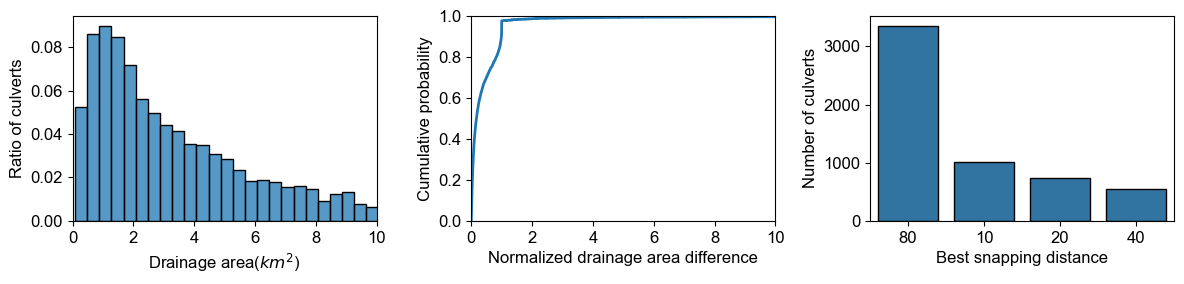

In [19]:
# set the font size
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # Two subplots in one row
# Histogram
sns.histplot(culvert.Area/1e6, bins=300, stat='probability', edgecolor='black', linewidth=1, ax=axes[0])
axes[0].set_xlabel(f'Drainage area($km^2$)')
axes[0].set_ylabel('Ratio of culverts')
axes[0].set_xlim(0, 10)
# CDF
sns.ecdfplot(culvert.diff_area, ax=axes[1],linewidth=2.0)
axes[1].set_xlabel(r'Normalized drainage area difference')
axes[1].set_ylabel('Cumulative probability')
axes[1].set_xlim(0, 10)
# Histogram
unique_counts = culvert.Closest_Area.value_counts()
sns.barplot(x=unique_counts.index, y=unique_counts.values, edgecolor='black', ax=axes[2])
axes[2].set_ylabel('Number of culverts')
axes[2].set_xlabel('Best snapping distance')
plt.tight_layout()  
plt.savefig("D:\culvert repo\Results\Figures\delineation_error_stats.png",dpi=300,bbox_inches='tight')
plt.show()

#### Large culvert basins might result from too big a snapping distance, so they are filtered.


In [ ]:
# Step 1: Assign delineation accuracy
culvert['delineation_accuracy'] = culvert['Area'].apply(
    lambda x: True if pd.notna(x) and x <= 1e7 else False if pd.notna(x) else None
)
# Step 2: Set variables to NaN where Area > 10^7
mask_large_area = culvert['Area'] > 1e7
print(f'Number of culverts with area more than 10 square km with similar drainage to streamstats {np.sum(mask_large_area)}')
culvert

#### Culvert in urban areas might have another subterranean drainage system, so they are filtered.

In [21]:
file_path=r"D:\culvert repo\Results\waterhsed_delineation_dir\combined_watersheds_nlcd_proportions.xlsx"
urbanization=pd.read_excel(file_path)
urbanization=urbanization.drop_duplicates(subset=['BIN'])
urbanization[['BIN','urbanized_pro']].head()

BIN  urbanized_pro
0  C810530       0.140065
1  C810540       0.075041
2  C810550       0.030348
3  C810541       0.103532
4  C810570       0.289157

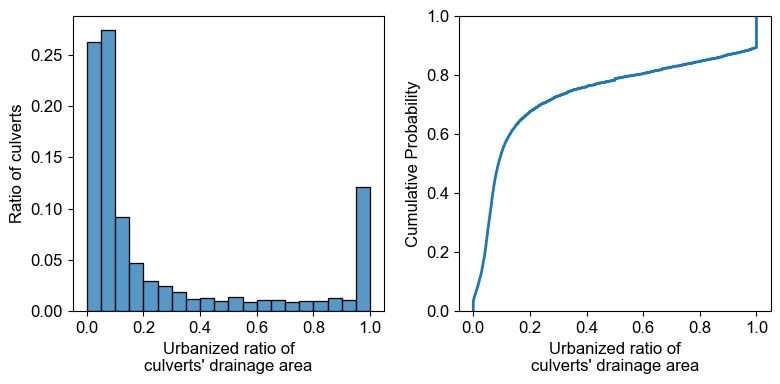

In [22]:
# Plot histogram and ECDF of urbanized portion of culverts' drainage area
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# Histogram
sns.histplot(urbanization['urbanized_pro'], stat='probability', bins=20, edgecolor='black', ax=axes[0])
axes[0].set_xlabel("Urbanized ratio of\nculverts' drainage area")
axes[0].set_ylabel("Ratio of culverts")
# ECDF
sns.ecdfplot(urbanization['urbanized_pro'], ax=axes[1],linewidth=2.0)
axes[1].set_xlabel("Urbanized ratio of\nculverts' drainage area")
axes[1].set_ylabel("Cumulative Probability")
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\drainagearea_urbanized_portion_hist_cdf.png", dpi=300, bbox_inches='tight')
plt.show()

In [23]:
def assign_urbanization_flag(culvert, urbanization_path):
    # Assign urbanized_pro to culvert by BIN match
    culvert = culvert.copy()
    culvert['urbanized_pro'] = culvert['BIN'].map(urbanization.set_index('BIN')['urbanized_pro'])
    # Assign not_urbanized flag
    culvert['not_urbanized'] = culvert['urbanized_pro'].apply(
        lambda x: True if pd.notna(x) and x <= 0.25 else False if pd.notna(x) else None
    )
    return culvert
culvert = assign_urbanization_flag(culvert, urbanization)
print(culvert['not_urbanized'].value_counts())

not_urbanized
True     5040
False    2096
Name: count, dtype: int64


#### Urbanized watersheds might have underground drainage inferastructures so their drainge accuracy needs to be modified.


In [24]:
mask_acc = culvert['delineation_accuracy'] == True
culvert.loc[mask_acc, 'delineation_accuracy'] = culvert.loc[mask_acc, 'not_urbanized'].apply(
    lambda x: True if pd.notna(x) and x == True else False if pd.notna(x) else None)

In [25]:
np.sum(culvert['delineation_accuracy'] == True)

np.int64(2418)

In [26]:
culvert=culvert[culvert['delineation_accuracy'] == True]

#### Time of concentration

In [ ]:
# Kirpich formula
# t_c=0.000325*(l**0.77)*(s_w**-0.385) 
# t_c (hr), l (m), s_w (%)
culvert['t_c'] = (0.007 * ((culvert['LFP_len']*3.28 )** 0.77) * ((culvert['Bas_S']/100) ** -0.385))/60 #seven rural watersheds on a farm in Tennessee with well-defined channels and steep slopes.
#Simas (1996)
#T_c= −0.0085*W^0.5937*S^0.1505*((S_nat)^ 0.3131)
culvert['t_c_simas'] = 0.0085* ((culvert['Area']/culvert['LFP_len'])*3.28)**0.5937*(culvert['Bas_S']/100)**-0.1505*((1000/culvert[f'CN_wet'])-10)**0.3131 # 116 small agricultural watersheds
culvert.head()

In [28]:
culvert['Area'].describe()

count    2.418000e+03
mean     3.292046e+06
std      2.443361e+06
min      9.449336e+04
25%      1.318760e+06
50%      2.628330e+06
75%      4.779241e+06
max      9.995762e+06
Name: Area, dtype: float64

In [29]:
# Set global font sizes
plt.rcParams.update({
    'font.size': 14,         # Base font size
    'axes.titlesize': 16,    # Axes title
    'axes.labelsize': 16,    # Axes labels
    'xtick.labelsize': 13,   # X tick labels
    'ytick.labelsize': 13,   # Y tick labels
    'legend.fontsize': 13    # Legend text
})

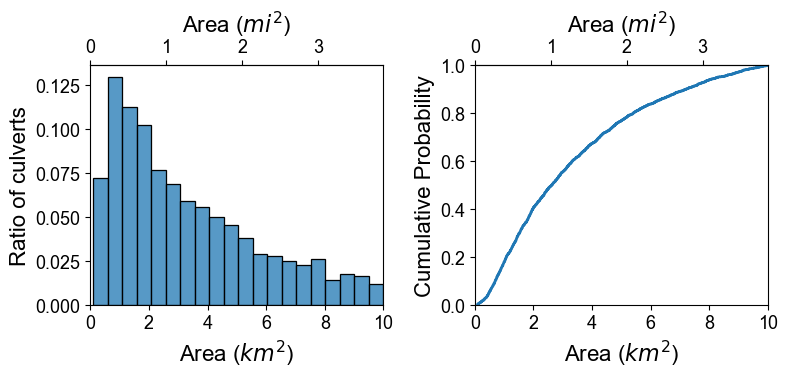

In [30]:
# Conversion factor
km2_to_mi2 = 0.386102

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Histogram (in km²)
sns.histplot(culvert['Area'] / 1e6, stat='probability', kde=False, ax=axes[0])
axes[0].set_xlabel('Area ($km^2$)')
axes[0].set_ylabel('Ratio of culverts')
axes[0].set_xlim(0,10)

# Add secondary x-axis for mi²
def km2_to_miles(x): return x * km2_to_mi2
def miles_to_km2(x): return x / km2_to_mi2
secax0 = axes[0].secondary_xaxis('top', functions=(km2_to_miles, miles_to_km2))
secax0.set_xlabel('Area ($mi^2$)')

# ECDF (in km²)
sns.ecdfplot(culvert['Area'] / 1e6, ax=axes[1], linewidth=2.0)
axes[1].set_xlabel('Area ($km^2$)')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_xlim(0,10)

# Add secondary x-axis for mi²
secax1 = axes[1].secondary_xaxis('top', functions=(km2_to_miles, miles_to_km2))
secax1.set_xlabel('Area ($mi^2$)')

plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\Area_pdf_cdf_km2_mi2.png", dpi=300, bbox_inches='tight')
plt.show()

In [31]:
(culvert['Area'] / 10**6).describe().round(1)

count    2418.0
mean        3.3
std         2.4
min         0.1
25%         1.3
50%         2.6
75%         4.8
max        10.0
Name: Area, dtype: float64

In [26]:
culvert=pd.read_excel(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_LU_Q.xlsx')

# CN calculation

In [32]:
# Find all watersheds shapefiles
# Define the root directory
root_dir = r'D:\culvert repo\Results\waterhsed_delineation_dir'
# Define the pattern to search for shapefiles
pattern = os.path.join(root_dir, '**', '*watershed_poly_*m.shp')
# Use glob to find all matching shapefiles
shapefile_paths = glob.glob(pattern, recursive=True)
# Print the number of shapefiles found
print(f"Found {len(shapefile_paths)} shapefiles.")

Found 29960 shapefiles.


In [33]:
def select_closest_area(row):
    error = str(row['Closest_Area'])
    return error

In [34]:
culvert = culvert.reset_index(drop=True)

## Export the verified watershed boundaries to a shapefile.
### For Berina

In [35]:
from tqdm import tqdm
import os
import numpy as np
import geopandas as gpd
import pandas as pd

# Output shapefile path
out_shp = r"D:\culvert repo\Results\watersheds_merged.shp"

gdfs = []
crs_ref = None

for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='collecting watersheds'):
    error = select_closest_area(row)
    specific_pattern = f"{row['BIN']}watershed_poly_{error}m.shp"

    # Find matching shapefile
    matching_path = next((path for path in shapefile_paths if specific_pattern in os.path.basename(path)), None)

    if matching_path is None:
        # Optional: log missing BINs
        # print(f"No shapefile for BIN {row['BIN']}")
        continue

    # Read watershed shapefile
    gdf_ws = gpd.read_file(matching_path)

    # Keep CRS consistent
    if crs_ref is None:
        crs_ref = gdf_ws.crs
    elif gdf_ws.crs != crs_ref:
        gdf_ws = gdf_ws.to_crs(crs_ref)

    # Attach ALL culvert DataFrame columns to this watershed
    for col in culvert.columns:
        gdf_ws[col] = row[col]

    gdfs.append(gdf_ws)

# Merge everything into one GeoDataFrame
if not gdfs:
    raise RuntimeError("No watershed shapefiles were collected; nothing to write.")

merged = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=crs_ref)

# Save to shapefile
merged.to_file(out_shp, driver="ESRI Shapefile")
print(f"Wrote {len(merged)} watershed polygons to {out_shp}")


collecting watersheds: 100%|██████████| 2418/2418 [03:21<00:00, 12.02it/s]


Wrote 2418 watershed polygons to D:\culvert repo\Results\watersheds_merged.shp


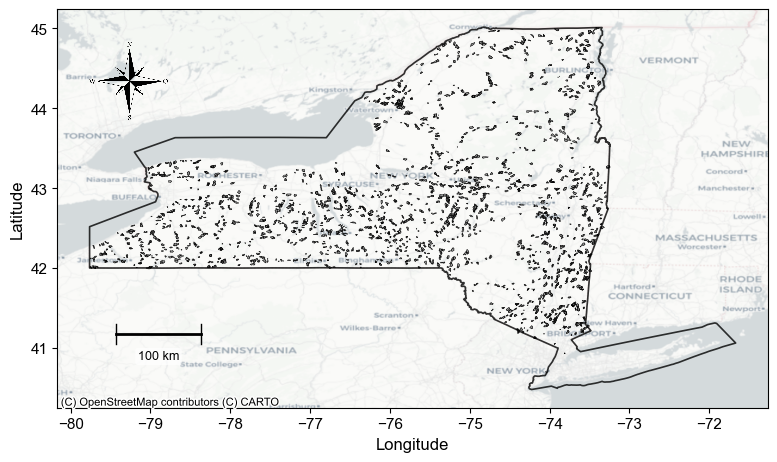

In [ ]:
# plot the saved shapefile


# --- Paths ---
watersheds_path = r"D:\culvert repo\Results\watersheds_merged.shp"
state_path = r"D:\culvert repo\data\initial layers\state_5070.shp"   # optional overlay
north_arrow_path = r"D:\culvert repo\Results\north_arrow\N_arrow.png"
out_png = r"D:\culvert repo\Results\Figures\ws_gdf.png"

# --- CRS ---
crs_deg = "EPSG:4326"
crs_m = "EPSG:5070"

# --- Load data ---
ws_gdf = gpd.read_file(watersheds_path)

# Reproject to WGS84 for plotting/basemap
ws_gdf = ws_gdf.to_crs(crs_deg)

# --- Bounds & meters-per-degree (for scale bar) ---
minx, miny, maxx, maxy = ws_gdf.total_bounds
bbox = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame({"geometry": [bbox]}, crs=crs_deg).to_crs(crs_m)
scale_width_m = bbox_gdf.geometry.iloc[0].bounds[2] - bbox_gdf.geometry.iloc[0].bounds[0]
scale_width_deg = maxx - minx if (maxx - minx) != 0 else 1e-6
meters_per_degree = scale_width_m / scale_width_deg

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 8))

# Watershed polygons
# If the file contains polygons, this draws outlines; fill set to none to see basemap
ws_gdf.plot(ax=ax, facecolor="gray", edgecolor="k", linewidth=0.3, alpha=0.8)

# Optional state boundary overlay
try:
    state_gdf = gpd.read_file(state_path).to_crs(crs_deg)
    state_gdf.plot(ax=ax, edgecolor="black", linewidth=1.2, facecolor="none", alpha=0.8)
except Exception:
    pass  # skip if not available

# Basemap
ctx.add_basemap(ax, crs=ws_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Labels
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.tick_params(axis="both", labelsize=11)
# ax.set_title("Verified Watershed Boundaries", fontsize=14)

# --- Scale Bar ---
bar_length_km = 100  # choose a sensible length
deg_per_km = 1 / (meters_per_degree / 1000)
bar_length_deg = bar_length_km * deg_per_km

# Place near lower-left inside the map extent
x_pad = 0.05 * (maxx - minx)
y_pad = 0.06 * (maxy - miny)
bar_x_start = minx + x_pad
bar_x_end = bar_x_start + bar_length_deg
bar_y = miny + y_pad

ax.plot([bar_x_start, bar_x_end], [bar_y, bar_y], color="black", lw=2)
ax.plot([bar_x_start, bar_x_start], [bar_y - 0.03*(maxy-miny), bar_y + 0.03*(maxy-miny)], color="black", lw=1)
ax.plot([bar_x_end, bar_x_end], [bar_y - 0.03*(maxy-miny), bar_y + 0.03*(maxy-miny)], color="black", lw=1)
ax.text((bar_x_start + bar_x_end) / 2, bar_y - 0.05*(maxy-miny),
        f"{bar_length_km} km", ha="center", va="top",
        fontsize=9, bbox=dict(facecolor="white", alpha=.7, edgecolor="none", boxstyle="round,pad=0.2"))

# --- North Arrow ---
try:
    north_img = mpimg.imread(north_arrow_path)
    imagebox = OffsetImage(north_img, zoom=0.09)
    ab = AnnotationBbox(imagebox, (0.1, 0.82), xycoords="axes fraction", frameon=False)
    ax.add_artist(ab)
except Exception:
    pass  # skip if image not available

# Tight layout, save, show
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()


In [ ]:
ws_gdf

## clip the CN

In [113]:
CN_path = r"D:\culvert repo\Results\CN\CN_Map_2021_filled.tif"
# Define the root directory to search in
# Progress bar
for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
    error=select_closest_area(row)
    ###############################################################################################################################################
    # Find the path to the file 
    # Construct the specific filename pattern
    specific_pattern = f"{row['BIN']}watershed_poly_{error}m.shp"
    # Find the path related to the specific pattern
    matching_path = None
    for path in shapefile_paths:
        if specific_pattern in os.path.basename(path):
            matching_path = path
            break
    if matching_path is None:
        print("No matching shapefile found.")
        culvert.loc[idx, f"CN"] = np.nan
        continue
    ###############################################################################################################################################
    watershed_polygone = matching_path
    watershed = gpd.read_file(watershed_polygone)
    # Convert the watershed boundary to GeoJSON-like format
    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
    ###############################################################################################################################################
    # Open the precipitation TIFF file and clip it using the watershed boundary
    from rasterio.mask import mask
    with rasterio.open(CN_path) as src:
        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
        # Set NoData value
        out_image[out_image == src.nodata] = 0
        # Calculate the mean of the clipped raster, excluding NoData values
        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
            mean_value = np.nan
        else:
            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
    # Update the DataFrame with the mean value for the given error
    culvert.loc[idx, f"CN"] = mean_value

number of processed rows: 100%|██████████| 2418/2418 [02:23<00:00, 16.83it/s]


In [114]:
CN_paths = {
    "dry": r"D:\culvert repo\Results\CN\CN_Map_dry_2021_filled.tif",
    "wet": r"D:\culvert repo\Results\CN\CN_Map_wet_2021_filled.tif"
}
for condition, CN_path in CN_paths.items():
    for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc=f'Processing CN_{condition}'):
        error = select_closest_area(row)
        # Construct the specific filename pattern
        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
        # Find the matching shapefile path
        matching_path = next((path for path in shapefile_paths if specific_pattern in os.path.basename(path)), None)
        if matching_path is None:
            print(f"No matching shapefile found for BIN {culvert['BIN'].iloc[idx]}")
            culvert.loc[idx, f"CN_{condition}"] = np.nan
            continue
        # Read watershed shapefile
        watershed = gpd.read_file(matching_path)
        watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
        # Clip the CN raster using watershed geometry
        with rasterio.open(CN_path) as src:
            out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
            out_image[out_image == src.nodata] = 0
            # Compute the mean CN value
            if np.count_nonzero(out_image) == 0:
                mean_value = np.nan
            else:
                mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
        # Assign result to culvert dataframe
        culvert.loc[idx, f"CN_{condition}"] = mean_value

Processing CN_wet: 100%|██████████| 2418/2418 [02:18<00:00, 17.41it/s]


In [ ]:
culvert[['CN', 'CN_dry', 'CN_wet']].describe().round(1)

CN       CN_dry       CN_wet
count  2202.000000  2202.000000  2202.000000
mean     75.971730    59.386243    87.510853
std       6.715577     7.917053     4.453690
min      44.926398    26.438230    64.379226
25%      72.750317    55.109422    85.612354
50%      76.943099    60.249235    88.319053
75%      80.498628    64.651296    90.528021
max      90.072616    78.852435    95.746865

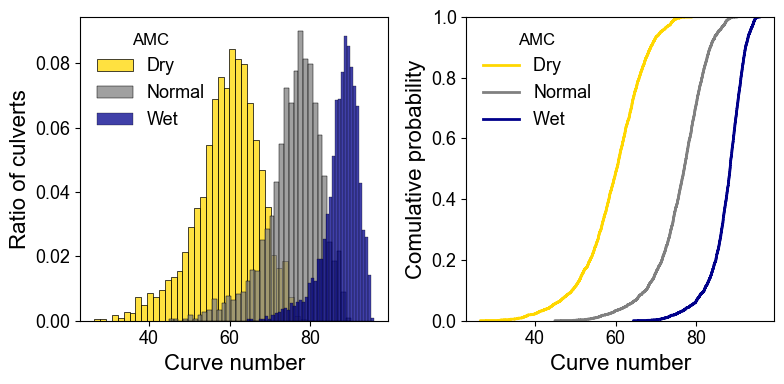

In [407]:
df = culvert[['CN', 'CN_dry', 'CN_wet']]
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# Histogram
sns.histplot(df['CN_dry'],stat='probability', kde=False, ax=axes[0],  label='Dry', color='gold')
sns.histplot(df['CN'],stat='probability', kde=False, ax=axes[0],  label='Normal', color='gray')
sns.histplot(df['CN_wet'],stat='probability', kde=False, ax=axes[0], label='Wet', color='darkblue')
axes[0].legend(title='AMC', frameon=False)
axes[0].set_xlabel('Curve number')
axes[0].set_ylabel('Ratio of culverts')
# ECDF
sns.ecdfplot(df['CN_dry'], ax=axes[1], label='Dry ', color='gold',linewidth=2.0)
sns.ecdfplot(df['CN'], ax=axes[1], label='Normal', color='gray',linewidth=2.0)
sns.ecdfplot(df['CN_wet'], ax=axes[1], label='Wet ', color='darkblue',linewidth=2.0)
axes[1].set_xlabel('Curve number')
axes[1].set_ylabel('Comulative probability')
axes[1].legend(title='AMC', frameon=False)
# show and save
plt.tight_layout()
plt.savefig("D:\culvert repo\Results\Figures\ASM_CN_his_cdf.png",dpi=300,bbox_inches='tight')
plt.show()

#### GEE CN 

In [119]:
# Define the root directory
root_dir = r'D:\culvert repo\Results\waterhsed_delineation_dir'
# Define the pattern to search for shapefiles
pattern = os.path.join(root_dir, '**', '*watershed_poly_*m.shp')
# Use glob to find all matching shapefiles
shapefile_paths = glob.glob(pattern, recursive=True)
# Print the number of shapefiles found
print(f"Found {len(shapefile_paths)} shapefiles.")

Found 29960 shapefiles.


In [120]:
# normal
CN_path = r"D:\culvert repo\data\initial layers\GEE\GCN250_Average_NY_reprojected.tif"
# Define the root directory to search in
# Progress bar
for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
    error=select_closest_area(row)
    ###############################################################################################################################################
    # Find the path to the file 
    # Construct the specific filename pattern
    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
    # Find the path related to the specific pattern
    matching_path = None
    for path in shapefile_paths:
        if specific_pattern in os.path.basename(path):
            matching_path = path
            break
    if matching_path is None:
        print("No matching shapefile found.")
        culvert.loc[idx, f"CN"] = np.nan
        continue
    ###############################################################################################################################################
    watershed_polygone = matching_path
    watershed = gpd.read_file(watershed_polygone)
    # Convert the watershed boundary to GeoJSON-like format
    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
    ###############################################################################################################################################
    # Open the precipitation TIFF file and clip it using the watershed boundary
    with rasterio.open(CN_path) as src:
        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
        # Set NoData value
        out_image[out_image == src.nodata] = 0
        # Calculate the mean of the clipped raster, excluding NoData values
        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
            mean_value = np.nan
        else:
            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
    # Update the DataFrame with the mean value for the given error
    culvert.loc[idx, f"GEE_CN"] = mean_value

number of processed rows: 100%|██████████| 2418/2418 [02:14<00:00, 17.99it/s]


In [121]:
# Wet and dry
CN_paths = {
    "dry": r"D:\culvert repo\data\initial layers\GEE\GCN250_Dry_NY_reprojected.tif",
    "wet": r"D:\culvert repo\data\initial layers\GEE\GCN250_Wet_NY_reprojected.tif"
}
# Define the root directory to search in
# Progress bar
for condition, CN_path in CN_paths.items():
    for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
        error=select_closest_area(row)
        ###############################################################################################################################################
        # Find the path to the file 
        # Construct the specific filename pattern
        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
        # Find the path related to the specific pattern
        matching_path = None
        for path in shapefile_paths:
            if specific_pattern in os.path.basename(path):
                matching_path = path
                break
        if matching_path is None:
            print("No matching shapefile found.")
            culvert.loc[idx, f"CN"] = np.nan
            continue
        ###############################################################################################################################################
        watershed_polygone = matching_path
        watershed = gpd.read_file(watershed_polygone)
        # Convert the watershed boundary to GeoJSON-like format
        watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
        ###############################################################################################################################################
        # Open the precipitation TIFF file and clip it using the watershed boundary
        with rasterio.open(CN_path) as src:
            out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
            # Set NoData value
            out_image[out_image == src.nodata] = 0
            # Calculate the mean of the clipped raster, excluding NoData values
            if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                mean_value = np.nan
            else:
                mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
        # Update the DataFrame with the mean value for the given error
        culvert.loc[idx, f"GEE_CN_{condition}"] = mean_value

number of processed rows: 100%|██████████| 2418/2418 [02:17<00:00, 17.61it/s]


In [35]:
culvert.iloc[0].Bas_S

np.float64(13.68132407169688)

In [5]:
# Calculate the time of the concentration based on different ASM states using NRCS method which is based on CN
culvert[f't_c_CN'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
culvert[f't_c_CN_dry'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN_dry'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
culvert[f't_c_CN_wet'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN_wet'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
culvert[f't_c_GEE_CN'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'GEE_CN'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
culvert[f't_c_GEE_CN_dry'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'GEE_CN_dry'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
culvert[f't_c_GEE_CN_wet'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'GEE_CN_wet'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)

culvert[['CN','GEE_CN',	'CN_dry', 'GEE_CN_dry',	'CN_wet','GEE_CN_wet', 't_c','t_c_CN','t_c_GEE_CN',	't_c_CN_dry','t_c_GEE_CN_dry','t_c_CN_wet','t_c_GEE_CN_wet']].head()

CN     GEE_CN     CN_dry  GEE_CN_dry     CN_wet  GEE_CN_wet  \
0  77.519808  71.750000  60.601441   52.730769  88.865546   85.826923   
1  74.375262  70.023529  56.567086   50.917647  86.932914   84.623529   
2  68.429505  73.550000  50.051354   55.150000  82.789916   87.025000   
3  76.450000  72.000000  58.788095   53.000000  88.459524   86.000000   
4  69.028981  72.052326  50.702707   53.279070  83.089013   86.023256   

        t_c    t_c_CN  t_c_GEE_CN  t_c_CN_dry  t_c_GEE_CN_dry  t_c_CN_wet  \
0  0.290200  0.857872    1.011869    1.356053        1.654224    0.584265   
1  0.334240  1.057055    1.192507    1.688351        1.947202    0.707135   
2  0.199370  0.707368    0.614973    1.131318        0.994457    0.464559   
3  0.162557  0.490290    0.556423    0.786159        0.909738    0.328682   
4  0.425714  1.561300    1.438101    2.495665        2.338128    1.031597   

   t_c_GEE_CN_wet  
0        0.654803  
1        0.768104  
2        0.400528  
3        0.360317  
4        0.931823

#### Comparison of the two methods for tc calculation

In [197]:
culvert[['t_c_CN_wet', 't_c']].describe()

t_c_CN_wet          t_c
count  2418.000000  2418.000000
mean      1.089530     0.457545
std       0.568804     0.225479
min       0.138965     0.073648
25%       0.678876     0.292576
50%       0.973780     0.411564
75%       1.375127     0.575228
max       4.113647     1.643999

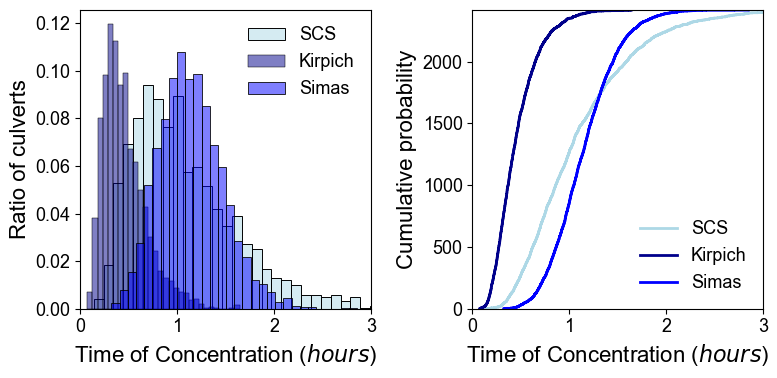

In [198]:
# Create a figure with two subplots
### add  to histplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# ECDF
sns.ecdfplot(culvert[f't_c_CN_wet'], label='SCS',stat='count', linewidth=2, ax=axs[1],color='lightblue')
sns.ecdfplot(culvert['t_c'], label='Kirpich',stat='count', linewidth=2,color='darkblue', ax=axs[1])
sns.ecdfplot(culvert['t_c_simas'], label='Simas',stat='count', linewidth=2,color='blue', ax=axs[1])

axs[0].set_xlabel(f"Time of Concentration ($hours$)")
axs[0].set_ylabel("Ratio of culverts")
axs[0].set_xlim (0,3)
axs[1].legend(frameon=False)
# Histogram
sns.histplot(culvert[f't_c_CN_wet'],stat='probability', kde=False, label='SCS', color='lightblue', ax=axs[0], alpha=0.5)
sns.histplot(culvert['t_c'],stat='probability', label='Kirpich', kde=False, bins=30, color='darkblue', ax=axs[0], alpha=0.5)
sns.histplot(culvert['t_c_simas'],stat='probability', label='Simas', kde=False, bins=30, color='blue', ax=axs[0], alpha=0.5)

axs[0].legend(frameon=False)
axs[1].set_xlabel(f"Time of Concentration ($hours$)")
axs[1].set_xlim (0,3)
axs[1].set_ylabel("Cumulative probability")
# show and save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\kirpich_NRCS_comparison_tc_methods.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
culvert[['t_c_CN_wet', 't_c','t_c_simas']].describe().round(1)

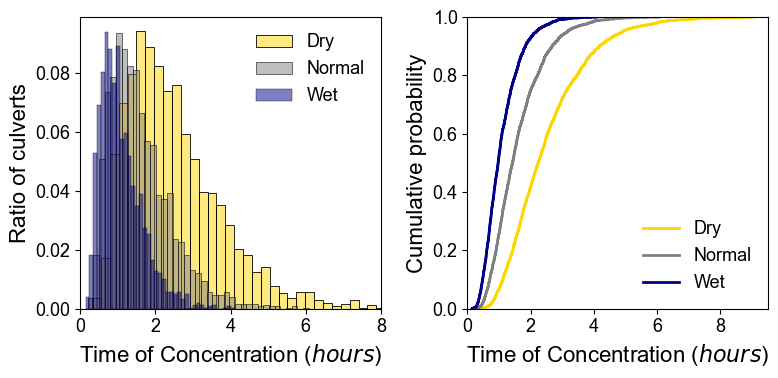

In [55]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# ECDF
sns.ecdfplot(culvert[f't_c_CN_dry'], label=f'Dry', linewidth=2, ax=axs[1], color='gold')
sns.ecdfplot(culvert[f't_c_CN'], label=f'Normal', linewidth=2, ax=axs[1],color='gray')
sns.ecdfplot(culvert[f't_c_CN_wet'], label=f'Wet', linewidth=2, ax=axs[1],color='darkblue')
axs[0].set_xlabel(f"Time of Concentration ($hours$)")
axs[0].set_xlim(0, 8)  # Start x-axis at 0
axs[0].set_ylabel("Ratio of culverts")
axs[1].legend(frameon=False)
# Histogram
sns.histplot(culvert[f't_c_CN_dry'],stat='probability', kde=False, label='Dry', color='gold', ax=axs[0], alpha=0.5)
sns.histplot(culvert[f't_c_CN'],stat='probability', kde=False, label='Normal', color='gray', ax=axs[0], alpha=0.5)
sns.histplot(culvert[f't_c_CN_wet'], stat='probability',kde=False, label='Wet', color='darkblue', ax=axs[0], alpha=0.5)
axs[0].legend(frameon=False)
axs[1].set_xlabel(f"Time of Concentration ($hours$)")
axs[1].set_xlim(0, None)  # Start x-axis at 0

axs[1].set_ylabel("Cumulative probability")
# show and save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\tc_NRCS_ASM.png", dpi=300, bbox_inches='tight')
plt.show()

In [132]:
# Identify all geometry columns
geom_cols = [col for col in culvert.columns if isinstance(culvert[col].dtype, gpd.array.GeometryDtype)]

# Drop the second geometry column (if it exists)
if len(geom_cols) > 1:
    culvert = culvert.drop(columns=geom_cols[1])

In [133]:
# save to .shp
output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc.shp'
culvert.to_file(output_file)
print(f"culvert_CN_tc saved to {output_file}")
# Save to an Excel file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc.shp
culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc.xlsx


In [25]:
culvert = gpd.read_file(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc.xlsx')

#### Calculate the CN based on projected land uses

In [138]:
for scenario in ['A1B']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    error=select_closest_area(row)
                    ###############################################################################################################################################
                    # Find the path to the file 
                    # Construct the specific filename pattern
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster, excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

A1B 2030


number of processed rows: 100%|██████████| 2418/2418 [02:15<00:00, 17.86it/s]


A1B 2040


number of processed rows: 100%|██████████| 2418/2418 [02:10<00:00, 18.51it/s]


A1B 2050


number of processed rows: 100%|██████████| 2418/2418 [02:17<00:00, 17.59it/s]


A1B 2060


number of processed rows: 100%|██████████| 2418/2418 [02:12<00:00, 18.25it/s]


A1B 2070


number of processed rows: 100%|██████████| 2418/2418 [02:11<00:00, 18.40it/s]


A1B 2080


number of processed rows: 100%|██████████| 2418/2418 [02:16<00:00, 17.74it/s]


A1B 2090


number of processed rows: 100%|██████████| 2418/2418 [02:14<00:00, 18.02it/s]


A1B 2100


number of processed rows: 100%|██████████| 2418/2418 [02:15<00:00, 17.85it/s]


In [139]:
# save to an Excel file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_CN_tc.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_CN_tc.xlsx


In [140]:
for scenario in ['A2']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    ###############################################################################################################################################
                    # Find the path to the file 
                    # Construct the specific filename pattern
                    error=select_closest_area(row)
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster, excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

A2 2030


number of processed rows: 100%|██████████| 2418/2418 [02:14<00:00, 17.97it/s]


A2 2040


number of processed rows: 100%|██████████| 2418/2418 [02:14<00:00, 18.04it/s]


A2 2050


number of processed rows: 100%|██████████| 2418/2418 [02:16<00:00, 17.71it/s]


A2 2060


number of processed rows: 100%|██████████| 2418/2418 [02:16<00:00, 17.71it/s]


A2 2070


number of processed rows: 100%|██████████| 2418/2418 [02:20<00:00, 17.21it/s]


A2 2080


number of processed rows: 100%|██████████| 2418/2418 [02:21<00:00, 17.06it/s]


A2 2090


number of processed rows: 100%|██████████| 2418/2418 [02:23<00:00, 16.80it/s]


A2 2100


number of processed rows: 100%|██████████| 2418/2418 [02:16<00:00, 17.71it/s]


In [141]:
# save to an Excel file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_CN_tc.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_CN_tc.xlsx


In [142]:
for scenario in ['B1']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    ###############################################################################################################################################
                    # Find the path to the file 
                    # Construct the specific filename pattern
                    error=select_closest_area(row)
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster, excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

B1 2030


number of processed rows: 100%|██████████| 2418/2418 [02:14<00:00, 17.94it/s]


B1 2040


number of processed rows: 100%|██████████| 2418/2418 [02:12<00:00, 18.26it/s]


B1 2050


number of processed rows: 100%|██████████| 2418/2418 [02:16<00:00, 17.76it/s]


B1 2060


number of processed rows: 100%|██████████| 2418/2418 [02:11<00:00, 18.43it/s]


B1 2070


number of processed rows: 100%|██████████| 2418/2418 [02:14<00:00, 18.01it/s]


B1 2080


number of processed rows: 100%|██████████| 2418/2418 [02:15<00:00, 17.84it/s]


B1 2090


number of processed rows: 100%|██████████| 2418/2418 [02:14<00:00, 18.02it/s]


B1 2100


number of processed rows: 100%|██████████| 2418/2418 [02:14<00:00, 17.97it/s]


In [143]:
# save to an Excel file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_B1_CN_tc.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_B1_CN_tc.xlsx


In [144]:
for scenario in ['B2']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    ###############################################################################################################################################
                    # Find the path to the file 
                    # Construct the specific filename pattern
                    error=select_closest_area(row)
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster, excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

B2 2030


number of processed rows: 100%|██████████| 2418/2418 [02:13<00:00, 18.09it/s]


B2 2040


number of processed rows: 100%|██████████| 2418/2418 [02:12<00:00, 18.21it/s]


B2 2050


number of processed rows: 100%|██████████| 2418/2418 [02:14<00:00, 17.96it/s]


B2 2060


number of processed rows: 100%|██████████| 2418/2418 [02:14<00:00, 17.97it/s]


B2 2070


number of processed rows: 100%|██████████| 2418/2418 [02:15<00:00, 17.83it/s]


B2 2080


number of processed rows: 100%|██████████| 2418/2418 [02:16<00:00, 17.70it/s]


B2 2090


number of processed rows: 100%|██████████| 2418/2418 [02:13<00:00, 18.11it/s]


B2 2100


number of processed rows: 100%|██████████| 2418/2418 [02:14<00:00, 17.98it/s]


In [145]:
# save to an Excel file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_B1_B2_CN_tc.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_B1_B2_CN_tc.xlsx


In [6]:
# Calculate the time of the concentration based on the projected CN value
for scenario in ['A1B', 'A2', 'B1', 'B2']:
    for year in [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]:
        for ASM in ['Wet']:
            culvert[f't_CN_{year}_{scenario}_{ASM}'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*\
            ((1000/culvert[f'CN_{year}_{scenario}_{ASM}'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
# Show the results
# List of columns to display
columns_to_show = [f't_CN_{year}_{scenario}_Wet' 
                   for scenario in ['A1B', 'A2', 'B1', 'B2']
                   for year in [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]]

# Display those columns
culvert[columns_to_show].head()

t_CN_2030_A1B_Wet  t_CN_2040_A1B_Wet  t_CN_2050_A1B_Wet  t_CN_2060_A1B_Wet  \
0           0.677653           0.663494           0.662821           0.655435   
1           0.724492           0.723155           0.728505           0.713368   
2           0.577928           0.568708           0.568708           0.562410   
3           0.350364           0.347389           0.346399           0.347389   
4           1.130288           1.138288           1.130880           1.129992   

   t_CN_2070_A1B_Wet  t_CN_2080_A1B_Wet  t_CN_2090_A1B_Wet  t_CN_2100_A1B_Wet  \
0           0.664839           0.664839           0.652083           0.651413   
1           0.725829           0.731630           0.724938           0.727167   
2           0.565269           0.561269           0.568708           0.555008   
3           0.347389           0.347389           0.350364           0.350364   
4           1.131472           1.111996           1.132360           1.114350   

   t_CN_2030_A2_Wet  t_CN_2040_A2_Wet  ...  t_CN_2090_B1_Wet  \
0          0.649405          0.653423  ...          0.652753   
1          0.708040          0.704936  ...          0.723155   
2          0.551041          0.542019  ...          0.541457   
3          0.361316          0.361316  ...          0.372341   
4          1.148987          1.137398  ...          1.170499   

   t_CN_2100_B1_Wet  t_CN_2030_B2_Wet  t_CN_2040_B2_Wet  t_CN_2050_B2_Wet  \
0          0.662149          0.648735          0.664167          0.662149   
1          0.724492          0.724492          0.733864          0.728059   
2          0.541457          0.577928          0.577928          0.577928   
3          0.363315          0.363315          0.363315          0.366318   
4          1.154649          1.162414          1.137398          1.174699   

   t_CN_2060_B2_Wet  t_CN_2070_B2_Wet  t_CN_2080_B2_Wet  t_CN_2090_B2_Wet  \
0          0.687132          0.674950          0.672925          0.674950   
1          0.720038          0.732077          0.729398          0.748196   
2          0.577928          0.577928          0.577928          0.565842   
3          0.356329          0.342442          0.363315          0.363315   
4          1.169899          1.170499          1.162414          1.173198   

   t_CN_2100_B2_Wet  
0          0.676977  
1          0.741470  
2          0.577928  
3          0.363315  
4          1.173198  

[5 rows x 32 columns]

In [147]:
# save to .xlsx
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_CN_tc.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_CN_tc.xlsx


In [ ]:
#set the plotting parameters
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 18, 'axes.titlesize': 20,
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'legend.fontsize': 16})

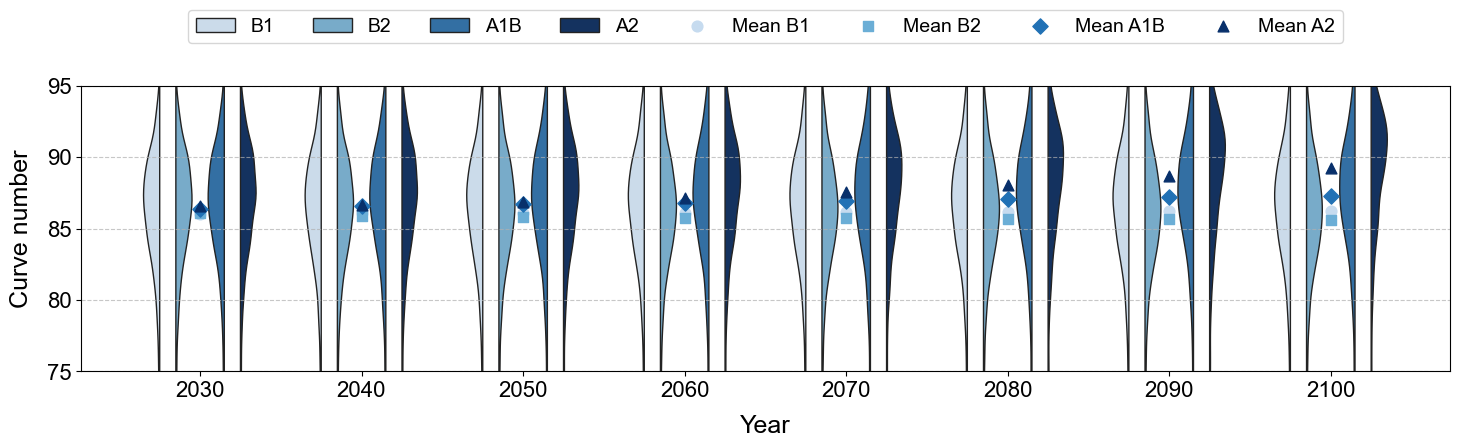

In [483]:
# Define scenarios and years
scenarios = ['B1', 'B2', 'A1B', 'A2']
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]

# Reshape data into long format
data = {'Year': [], 'Scenario': [], 'CN Value': []}
mean_data = {'Year': [], 'Scenario': [], 'Mean CN': []}

for year in years:
    for scenario in scenarios:
        cn_values = culvert[f'CN_{year}_{scenario}_Wet'].dropna()
        for value in cn_values:
            data['Year'].append(year)
            data['Scenario'].append(scenario)
            data['CN Value'].append(value)
        mean_data['Year'].append(year)
        mean_data['Scenario'].append(scenario)
        mean_data['Mean CN'].append(cn_values.mean())

df_violin = pd.DataFrame(data)
df_mean = pd.DataFrame(mean_data)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))

# Define palette and markers
palette = ['#c6dbef', '#6baed6', '#2171b5', '#08306b']
markers = ['o', 's', 'D', '^']

# Violin plot
sns.violinplot(
    data=df_violin,
    x='Year',
    y='CN Value',
    hue='Scenario',
    order=years,
    hue_order=scenarios,
    split=True,
    palette=palette,
    inner=None,
    linewidth=1,
    gap=0.5,
    ax=ax
)

# Overlay mean CN values
for i, scenario in enumerate(scenarios):
    subset = df_mean[df_mean['Scenario'] == scenario]
    x_positions = np.arange(len(years))
    ax.scatter(
        x_positions, subset['Mean CN'], marker=markers[i],
        color=palette[i], label=f'Mean {scenario}', s=60
    )

# Font and axis formatting
ax.set_xticks(np.arange(len(years)))
ax.set_xticklabels(years, fontsize=16)
ax.set_ylim(75, 95)
ax.set_xlabel("Year", fontsize=18, labelpad=10)
ax.set_ylabel("Curve number", fontsize=18, labelpad=10)
ax.tick_params(axis='y', labelsize=16)

# Legend formatting
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.3),
    ncol=len(scenarios) * 2,
    fontsize=14,
    title_fontsize=16
)

# Grid and layout
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save
plt.savefig(r"D:\culvert repo\Results\Figures\CN_distribution_culvert_2030_2100.png", dpi=300)
plt.show()

# compute $S$ and $I_a$

In [149]:
# Calculate average storage for the drainage area for normal, dry, and wet asm
# S=(2540/CN)-25.4
# S storage (cm)
culvert[f'S']=(2540/culvert[f'CN'])-25.4
# Calculation of initial abstraction (Ia=0.2*S) (cm)
culvert[f'Ia']=0.2*culvert[f'S']
# For dry and wet conditions of the current land use
for asm in['dry','wet']:
    culvert[f'S_{asm}']=(2540/culvert[f'CN_{asm}'])-25.4
    # Calculation of initial abstraction (Ia=0.2*S) Ia(cm)
    culvert[f'Ia_{asm}']=0.2*culvert[f'S_{asm}']
# for future land use projections
for scenario in ['A1B','A2','B1','B2']:
    for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
        for ASM in ['Wet']:
            culvert[f'S_{year}_{scenario}_{ASM}']=(2540/culvert[f'CN_{year}_{scenario}_{ASM}'])-25.4
            # Calculation of initial abstraction (Ia=0.2*S) (cm)
            culvert[f'Ia_{year}_{scenario}_{ASM}']=0.2*culvert[f'S_{year}_{scenario}_{ASM}']

In [150]:
# Save the DataFrame to an Excel file
output_file = r'D:\hydrological analysis\data\Peak hydrologic discharge\culvert_CN_tc_S_Ia.xlsx'
culvert.to_excel(output_file, index=False)
print(f"culvert_CN_tc_S_Ia saved to {output_file}")

culvert_CN_tc_S_Ia saved to D:\hydrological analysis\data\Peak hydrologic discharge\culvert_CN_tc_S_Ia.xlsx


#### Compute historical average precipitation depth for different return periods and duration for each culvert's basin 

In [152]:
# Extract percipitation data
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h']
bounds = ['a']
# Create an overall progress bar
total_iterations = len(return_periods) * len(durations) * len(bounds) * culvert.shape[0]
with tqdm(total=total_iterations, desc="Processing All Combinations") as pbar:
    # Iterate over return periods, durations, and bounds
    for return_period in return_periods:
        for duration in durations:
            for bound in bounds:
                print (f'extract rainfall values for return period of {return_period} (years), duration of {duration} (minutes),\
                and uncertainty bound of {bound}')
                folder = f'ne{return_period}yr{duration}{bound}_ams'
                file = f'ne{return_period}yr{duration}{bound}_ams.asc'
                asc_file = rf"D:\culvert repo\data\NOAA IDF\{folder}\{file}"
                # Open the ASCII raster file
                with rasterio.open(asc_file) as src:
                    # Iterate over culverts
                    for idx, row in culvert.iterrows():
                        error = select_closest_area(row)
                        # Find the path to the shapefile
                        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                        matching_path = next((path for path in shapefile_paths if specific_pattern in os.path.basename(path)), None)
                        if matching_path is None:
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = np.nan
                        else:
                            # Read the watershed shapefile
                            watershed = gpd.read_file(matching_path)
                            if watershed.crs != src.crs:
                                watershed = watershed.to_crs(src.crs)
                            watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                            # Clip raster using the watershed boundary
                            out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                            out_image[out_image == src.nodata] = 0  # Set NoData values to zero
                            # Compute the mean rainfall depth
                            mean_value = np.nan if np.count_nonzero(out_image) == 0 else np.nanmean(np.where(out_image == 0, np.nan, out_image))
                            # Store the result in the DataFrame
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = (mean_value / 1000) * 2.54  # Convert to centimeters
                        # Update progress bar
                        pbar.update(1)

Processing All Combinations:   0%|          | 1/217620 [00:00<11:40:32,  5.18it/s]

extract rainfall values for return period of 2 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:   1%|          | 2419/217620 [02:11<6:07:14,  9.77it/s]

extract rainfall values for return period of 2 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:   2%|▏         | 4835/217620 [04:20<5:11:20, 11.39it/s]

extract rainfall values for return period of 2 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:   3%|▎         | 7254/217620 [06:32<4:44:04, 12.34it/s] 

extract rainfall values for return period of 2 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:   4%|▍         | 9672/217620 [08:43<5:16:14, 10.96it/s]

extract rainfall values for return period of 2 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:   6%|▌         | 12089/217620 [10:56<4:57:20, 11.52it/s]

extract rainfall values for return period of 2 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:   7%|▋         | 14507/217620 [13:08<4:38:55, 12.14it/s]

extract rainfall values for return period of 2 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:   8%|▊         | 16926/217620 [15:20<4:47:02, 11.65it/s]

extract rainfall values for return period of 2 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:   9%|▉         | 19344/217620 [17:30<4:29:57, 12.24it/s]

extract rainfall values for return period of 2 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  10%|█         | 21763/217620 [19:40<5:25:22, 10.03it/s]

extract rainfall values for return period of 2 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  11%|█         | 24180/217620 [21:51<4:35:11, 11.72it/s]

extract rainfall values for return period of 5 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  12%|█▏        | 26597/217620 [24:04<4:47:20, 11.08it/s]

extract rainfall values for return period of 5 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  13%|█▎        | 29015/217620 [26:19<4:32:23, 11.54it/s]

extract rainfall values for return period of 5 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  14%|█▍        | 31434/217620 [28:31<4:29:16, 11.52it/s]

extract rainfall values for return period of 5 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  16%|█▌        | 33854/217620 [30:44<4:28:45, 11.40it/s]

extract rainfall values for return period of 5 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  17%|█▋        | 36269/217620 [32:53<4:33:10, 11.06it/s]

extract rainfall values for return period of 5 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  18%|█▊        | 38689/217620 [35:08<5:17:43,  9.39it/s]

extract rainfall values for return period of 5 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  19%|█▉        | 41105/217620 [37:22<4:11:28, 11.70it/s]

extract rainfall values for return period of 5 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  20%|█▉        | 43523/217620 [39:34<4:17:40, 11.26it/s]

extract rainfall values for return period of 5 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  21%|██        | 45942/217620 [41:51<4:16:48, 11.14it/s]

extract rainfall values for return period of 5 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  22%|██▏       | 48359/217620 [44:01<3:53:07, 12.10it/s]

extract rainfall values for return period of 10 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  23%|██▎       | 50778/217620 [46:12<4:47:57,  9.66it/s]

extract rainfall values for return period of 10 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  24%|██▍       | 53196/217620 [48:28<4:00:11, 11.41it/s]

extract rainfall values for return period of 10 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  26%|██▌       | 55614/217620 [50:37<3:40:56, 12.22it/s]

extract rainfall values for return period of 10 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  27%|██▋       | 58034/217620 [52:45<4:03:13, 10.94it/s]

extract rainfall values for return period of 10 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  28%|██▊       | 60450/217620 [54:58<3:37:17, 12.06it/s]

extract rainfall values for return period of 10 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  29%|██▉       | 62868/217620 [57:06<3:38:24, 11.81it/s]

extract rainfall values for return period of 10 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  30%|███       | 65286/217620 [59:12<3:32:14, 11.96it/s]

extract rainfall values for return period of 10 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  31%|███       | 67704/217620 [1:01:20<3:25:08, 12.18it/s]

extract rainfall values for return period of 10 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  32%|███▏      | 70122/217620 [1:03:27<3:22:06, 12.16it/s]

extract rainfall values for return period of 10 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  33%|███▎      | 72540/217620 [1:05:35<3:27:17, 11.66it/s]

extract rainfall values for return period of 25 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  34%|███▍      | 74957/217620 [1:07:43<3:17:29, 12.04it/s]

extract rainfall values for return period of 25 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  36%|███▌      | 77376/217620 [1:09:50<3:16:31, 11.89it/s]

extract rainfall values for return period of 25 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  37%|███▋      | 79794/217620 [1:11:58<3:11:12, 12.01it/s]

extract rainfall values for return period of 25 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  38%|███▊      | 82212/217620 [1:14:06<3:10:20, 11.86it/s]

extract rainfall values for return period of 25 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  39%|███▉      | 84629/217620 [1:16:14<3:11:45, 11.56it/s]

extract rainfall values for return period of 25 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  40%|████      | 87048/217620 [1:18:24<3:09:21, 11.49it/s] 

extract rainfall values for return period of 25 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  41%|████      | 89465/217620 [1:20:37<3:06:52, 11.43it/s]

extract rainfall values for return period of 25 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  42%|████▏     | 91884/217620 [1:22:51<3:03:40, 11.41it/s]

extract rainfall values for return period of 25 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  43%|████▎     | 94302/217620 [1:25:09<3:06:36, 11.01it/s]

extract rainfall values for return period of 25 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  44%|████▍     | 96719/217620 [1:27:20<3:10:58, 10.55it/s]

extract rainfall values for return period of 50 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  46%|████▌     | 99137/217620 [1:29:35<2:46:30, 11.86it/s]

extract rainfall values for return period of 50 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  47%|████▋     | 101555/217620 [1:31:43<2:38:59, 12.17it/s]

extract rainfall values for return period of 50 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  48%|████▊     | 103974/217620 [1:33:54<2:42:10, 11.68it/s]

extract rainfall values for return period of 50 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  49%|████▉     | 106392/217620 [1:36:18<3:51:23,  8.01it/s]

extract rainfall values for return period of 50 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  50%|█████     | 108810/217620 [1:39:24<3:40:32,  8.22it/s]

extract rainfall values for return period of 50 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  51%|█████     | 111228/217620 [1:42:30<3:32:36,  8.34it/s]

extract rainfall values for return period of 50 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  52%|█████▏    | 113646/217620 [1:45:37<3:34:25,  8.08it/s]

extract rainfall values for return period of 50 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  53%|█████▎    | 116064/217620 [1:48:41<3:25:50,  8.22it/s]

extract rainfall values for return period of 50 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  54%|█████▍    | 118483/217620 [1:51:35<2:50:32,  9.69it/s]

extract rainfall values for return period of 50 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  56%|█████▌    | 120900/217620 [1:53:48<2:30:31, 10.71it/s]

extract rainfall values for return period of 100 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  57%|█████▋    | 123318/217620 [1:56:09<2:29:04, 10.54it/s]

extract rainfall values for return period of 100 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  58%|█████▊    | 125736/217620 [1:58:21<2:22:25, 10.75it/s]

extract rainfall values for return period of 100 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  59%|█████▉    | 128154/217620 [2:00:34<2:08:34, 11.60it/s]

extract rainfall values for return period of 100 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  60%|██████    | 130573/217620 [2:02:50<2:32:17,  9.53it/s]

extract rainfall values for return period of 100 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  61%|██████    | 132990/217620 [2:05:08<2:06:36, 11.14it/s]

extract rainfall values for return period of 100 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  62%|██████▏   | 135407/217620 [2:07:25<1:57:07, 11.70it/s]

extract rainfall values for return period of 100 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  63%|██████▎   | 137825/217620 [2:09:37<1:51:33, 11.92it/s]

extract rainfall values for return period of 100 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  64%|██████▍   | 140243/217620 [2:11:45<1:52:45, 11.44it/s]

extract rainfall values for return period of 100 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  66%|██████▌   | 142661/217620 [2:14:06<1:49:04, 11.45it/s]

extract rainfall values for return period of 100 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  67%|██████▋   | 145079/217620 [2:16:33<1:48:38, 11.13it/s]

extract rainfall values for return period of 200 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  68%|██████▊   | 147498/217620 [2:18:51<1:41:15, 11.54it/s]

extract rainfall values for return period of 200 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  69%|██████▉   | 149916/217620 [2:21:04<1:39:33, 11.33it/s]

extract rainfall values for return period of 200 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  70%|███████   | 152334/217620 [2:23:16<1:36:41, 11.25it/s]

extract rainfall values for return period of 200 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  71%|███████   | 154751/217620 [2:25:26<1:29:53, 11.66it/s]

extract rainfall values for return period of 200 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  72%|███████▏  | 157170/217620 [2:27:32<1:25:52, 11.73it/s]

extract rainfall values for return period of 200 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  73%|███████▎  | 159588/217620 [2:29:39<1:20:33, 12.01it/s]

extract rainfall values for return period of 200 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  74%|███████▍  | 162005/217620 [2:31:45<1:16:34, 12.10it/s]

extract rainfall values for return period of 200 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  76%|███████▌  | 164424/217620 [2:33:51<1:12:03, 12.30it/s]

extract rainfall values for return period of 200 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  77%|███████▋  | 166842/217620 [2:35:56<1:11:45, 11.79it/s]

extract rainfall values for return period of 200 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  78%|███████▊  | 169260/217620 [2:38:02<1:08:01, 11.85it/s]

extract rainfall values for return period of 500 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  79%|███████▉  | 171678/217620 [2:40:11<1:22:08,  9.32it/s]

extract rainfall values for return period of 500 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  80%|███████▉  | 174095/217620 [2:42:22<59:26, 12.21it/s]  

extract rainfall values for return period of 500 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  81%|████████  | 176515/217620 [2:44:30<1:10:42,  9.69it/s]

extract rainfall values for return period of 500 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  82%|████████▏ | 178932/217620 [2:46:45<57:43, 11.17it/s]  

extract rainfall values for return period of 500 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  83%|████████▎ | 181350/217620 [2:49:01<53:42, 11.26it/s]  

extract rainfall values for return period of 500 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  84%|████████▍ | 183768/217620 [2:51:12<48:23, 11.66it/s]  

extract rainfall values for return period of 500 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  86%|████████▌ | 186186/217620 [2:53:25<46:04, 11.37it/s]

extract rainfall values for return period of 500 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  87%|████████▋ | 188603/217620 [2:55:40<42:26, 11.39it/s]

extract rainfall values for return period of 500 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  88%|████████▊ | 191022/217620 [2:57:58<39:10, 11.32it/s]  

extract rainfall values for return period of 500 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  89%|████████▉ | 193440/217620 [3:00:15<36:38, 11.00it/s]

extract rainfall values for return period of 1000 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  90%|█████████ | 195858/217620 [3:02:25<33:16, 10.90it/s]

extract rainfall values for return period of 1000 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  91%|█████████ | 198275/217620 [3:04:43<30:49, 10.46it/s]

extract rainfall values for return period of 1000 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  92%|█████████▏| 200694/217620 [3:07:02<29:00,  9.73it/s]

extract rainfall values for return period of 1000 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  93%|█████████▎| 203112/217620 [3:09:46<30:43,  7.87it/s]

extract rainfall values for return period of 1000 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  94%|█████████▍| 205530/217620 [3:13:10<25:33,  7.89it/s]

extract rainfall values for return period of 1000 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  96%|█████████▌| 207948/217620 [3:16:24<20:37,  7.82it/s]

extract rainfall values for return period of 1000 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  97%|█████████▋| 210366/217620 [3:19:39<15:16,  7.91it/s]

extract rainfall values for return period of 1000 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  98%|█████████▊| 212784/217620 [3:22:54<10:05,  7.99it/s]

extract rainfall values for return period of 1000 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  99%|█████████▉| 215202/217620 [3:26:10<05:14,  7.69it/s]

extract rainfall values for return period of 1000 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations: 100%|██████████| 217620/217620 [3:29:29<00:00, 17.31it/s]


In [153]:
# save to.xlsx
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain_a.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain_a.xlsx


In [154]:
# Extract percipitation data
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h']
bounds = ['al']
# Create an overall progress bar
total_iterations = len(return_periods) * len(durations) * len(bounds) * culvert.shape[0]
with tqdm(total=total_iterations, desc="Processing All Combinations") as pbar:
    # Iterate over return periods, durations, and bounds
    for return_period in return_periods:
        for duration in durations:
            for bound in bounds:
                print (f'extract rainfall values for return period of {return_period} (years), duration of {duration} (minutes),\
                and uncertainty bound of {bound}')
                folder = f'ne{return_period}yr{duration}{bound}_ams'
                file = f'ne{return_period}yr{duration}{bound}_ams.asc'
                asc_file = rf"D:\culvert repo\data\NOAA IDF\{folder}\{file}"
                # Open the ASCII raster file
                with rasterio.open(asc_file) as src:
                    # Iterate over culverts
                    for idx, row in culvert.iterrows():
                        error = select_closest_area(row)
                        # Find the path to the shapefile
                        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                        matching_path = next((path for path in shapefile_paths if specific_pattern in os.path.basename(path)), None)
                        if matching_path is None:
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = np.nan
                        else:
                            # Read the watershed shapefile
                            watershed = gpd.read_file(matching_path)
                            if watershed.crs != src.crs:
                                watershed = watershed.to_crs(src.crs)
                            watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                            # Clip raster using the watershed boundary
                            out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                            out_image[out_image == src.nodata] = 0  # Set NoData values to zero
                            # Compute the mean rainfall depth
                            mean_value = np.nan if np.count_nonzero(out_image) == 0 else np.nanmean(np.where(out_image == 0, np.nan, out_image))
                            # Store the result in the DataFrame
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = (mean_value / 1000) * 2.54  # Convert to centimeters
                        # Update progress bar
                        pbar.update(1)

Processing All Combinations:   0%|          | 0/217620 [00:00<?, ?it/s]

extract rainfall values for return period of 2 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:   1%|          | 2418/217620 [03:20<7:41:11,  7.78it/s]

extract rainfall values for return period of 2 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:   2%|▏         | 4836/217620 [06:45<7:40:27,  7.70it/s] 

extract rainfall values for return period of 2 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:   3%|▎         | 7254/217620 [10:10<8:16:10,  7.07it/s] 

extract rainfall values for return period of 2 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:   4%|▍         | 9672/217620 [13:31<7:22:06,  7.84it/s] 

extract rainfall values for return period of 2 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:   6%|▌         | 12090/217620 [16:46<7:39:35,  7.45it/s]

extract rainfall values for return period of 2 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:   7%|▋         | 14508/217620 [20:05<7:21:56,  7.66it/s] 

extract rainfall values for return period of 2 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:   8%|▊         | 16926/217620 [23:21<7:00:29,  7.95it/s]

extract rainfall values for return period of 2 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:   9%|▉         | 19344/217620 [26:36<6:59:58,  7.87it/s]

extract rainfall values for return period of 2 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  10%|█         | 21762/217620 [29:52<6:57:51,  7.81it/s] 

extract rainfall values for return period of 2 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  11%|█         | 24180/217620 [33:09<6:50:15,  7.86it/s] 

extract rainfall values for return period of 5 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  12%|█▏        | 26598/217620 [36:24<7:02:44,  7.53it/s] 

extract rainfall values for return period of 5 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  13%|█▎        | 29016/217620 [39:39<6:46:56,  7.72it/s]

extract rainfall values for return period of 5 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  14%|█▍        | 31434/217620 [42:59<6:38:34,  7.79it/s]

extract rainfall values for return period of 5 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  16%|█▌        | 33852/217620 [46:24<6:24:23,  7.97it/s]

extract rainfall values for return period of 5 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  17%|█▋        | 36270/217620 [49:47<6:19:18,  7.97it/s] 

extract rainfall values for return period of 5 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  18%|█▊        | 38688/217620 [53:08<6:27:52,  7.69it/s]

extract rainfall values for return period of 5 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  19%|█▉        | 41106/217620 [56:29<6:29:56,  7.54it/s]

extract rainfall values for return period of 5 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  20%|█▉        | 43523/217620 [59:35<4:25:09, 10.94it/s]

extract rainfall values for return period of 5 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  21%|██        | 45941/217620 [1:01:48<4:04:03, 11.72it/s]

extract rainfall values for return period of 5 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  22%|██▏       | 48360/217620 [1:04:00<3:57:42, 11.87it/s] 

extract rainfall values for return period of 10 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  23%|██▎       | 50777/217620 [1:06:14<4:08:27, 11.19it/s] 

extract rainfall values for return period of 10 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  24%|██▍       | 53196/217620 [1:08:31<4:32:47, 10.05it/s]

extract rainfall values for return period of 10 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  26%|██▌       | 55614/217620 [1:10:54<6:46:06,  6.65it/s]

extract rainfall values for return period of 10 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  27%|██▋       | 58031/217620 [1:14:10<3:50:10, 11.56it/s] 

extract rainfall values for return period of 10 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  28%|██▊       | 60451/217620 [1:16:29<4:32:21,  9.62it/s]

extract rainfall values for return period of 10 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  29%|██▉       | 62870/217620 [1:18:41<3:56:39, 10.90it/s]

extract rainfall values for return period of 10 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  30%|███       | 65286/217620 [1:20:51<3:32:55, 11.92it/s]

extract rainfall values for return period of 10 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  31%|███       | 67704/217620 [1:23:09<5:22:19,  7.75it/s]

extract rainfall values for return period of 10 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  32%|███▏      | 70122/217620 [1:26:21<5:02:30,  8.13it/s]

extract rainfall values for return period of 10 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  33%|███▎      | 72540/217620 [1:29:32<5:01:01,  8.03it/s]

extract rainfall values for return period of 25 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  34%|███▍      | 74957/217620 [1:31:47<3:17:33, 12.04it/s]

extract rainfall values for return period of 25 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  36%|███▌      | 77377/217620 [1:34:06<3:58:19,  9.81it/s]

extract rainfall values for return period of 25 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  37%|███▋      | 79793/217620 [1:36:19<3:20:18, 11.47it/s]

extract rainfall values for return period of 25 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  38%|███▊      | 82213/217620 [1:38:31<3:50:43,  9.78it/s]

extract rainfall values for return period of 25 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  39%|███▉      | 84629/217620 [1:40:43<3:11:14, 11.59it/s]

extract rainfall values for return period of 25 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  40%|████      | 87048/217620 [1:42:56<3:08:40, 11.53it/s]

extract rainfall values for return period of 25 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  41%|████      | 89466/217620 [1:45:09<3:09:41, 11.26it/s]

extract rainfall values for return period of 25 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  42%|████▏     | 91883/217620 [1:47:25<3:05:57, 11.27it/s]

extract rainfall values for return period of 25 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  43%|████▎     | 94301/217620 [1:49:43<2:53:38, 11.84it/s]

extract rainfall values for return period of 25 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  44%|████▍     | 96721/217620 [1:51:55<3:26:53,  9.74it/s]

extract rainfall values for return period of 50 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  46%|████▌     | 99138/217620 [1:54:07<2:49:19, 11.66it/s]

extract rainfall values for return period of 50 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  47%|████▋     | 101556/217620 [1:56:18<2:46:59, 11.58it/s]

extract rainfall values for return period of 50 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  48%|████▊     | 103974/217620 [1:58:30<2:40:30, 11.80it/s]

extract rainfall values for return period of 50 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  49%|████▉     | 106393/217620 [2:00:43<3:10:10,  9.75it/s]

extract rainfall values for return period of 50 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  50%|████▉     | 108809/217620 [2:02:53<2:36:30, 11.59it/s]

extract rainfall values for return period of 50 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  51%|█████     | 111227/217620 [2:05:04<2:33:03, 11.59it/s]

extract rainfall values for return period of 50 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  52%|█████▏    | 113646/217620 [2:07:15<2:25:19, 11.92it/s]

extract rainfall values for return period of 50 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  53%|█████▎    | 116064/217620 [2:09:26<2:29:15, 11.34it/s]

extract rainfall values for return period of 50 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  54%|█████▍    | 118483/217620 [2:11:37<3:02:47,  9.04it/s]

extract rainfall values for return period of 50 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  56%|█████▌    | 120900/217620 [2:13:48<2:18:02, 11.68it/s]

extract rainfall values for return period of 100 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  57%|█████▋    | 123317/217620 [2:15:57<2:15:38, 11.59it/s]

extract rainfall values for return period of 100 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  58%|█████▊    | 125735/217620 [2:18:09<2:12:26, 11.56it/s]

extract rainfall values for return period of 100 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  59%|█████▉    | 128154/217620 [2:20:20<2:09:27, 11.52it/s]

extract rainfall values for return period of 100 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  60%|█████▉    | 130571/217620 [2:22:29<2:01:44, 11.92it/s]

extract rainfall values for return period of 100 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  61%|██████    | 132990/217620 [2:24:41<2:05:11, 11.27it/s]

extract rainfall values for return period of 100 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  62%|██████▏   | 135408/217620 [2:26:51<1:55:38, 11.85it/s]

extract rainfall values for return period of 100 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  63%|██████▎   | 137826/217620 [2:29:01<1:53:35, 11.71it/s]

extract rainfall values for return period of 100 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  64%|██████▍   | 140244/217620 [2:31:13<1:56:33, 11.06it/s]

extract rainfall values for return period of 100 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  66%|██████▌   | 142661/217620 [2:33:23<1:48:09, 11.55it/s]

extract rainfall values for return period of 100 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  67%|██████▋   | 145079/217620 [2:35:33<1:45:46, 11.43it/s]

extract rainfall values for return period of 200 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  68%|██████▊   | 147499/217620 [2:37:44<2:01:42,  9.60it/s]

extract rainfall values for return period of 200 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  69%|██████▉   | 149915/217620 [2:39:54<1:40:32, 11.22it/s]

extract rainfall values for return period of 200 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  70%|██████▉   | 152333/217620 [2:42:08<1:38:50, 11.01it/s]

extract rainfall values for return period of 200 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  71%|███████   | 154751/217620 [2:44:21<1:31:42, 11.43it/s]

extract rainfall values for return period of 200 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  72%|███████▏  | 157170/217620 [2:46:33<1:27:54, 11.46it/s]

extract rainfall values for return period of 200 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  73%|███████▎  | 159588/217620 [2:48:46<1:24:18, 11.47it/s]

extract rainfall values for return period of 200 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  74%|███████▍  | 162006/217620 [2:50:56<1:18:10, 11.86it/s]

extract rainfall values for return period of 200 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  76%|███████▌  | 164425/217620 [2:53:06<1:33:59,  9.43it/s]

extract rainfall values for return period of 200 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  77%|███████▋  | 166841/217620 [2:55:18<1:12:03, 11.75it/s]

extract rainfall values for return period of 200 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  78%|███████▊  | 169259/217620 [2:57:29<1:07:57, 11.86it/s]

extract rainfall values for return period of 500 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  79%|███████▉  | 171677/217620 [2:59:40<1:08:09, 11.23it/s]

extract rainfall values for return period of 500 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  80%|████████  | 174096/217620 [3:01:51<1:03:14, 11.47it/s]

extract rainfall values for return period of 500 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  81%|████████  | 176513/217620 [3:04:01<57:48, 11.85it/s]  

extract rainfall values for return period of 500 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  82%|████████▏ | 178932/217620 [3:06:12<55:09, 11.69it/s]  

extract rainfall values for return period of 500 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  83%|████████▎ | 181349/217620 [3:08:22<51:28, 11.74it/s]  

extract rainfall values for return period of 500 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  84%|████████▍ | 183767/217620 [3:10:31<47:50, 11.79it/s]  

extract rainfall values for return period of 500 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  86%|████████▌ | 186185/217620 [3:12:44<45:15, 11.58it/s]  

extract rainfall values for return period of 500 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  87%|████████▋ | 188603/217620 [3:14:55<41:26, 11.67it/s]  

extract rainfall values for return period of 500 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  88%|████████▊ | 191022/217620 [3:17:05<37:02, 11.97it/s]  

extract rainfall values for return period of 500 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  89%|████████▉ | 193439/217620 [3:19:17<33:43, 11.95it/s]

extract rainfall values for return period of 1000 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  90%|████████▉ | 195857/217620 [3:21:27<31:02, 11.68it/s]

extract rainfall values for return period of 1000 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  91%|█████████ | 198276/217620 [3:23:37<27:23, 11.77it/s]  

extract rainfall values for return period of 1000 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  92%|█████████▏| 200695/217620 [3:25:47<28:37,  9.85it/s]

extract rainfall values for return period of 1000 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  93%|█████████▎| 203112/217620 [3:27:57<20:26, 11.83it/s]

extract rainfall values for return period of 1000 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  94%|█████████▍| 205530/217620 [3:30:08<17:11, 11.72it/s]

extract rainfall values for return period of 1000 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  96%|█████████▌| 207948/217620 [3:32:18<13:33, 11.89it/s]

extract rainfall values for return period of 1000 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  97%|█████████▋| 210365/217620 [3:34:27<10:31, 11.49it/s]

extract rainfall values for return period of 1000 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  98%|█████████▊| 212783/217620 [3:36:38<06:49, 11.82it/s]

extract rainfall values for return period of 1000 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  99%|█████████▉| 215201/217620 [3:38:48<03:26, 11.72it/s]

extract rainfall values for return period of 1000 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations: 100%|██████████| 217620/217620 [3:40:58<00:00, 16.41it/s]


In [155]:
# save to.xlsx
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain_a_al.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain_a_al.xlsx


In [156]:
# Extract percipitation data
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h']
bounds = ['au']
# Create an overall progress bar
total_iterations = len(return_periods) * len(durations) * len(bounds) * culvert.shape[0]
with tqdm(total=total_iterations, desc="Processing All Combinations") as pbar:
    # Iterate over return periods, durations, and bounds
    for return_period in return_periods:
        for duration in durations:
            for bound in bounds:
                print (f'extract rainfall values for return period of {return_period} (years), duration of {duration} (minutes),\
                and uncertainty bound of {bound}')
                folder = f'ne{return_period}yr{duration}{bound}_ams'
                file = f'ne{return_period}yr{duration}{bound}_ams.asc'
                asc_file = rf"D:\culvert repo\data\NOAA IDF\{folder}\{file}"
                # Open the ASCII raster file
                with rasterio.open(asc_file) as src:
                    # Iterate over culverts
                    for idx, row in culvert.iterrows():
                        error = select_closest_area(row)
                        # Find the path to the shapefile
                        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                        matching_path = next((path for path in shapefile_paths if specific_pattern in os.path.basename(path)), None)
                        if matching_path is None:
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = np.nan
                        else:
                            # Read the watershed shapefile
                            watershed = gpd.read_file(matching_path)
                            if watershed.crs != src.crs:
                                watershed = watershed.to_crs(src.crs)
                            watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                            # Clip raster using the watershed boundary
                            out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                            out_image[out_image == src.nodata] = 0  # Set NoData values to zero
                            # Compute the mean rainfall depth
                            mean_value = np.nan if np.count_nonzero(out_image) == 0 else np.nanmean(np.where(out_image == 0, np.nan, out_image))
                            # Store the result in the DataFrame
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = (mean_value / 1000) * 2.54  # Convert to centimeters
                        # Update progress bar
                        pbar.update(1)

Processing All Combinations:   0%|          | 0/217620 [00:00<?, ?it/s]

extract rainfall values for return period of 2 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:   1%|          | 2418/217620 [02:13<5:11:04, 11.53it/s]

extract rainfall values for return period of 2 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:   2%|▏         | 4836/217620 [04:25<5:06:18, 11.58it/s]

extract rainfall values for return period of 2 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:   3%|▎         | 7254/217620 [06:38<5:16:46, 11.07it/s] 

extract rainfall values for return period of 2 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:   4%|▍         | 9671/217620 [08:51<4:52:12, 11.86it/s]

extract rainfall values for return period of 2 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:   6%|▌         | 12090/217620 [11:02<4:52:07, 11.73it/s]

extract rainfall values for return period of 2 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:   7%|▋         | 14507/217620 [13:14<4:55:26, 11.46it/s]

extract rainfall values for return period of 2 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:   8%|▊         | 16925/217620 [15:27<4:50:55, 11.50it/s]

extract rainfall values for return period of 2 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:   9%|▉         | 19343/217620 [17:39<4:48:07, 11.47it/s]

extract rainfall values for return period of 2 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  10%|█         | 21762/217620 [19:56<4:35:05, 11.87it/s]

extract rainfall values for return period of 2 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  11%|█         | 24179/217620 [22:07<4:31:03, 11.89it/s]

extract rainfall values for return period of 5 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  12%|█▏        | 26598/217620 [24:18<4:36:46, 11.50it/s]

extract rainfall values for return period of 5 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  13%|█▎        | 29016/217620 [26:31<4:35:53, 11.39it/s] 

extract rainfall values for return period of 5 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  14%|█▍        | 31433/217620 [28:44<4:49:16, 10.73it/s] 

extract rainfall values for return period of 5 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  16%|█▌        | 33852/217620 [30:58<4:42:36, 10.84it/s]

extract rainfall values for return period of 5 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  17%|█▋        | 36269/217620 [33:10<4:32:16, 11.10it/s]

extract rainfall values for return period of 5 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  18%|█▊        | 38689/217620 [35:21<5:07:15,  9.71it/s]

extract rainfall values for return period of 5 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  19%|█▉        | 41106/217620 [37:35<4:13:03, 11.63it/s]

extract rainfall values for return period of 5 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  20%|█▉        | 43523/217620 [39:46<4:34:28, 10.57it/s]

extract rainfall values for return period of 5 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  21%|██        | 45941/217620 [41:57<4:23:42, 10.85it/s]

extract rainfall values for return period of 5 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  22%|██▏       | 48360/217620 [44:12<4:08:57, 11.33it/s] 

extract rainfall values for return period of 10 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  23%|██▎       | 50777/217620 [46:23<3:59:54, 11.59it/s]

extract rainfall values for return period of 10 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  24%|██▍       | 53195/217620 [48:35<4:08:32, 11.03it/s]

extract rainfall values for return period of 10 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  26%|██▌       | 55615/217620 [50:47<4:38:39,  9.69it/s]

extract rainfall values for return period of 10 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  27%|██▋       | 58032/217620 [52:58<3:53:07, 11.41it/s]

extract rainfall values for return period of 10 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  28%|██▊       | 60449/217620 [55:11<3:53:02, 11.24it/s]

extract rainfall values for return period of 10 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  29%|██▉       | 62869/217620 [57:22<4:27:12,  9.65it/s]

extract rainfall values for return period of 10 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  30%|██▉       | 65285/217620 [59:33<3:42:19, 11.42it/s]

extract rainfall values for return period of 10 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  31%|███       | 67704/217620 [1:01:47<3:34:33, 11.64it/s]

extract rainfall values for return period of 10 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  32%|███▏      | 70122/217620 [1:03:59<3:30:55, 11.65it/s]

extract rainfall values for return period of 10 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  33%|███▎      | 72541/217620 [1:06:12<4:11:10,  9.63it/s]

extract rainfall values for return period of 25 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  34%|███▍      | 74957/217620 [1:08:25<3:24:47, 11.61it/s]

extract rainfall values for return period of 25 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  36%|███▌      | 77375/217620 [1:10:37<3:22:03, 11.57it/s]

extract rainfall values for return period of 25 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  37%|███▋      | 79794/217620 [1:12:51<3:27:16, 11.08it/s] 

extract rainfall values for return period of 25 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  38%|███▊      | 82211/217620 [1:15:06<3:19:24, 11.32it/s]

extract rainfall values for return period of 25 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  39%|███▉      | 84629/217620 [1:17:21<3:12:57, 11.49it/s]

extract rainfall values for return period of 25 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  40%|████      | 87048/217620 [1:19:35<3:11:02, 11.39it/s]

extract rainfall values for return period of 25 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  41%|████      | 89466/217620 [1:21:46<3:00:29, 11.83it/s]

extract rainfall values for return period of 25 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  42%|████▏     | 91885/217620 [1:23:58<3:33:37,  9.81it/s]

extract rainfall values for return period of 25 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  43%|████▎     | 94302/217620 [1:26:11<2:52:48, 11.89it/s]

extract rainfall values for return period of 25 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  44%|████▍     | 96719/217620 [1:28:22<3:00:35, 11.16it/s]

extract rainfall values for return period of 50 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  46%|████▌     | 99138/217620 [1:30:35<2:52:01, 11.48it/s]

extract rainfall values for return period of 50 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  47%|████▋     | 101556/217620 [1:32:48<2:53:22, 11.16it/s]

extract rainfall values for return period of 50 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  48%|████▊     | 103974/217620 [1:34:59<2:45:33, 11.44it/s]

extract rainfall values for return period of 50 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  49%|████▉     | 106392/217620 [1:37:12<2:41:32, 11.48it/s]

extract rainfall values for return period of 50 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  50%|████▉     | 108809/217620 [1:39:24<2:35:30, 11.66it/s]

extract rainfall values for return period of 50 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  51%|█████     | 111227/217620 [1:41:35<2:33:37, 11.54it/s]

extract rainfall values for return period of 50 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  52%|█████▏    | 113646/217620 [1:43:49<2:31:07, 11.47it/s]

extract rainfall values for return period of 50 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  53%|█████▎    | 116064/217620 [1:46:00<2:40:59, 10.51it/s]

extract rainfall values for return period of 50 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  54%|█████▍    | 118481/217620 [1:48:11<2:22:41, 11.58it/s]

extract rainfall values for return period of 50 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  56%|█████▌    | 120900/217620 [1:50:23<2:18:17, 11.66it/s]

extract rainfall values for return period of 100 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  57%|█████▋    | 123317/217620 [1:52:34<2:25:09, 10.83it/s]

extract rainfall values for return period of 100 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  58%|█████▊    | 125736/217620 [1:54:46<2:16:07, 11.25it/s]

extract rainfall values for return period of 100 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  59%|█████▉    | 128153/217620 [1:56:58<2:10:35, 11.42it/s]

extract rainfall values for return period of 100 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  60%|██████    | 130572/217620 [1:59:10<2:08:28, 11.29it/s]

extract rainfall values for return period of 100 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  61%|██████    | 132989/217620 [2:01:23<2:00:38, 11.69it/s]

extract rainfall values for return period of 100 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  62%|██████▏   | 135408/217620 [2:03:36<1:57:13, 11.69it/s]

extract rainfall values for return period of 100 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  63%|██████▎   | 137826/217620 [2:05:48<1:54:27, 11.62it/s]

extract rainfall values for return period of 100 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  64%|██████▍   | 140243/217620 [2:08:03<1:49:57, 11.73it/s]

extract rainfall values for return period of 100 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  66%|██████▌   | 142662/217620 [2:10:14<1:49:14, 11.44it/s]

extract rainfall values for return period of 100 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  67%|██████▋   | 145079/217620 [2:12:28<1:51:57, 10.80it/s]

extract rainfall values for return period of 200 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  68%|██████▊   | 147497/217620 [2:14:41<1:46:21, 10.99it/s]

extract rainfall values for return period of 200 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  69%|██████▉   | 149915/217620 [2:16:53<1:43:33, 10.90it/s]

extract rainfall values for return period of 200 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  70%|███████   | 152335/217620 [2:19:06<2:14:22,  8.10it/s]

extract rainfall values for return period of 200 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  71%|███████   | 154752/217620 [2:21:17<1:30:11, 11.62it/s]

extract rainfall values for return period of 200 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  72%|███████▏  | 157170/217620 [2:23:29<1:28:11, 11.42it/s]

extract rainfall values for return period of 200 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  73%|███████▎  | 159588/217620 [2:25:43<1:19:21, 12.19it/s]

extract rainfall values for return period of 200 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  74%|███████▍  | 162005/217620 [2:27:57<1:19:15, 11.70it/s]

extract rainfall values for return period of 200 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  76%|███████▌  | 164424/217620 [2:30:09<1:18:32, 11.29it/s]

extract rainfall values for return period of 200 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  77%|███████▋  | 166841/217620 [2:32:22<1:12:01, 11.75it/s]

extract rainfall values for return period of 200 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  78%|███████▊  | 169259/217620 [2:34:32<1:06:53, 12.05it/s]

extract rainfall values for return period of 500 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  79%|███████▉  | 171678/217620 [2:36:44<1:07:44, 11.30it/s]

extract rainfall values for return period of 500 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  80%|███████▉  | 174095/217620 [2:39:01<1:08:15, 10.63it/s]

extract rainfall values for return period of 500 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  81%|████████  | 176514/217620 [2:41:13<57:29, 11.92it/s]  

extract rainfall values for return period of 500 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  82%|████████▏ | 178931/217620 [2:43:25<56:45, 11.36it/s]  

extract rainfall values for return period of 500 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  83%|████████▎ | 181349/217620 [2:45:36<53:32, 11.29it/s]  

extract rainfall values for return period of 500 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  84%|████████▍ | 183769/217620 [2:47:47<58:43,  9.61it/s]  

extract rainfall values for return period of 500 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  86%|████████▌ | 186187/217620 [2:50:01<55:23,  9.46it/s]

extract rainfall values for return period of 500 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  87%|████████▋ | 188603/217620 [2:52:12<42:32, 11.37it/s]

extract rainfall values for return period of 500 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  88%|████████▊ | 191021/217620 [2:54:23<39:06, 11.33it/s]

extract rainfall values for return period of 500 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  89%|████████▉ | 193439/217620 [2:56:36<34:38, 11.63it/s]  

extract rainfall values for return period of 1000 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  90%|████████▉ | 195857/217620 [2:58:47<30:39, 11.83it/s]

extract rainfall values for return period of 1000 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  91%|█████████ | 198275/217620 [3:01:00<29:06, 11.08it/s]

extract rainfall values for return period of 1000 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  92%|█████████▏| 200694/217620 [3:03:12<23:44, 11.88it/s]

extract rainfall values for return period of 1000 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  93%|█████████▎| 203112/217620 [3:05:23<20:44, 11.66it/s]

extract rainfall values for return period of 1000 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  94%|█████████▍| 205530/217620 [3:07:38<17:17, 11.66it/s]

extract rainfall values for return period of 1000 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  96%|█████████▌| 207947/217620 [3:09:50<14:06, 11.43it/s]

extract rainfall values for return period of 1000 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  97%|█████████▋| 210366/217620 [3:12:02<10:47, 11.20it/s]

extract rainfall values for return period of 1000 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  98%|█████████▊| 212784/217620 [3:14:17<06:53, 11.69it/s]

extract rainfall values for return period of 1000 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  99%|█████████▉| 215202/217620 [3:16:29<03:35, 11.21it/s]

extract rainfall values for return period of 1000 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations: 100%|██████████| 217620/217620 [3:18:42<00:00, 18.25it/s]


In [157]:
# save to.xlsx
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain.xlsx


In [3]:
culvert=pd.read_excel(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain.xlsx')

#### Precipitation visualization

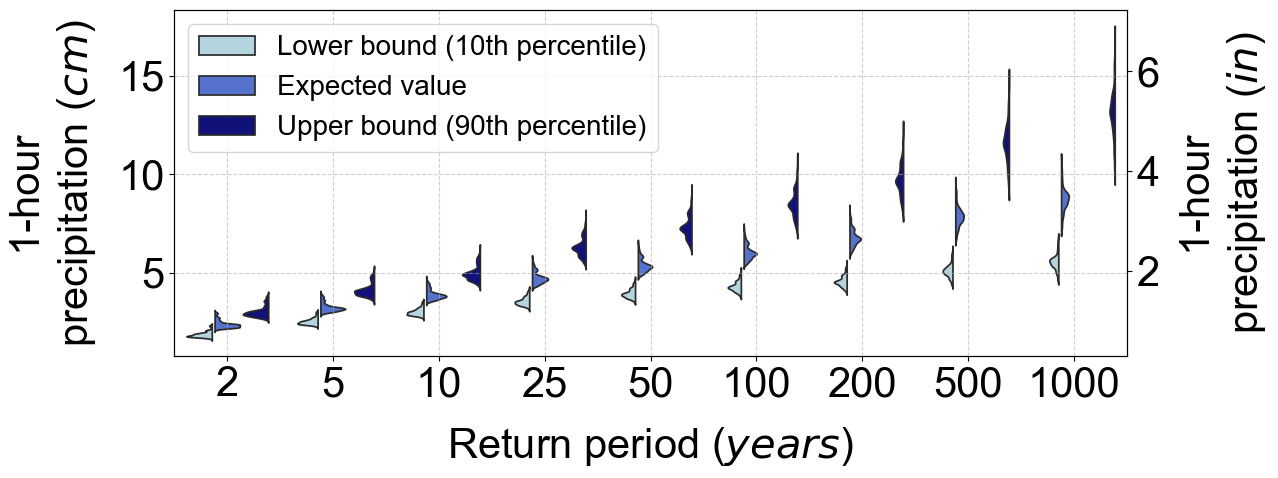

In [90]:
# Define colors for each category
custom_palette = {"hal": "lightblue", "Mean": "royalblue", "hau": "darkblue"}
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']

# Prepare long format dataframe for Seaborn
rain_data = []

for rain in return_periods:
    for duration in ['60m']:  # Focus on 30-minute duration
        for bound in ['a', 'al', 'au']:
            column_name = f"rain_{rain}_{duration}_{bound}"
            pre = "hau" if bound == "au" else "hal" if bound == "al" else "Mean"

            for value in culvert[column_name]:
                rain_data.append({
                    "Return Period": str(rain),
                    "Rainfall (m)": value,
                    "Type": pre
                })

# Convert to DataFrame
rain_long = pd.DataFrame(rain_data)

# Create figure and axis
fig, ax = plt.subplots(figsize=(13, 5))

# Create violin plot
sns.violinplot(
    x="Return Period", 
    y="Rainfall (m)", 
    hue="Type", 
    data=rain_long, 
    density_norm="area", 
    split=True,
    gap=0.1,
    dodge=True,
    inner=None, 
    palette=custom_palette, 
    hue_order=["hal", "Mean", "hau"],
    ax=ax
)

# Primary axis formatting
ax.set_xlabel("Return period ($years$)", fontsize=30, labelpad=15)
ax.set_ylabel("1-hour  \nprecipitation ($cm$)", fontsize=30, labelpad=15)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

# Add secondary y-axis for inches
ax2 = ax.twinx()
ymin, ymax = ax.get_ylim()
ax2.set_ylim(ymin * 0.393701, ymax * 0.393701)
ax2.set_ylabel("1-hour  \nprecipitation ($in$)", fontsize=30, labelpad=15)
ax2.tick_params(axis='y', labelsize=30)

# Legend
ax.legend(
    loc="upper left",
    labels=["Lower bound (10th percentile)", "Expected value", "Upper bound (90th percentile)"],
    fontsize=20
)

# Grid and tick configuration
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.grid(True, which='major', linestyle='--', alpha=0.6)

# Layout and save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\rainfall_disturibution_culvert_60min_2_1000.png", dpi=300, bbox_inches='tight')
plt.show()


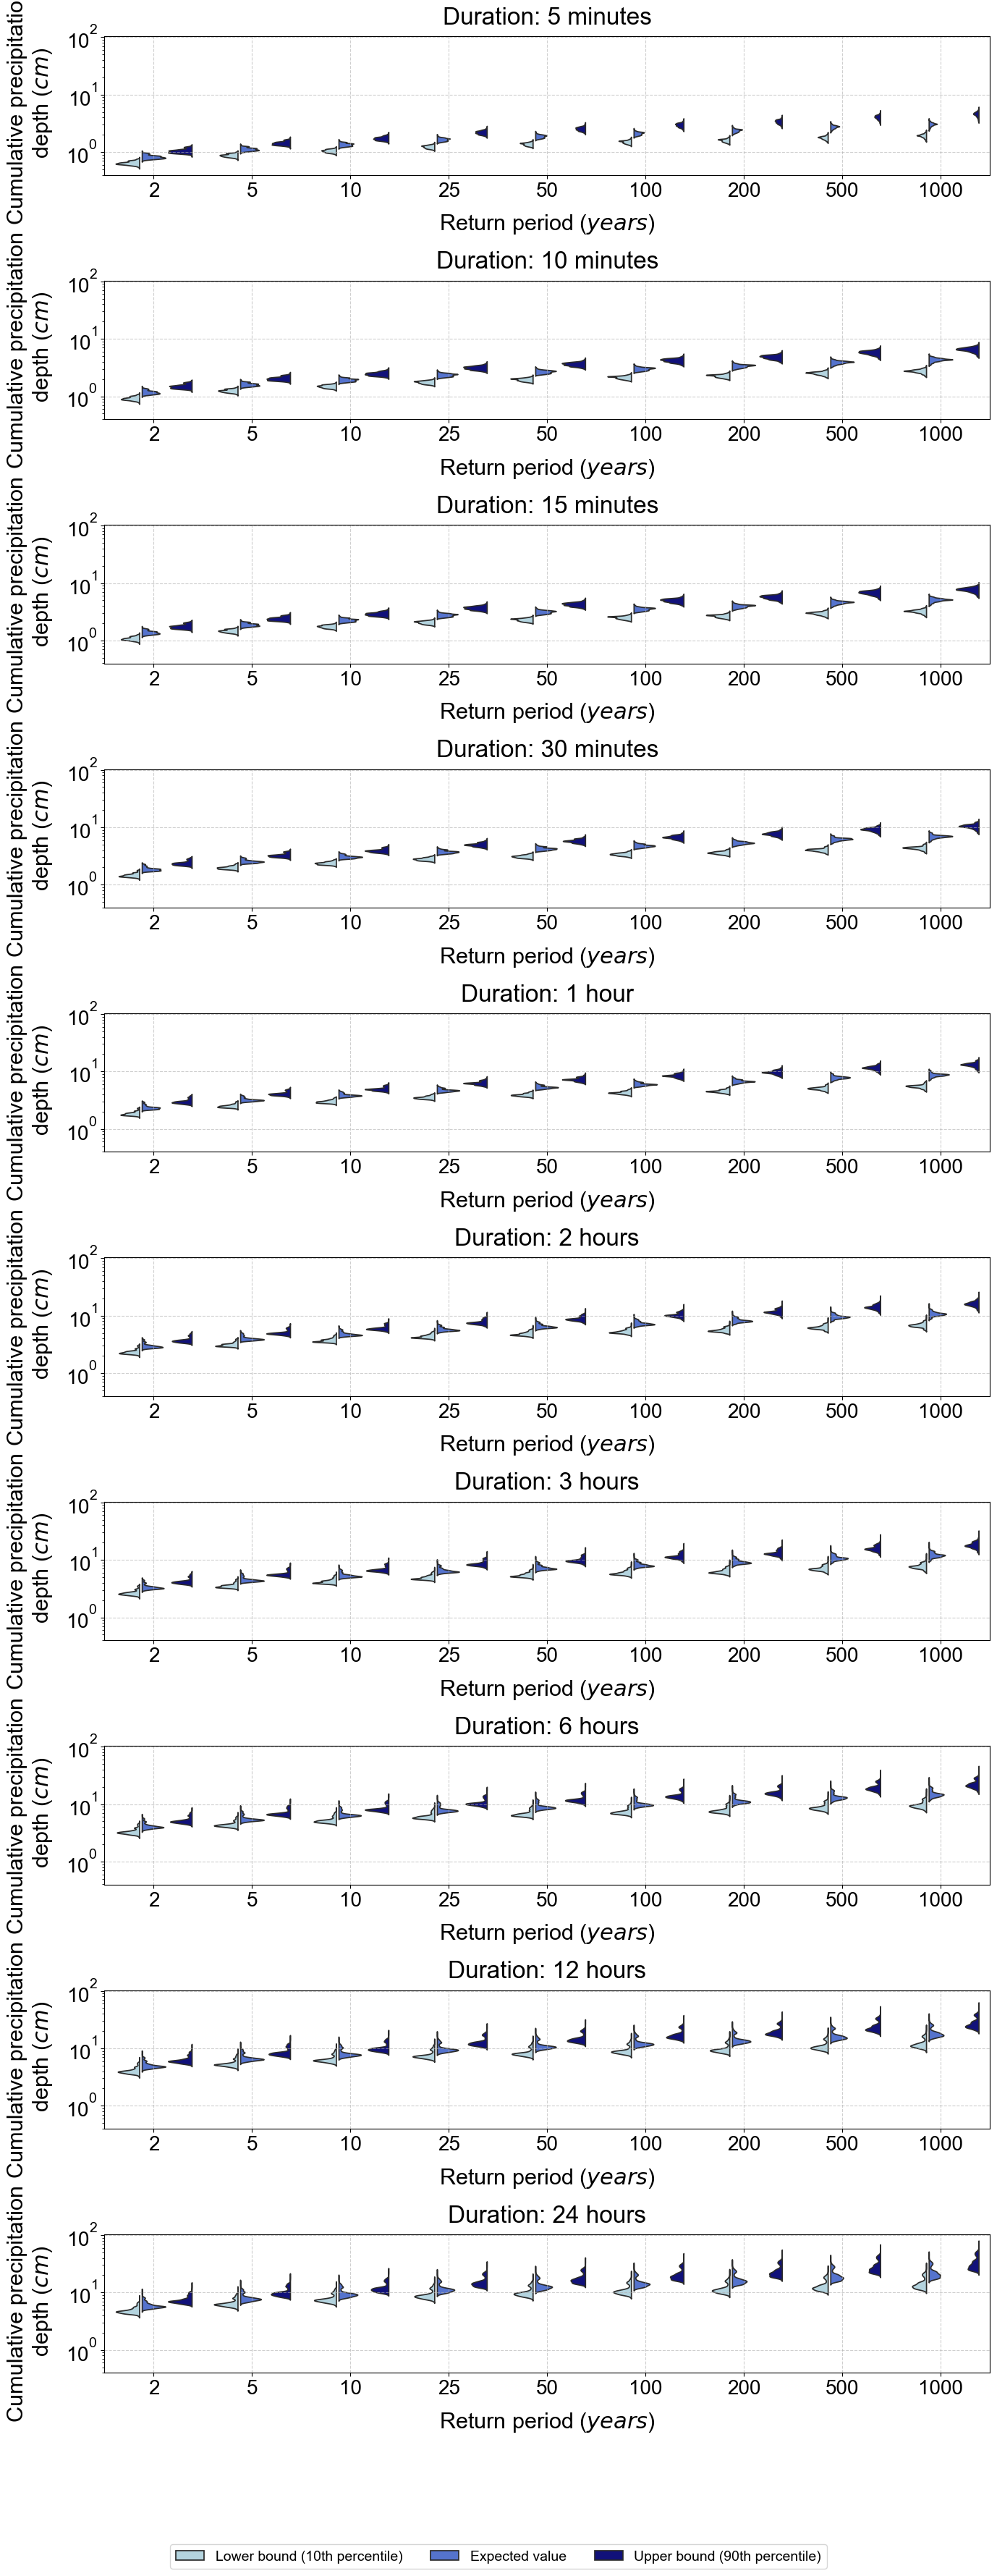

In [59]:

# Define colors
custom_palette = {"hal": "lightblue", "Mean": "royalblue", "hau": "darkblue"}

# Durations and display names
durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h']
duration_map = {
    '05m': '5 minutes', '10m': '10 minutes', '15m': '15 minutes',
    '30m': '30 minutes', '60m': '1 hour', '02h': '2 hours',
    '03h': '3 hours', '06h': '6 hours', '12h': '12 hours', '24h': '24 hours'
}

# Create subplots
fig, axes = plt.subplots(len(durations), 1, figsize=(14, 3.5 * len(durations)), sharey=True)

# Prepare long format dataframe
rain_data = []
for rain in return_periods:
    for duration in durations:
        for bound in ['a', 'al', 'au']:
            column_name = f"rain_{rain}_{duration}_{bound}"
            pre = "hau" if bound == "au" else "hal" if bound == "al" else "Mean"
            for value in culvert[column_name].dropna():
                rain_data.append({
                    "Return Period": str(rain),
                    "Rainfall (m)": value,
                    "Type": pre,
                    "Duration": duration
                })

rain_long = pd.DataFrame(rain_data)

# Plot each duration
for idx, duration in enumerate(durations):
    ax = axes[idx]
    rain_duration_data = rain_long[rain_long["Duration"] == duration]
    
    sns.violinplot(
        x="Return Period",
        y="Rainfall (m)",
        hue="Type",
        data=rain_duration_data,
        density_norm="area",
        split=True,
        gap=0.1,
        inner=None,
        palette=custom_palette,
        hue_order=["hal", "Mean", "hau"],
        ax=ax,
        legend=False
    )
    
    ax.set_title(f"Duration: {duration_map[duration]}", fontsize=24, pad=12)
    ax.set_xlabel("Return period ($years$)", fontsize=22, labelpad=12)
    ax.set_ylabel("Cumulative precipitation\n depth ($cm$)", fontsize=22, labelpad=12)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_yscale("log")
    ax.grid(True, linestyle="--", alpha=0.6)

# Add shared legend
fig.legend(
    loc="lower center",
    labels=["Lower bound (10th percentile)", "Expected value", "Upper bound (90th percentile)"],
    ncol=3,
    bbox_to_anchor=(0.5, -0.02),
    fontsize=14,
    frameon=True
)

plt.tight_layout(rect=[0, 0.03, 1, 1])  # Leave space at the bottom for legend

# Save and show
plt.savefig(r"D:\culvert repo\Results\Figures\rainfall_distribution_culvert_all_durations_2_1000.png", dpi=300)
plt.show()


#### Sanity checks for applying the NRCS method

In [4]:
culvert.shape

(2418, 553)

In [5]:
culvert=culvert[culvert['t_c_CN_wet']>0.1]
culvert=culvert[culvert['CN_wet']>40]
culvert.shape

(2247, 553)

# Rain type 

In [6]:
# Compute the type of rainfall for each culvert 
cul_type_III_file_path=r"D:\culvert repo\data\Rainfall type III\culverts_rain_type_III.shp"
culvert_III = gpd.read_file(cul_type_III_file_path)
culvert_III_bins = set(culvert_III['BIN'])
# function to assign rain_type based on the BIN
def determine_rain_type(bin_value):
    if bin_value in culvert_III_bins:
        return "III"
    else:
        return "II"
# Apply the function to the data frame
culvert['rain_type'] = culvert['BIN'].apply(determine_rain_type)

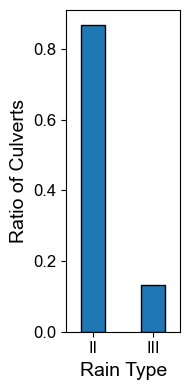

In [87]:
plt.figure(figsize=(2, 4))  # Set the figure size

# Normalize counts to ratios
ax = culvert['rain_type'].value_counts(normalize=True).plot(
    kind='bar',
    width=0.4,
    edgecolor='black'
)

# titles and labels
plt.xlabel('Rain Type', fontsize=14)
plt.ylabel('Ratio of Culverts', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Fix x-ticks with rain type names
plt.xticks(rotation=0, ha='center')

# Save
plt.savefig(r"D:\culvert repo\Results\Figures\rainfall_type.png", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


In [89]:
# time distribution for accumulated rainfall  
depths_II = [
    0.0000, 0.0010, 0.0020, 0.0030, 0.0041, 0.0051, 0.0062, 0.0072, 0.0083, 0.0094,
    0.0105, 0.0116, 0.0127, 0.0138, 0.0150, 0.0161, 0.0173, 0.0184, 0.0196, 0.0208,
    0.0220, 0.0232, 0.0244, 0.0257, 0.0269, 0.0281, 0.0294, 0.0306, 0.0319, 0.0332,
    0.0345, 0.0358, 0.0371, 0.0384, 0.0398, 0.0411, 0.0425, 0.0439, 0.0452, 0.0466,
    0.0480, 0.0494, 0.0508, 0.0523, 0.0538, 0.0553, 0.0568, 0.0583, 0.0598, 0.0614,
    0.0630, 0.0646, 0.0662, 0.0679, 0.0696, 0.0712, 0.0730, 0.0747, 0.0764, 0.0782,
    0.0800, 0.0818, 0.0836, 0.0855, 0.0874, 0.0892, 0.0912, 0.0931, 0.0950, 0.0970,
    0.0990, 0.1010, 0.1030, 0.1051, 0.1072, 0.1093, 0.1114, 0.1135, 0.1156, 0.1178,
    0.1200, 0.1222, 0.1246, 0.1270, 0.1296, 0.1322, 0.1350, 0.1379, 0.1408, 0.1438,
    0.1470, 0.1502, 0.1534, 0.1566, 0.1598, 0.1630, 0.1663, 0.1697, 0.1733, 0.1771,
    0.1810, 0.1851, 0.1895, 0.1941, 0.1989, 0.2040, 0.2094, 0.2152, 0.2214, 0.2280,
    0.2350, 0.2427, 0.2513, 0.2609, 0.2715, 0.2830, 0.3068, 0.3544, 0.4308, 0.5679,
    0.6630, 0.6820, 0.6986, 0.7130, 0.7252, 0.7350, 0.7434, 0.7514, 0.7588, 0.7656,
    0.7720, 0.7780, 0.7836, 0.7890, 0.7942, 0.7990, 0.8036, 0.8080, 0.8122, 0.8162,
    0.8200, 0.8237, 0.8273, 0.8308, 0.8342, 0.8376, 0.8409, 0.8442, 0.8474, 0.8505,
    0.8535, 0.8565, 0.8594, 0.8622, 0.8649, 0.8676, 0.8702, 0.8728, 0.8753, 0.8777,
    0.8800, 0.8823, 0.8845, 0.8868, 0.8890, 0.8912, 0.8934, 0.8955, 0.8976, 0.8997,
    0.9018, 0.9038, 0.9058, 0.9078, 0.9097, 0.9117, 0.9136, 0.9155, 0.9173, 0.9192,
    0.9210, 0.9228, 0.9245, 0.9263, 0.9280, 0.9297, 0.9313, 0.9330, 0.9346, 0.9362,
    0.9377, 0.9393, 0.9408, 0.9423, 0.9438, 0.9452, 0.9466, 0.9480, 0.9493, 0.9507,
    0.9520, 0.9533, 0.9546, 0.9559, 0.9572, 0.9584, 0.9597, 0.9610, 0.9622, 0.9635,
    0.9647, 0.9660, 0.9672, 0.9685, 0.9697, 0.9709, 0.9722, 0.9734, 0.9746, 0.9758,
    0.9770, 0.9782, 0.9794, 0.9806, 0.9818, 0.9829, 0.9841, 0.9853, 0.9864, 0.9876,
    0.9887, 0.9899, 0.9910, 0.9922, 0.9933, 0.9944, 0.9956, 0.9967, 0.9978, 0.9989,
    1.0000
]
# Provided 24-hour cumulative depths data
depths_III = np.array([
    0.0000, 0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110, 0.0120, 0.0130,
    0.0140, 0.0150, 0.0160, 0.0170, 0.0180, 0.0190, 0.0200, 0.0210, 0.0220, 0.0231, 0.0241, 0.0252, 0.0263, 0.0274,
    0.0285, 0.0296, 0.0308, 0.0319, 0.0331, 0.0343, 0.0355, 0.0367, 0.0379, 0.0392, 0.0404, 0.0417, 0.0430, 0.0443,
    0.0456, 0.0470, 0.0483, 0.0497, 0.0511, 0.0525, 0.0539, 0.0553, 0.0567, 0.0582, 0.0597, 0.0612, 0.0627, 0.0642,
    0.0657, 0.0673, 0.0688, 0.0704, 0.0720, 0.0736, 0.0753, 0.0770, 0.0788, 0.0806, 0.0825, 0.0844, 0.0864, 0.0884,
    0.0905, 0.0926, 0.0948, 0.0970, 0.0993, 0.1016, 0.1040, 0.1064, 0.1089, 0.1114, 0.1140, 0.1167, 0.1194, 0.1223,
    0.1253, 0.1284, 0.1317, 0.1350, 0.1385, 0.1421, 0.1458, 0.1496, 0.1535, 0.1575, 0.1617, 0.1659, 0.1703, 0.1748,
    0.1794, 0.1842, 0.1890, 0.1940, 0.1993, 0.2048, 0.2105, 0.2165, 0.2227, 0.2292, 0.2359, 0.2428, 0.2500, 0.2578,
    0.2664, 0.2760, 0.2866, 0.2980, 0.3143, 0.3394, 0.3733, 0.4166, 0.5000, 0.5840, 0.6267, 0.6606, 0.6857, 0.7020,
    0.7134, 0.7240, 0.7336, 0.7422, 0.7500, 0.7572, 0.7641, 0.7708, 0.7773, 0.7835, 0.7895, 0.7952, 0.8007, 0.8060,
    0.8110, 0.8158, 0.8206, 0.8252, 0.8297, 0.8341, 0.8383, 0.8425, 0.8465, 0.8504, 0.8543, 0.8579, 0.8615, 0.8650,
    0.8683, 0.8716, 0.8747, 0.8777, 0.8806, 0.8833, 0.8860, 0.8886, 0.8911, 0.8936, 0.8960, 0.8984, 0.9007, 0.9030,
    0.9052, 0.9074, 0.9095, 0.9116, 0.9136, 0.9156, 0.9175, 0.9194, 0.9212, 0.9230, 0.9247, 0.9264, 0.9280, 0.9296,
    0.9312, 0.9327, 0.9343, 0.9358, 0.9373, 0.9388, 0.9403, 0.9418, 0.9433, 0.9447, 0.9461, 0.9475, 0.9489, 0.9503,
    0.9517, 0.9530, 0.9544, 0.9557, 0.9570, 0.9583, 0.9596, 0.9609, 0.9621, 0.9634, 0.9646, 0.9658, 0.9670, 0.9682,
    0.9694, 0.9706, 0.9718, 0.9729, 0.9741, 0.9752, 0.9764, 0.9775, 0.9786, 0.9797, 0.9808, 0.9818, 0.9829, 0.9839,
    0.9850, 0.9860, 0.9870, 0.9880, 0.9890, 0.9900, 0.9909, 0.9919, 0.9928, 0.9938, 0.9947, 0.9956, 0.9965, 0.9974,
    0.9983, 0.9991, 1.0000
])

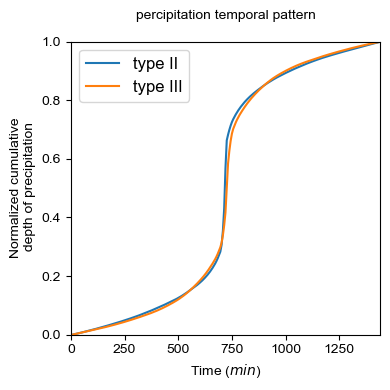

In [90]:
time = np.arange(1, len(depths_II) + 1)*6  # Create time array

plt.figure(figsize=(4, 4))
plt.plot(time, depths_II, label='type II', linestyle='-')
plt.plot(time, depths_III, label='type III', linestyle='-')
plt.xlabel(f'Time ($min$)')
plt.ylabel('Normalized cumulative\n depth of precipitation')
plt.xlim(0,24*60)
plt.ylim(0,1)
plt.title('percipitation temporal pattern\n')
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\Raintype_II_III_temporal_pattern.png", dpi=300, bbox_inches='tight')
plt.show()

# Peak discharge calculation

In [91]:
def max_n_hr_rainfall(rain_type, interval_hours):
    """
    Finds the n-hour interval with the highest cumulative rainfall.
    Parameters:
    - depths_24hr (array-like): Cumulative depths for a 24-hour rainfall distribution.
    - total_hours (int): Total duration of the rainfall distribution, typically 24 hours.
    - interval_hours (int): Duration of the interval to find, typically 6 hours.
    Returns:
    - depths_6hr (np.array): Depths over the 6-hour interval with the highest rainfall.
    - start_time (float): Start time of the interval with the highest rainfall.
    """
   #############################################################     
    total_hours=24
    if rain_type=='II': 
        depths_24hr = np.array(depths_II)
    else:
        depths_24hr = np.array(depths_III)
   #############################################################
    if interval_hours<0.5:
        # Time interval for original depths_II is 6 minutes, so generate time points
        time_6min = np.arange(0, len(depths_24hr) * 6, 6)
        
        # Interpolating depths for every 5 minutes
        interp_func = interp1d(time_6min, depths_24hr, kind='linear')
        time_5min = np.arange(0, time_6min[-1] + 1, 5)
        depths_24hr = interp_func(time_5min)
    #############################################################
    time_24hr = np.linspace(0, total_hours, len(depths_24hr))
    interval_steps = int(interval_hours * len(time_24hr) / total_hours)+2
    max_depth = 0
    start_index = 0
    for i in range(len(depths_24hr) - interval_steps):
        current_depth = depths_24hr[i + interval_steps] - depths_24hr[i]
        if current_depth > max_depth:
            max_depth = current_depth
            start_index = i
    depths_6hr = depths_24hr[start_index+1:start_index + interval_steps]
    depths_nhr= (depths_6hr - depths_6hr.min()) / (depths_6hr.max() - depths_6hr.min())
    start_time = time_24hr[start_index]
    return depths_nhr
# Call the function
#depth= max_n_hr_rainfall(rain_type='II',interval_hours=0.1667)
#print("Depths in this interval:", depth)

In [92]:
def incremental_rainfall(cumulative_rainfall):
    """
    Calculate incremental rainfall from cumulative rainfall data.
    Parameters:
    - cumulative_rainfall (array-like): Array of cumulative rainfall depths.
    Returns:
    - incremental_rainfall (np.array): Array of incremental rainfall depths.
    """
    cumulative_rainfall = np.array(cumulative_rainfall)
    incremental_rain = np.diff(cumulative_rainfall, prepend=0)  # Set the first increment to the first cumulative depth
    return incremental_rain

In [93]:
normalized_intervals = {}


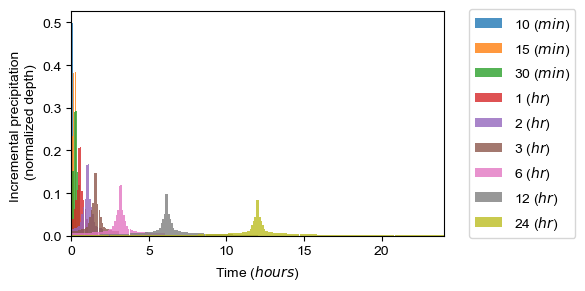

In [94]:
# Define intervals in hours
intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
# Store results
normalized_intervals = {}
# Compute and normalize rainfall for each interval
for interval in intervals:
    normalized_intervals[interval] = incremental_rainfall(
        max_n_hr_rainfall(rain_type=culvert.rain_type[0], interval_hours=interval)
    )
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))  # Increase width to accommodate legend
# Plot each interval
for interval, depths in normalized_intervals.items():
    label = f"{int(interval * 60)} ($min$)" if interval < 1 else f"{interval} ($hr$)"
    ax.bar(np.linspace(0, interval, len(depths)), depths, width=interval/len(depths), label=label,alpha=0.8)
# Set labels and limits
ax.set_xlabel(f"Time ($hours$)")
ax.set_ylabel("Incremental precipitation \n (normalized depth)")
ax.set_xlim(0, 24)
# Move legend outside, right, and vertically centered
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
# Save the figure
plt.savefig(r'D:\culvert repo\Results\Figures\normalized_temporal_incremental_rainfall_normalized_depths_typeII.png', 
            dpi=300, bbox_inches='tight')
plt.show()

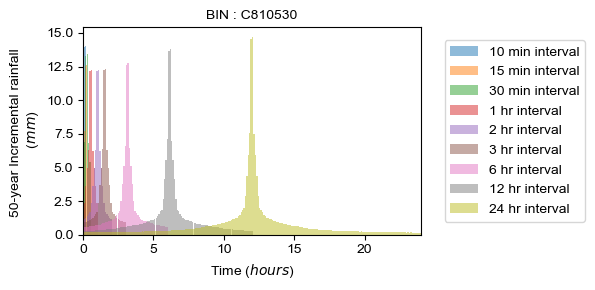

In [95]:
intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
depth = [
    culvert.rain_50_10m_a[0], culvert.rain_50_15m_a[0], culvert.rain_50_30m_a[0],
    culvert.rain_50_60m_a[0], culvert.rain_50_02h_a[0], culvert.rain_50_03h_a[0],
    culvert.rain_50_06h_a[0], culvert.rain_50_12h_a[0], culvert.rain_50_24h_a[0]
]
# Store results
normalized_intervals = {}
# Compute and normalize rainfall for each interval
for idx, interval in enumerate(intervals):
    rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type[0], interval_hours=interval) * depth[idx] * 10
    normalized_intervals[interval] = incremental_rainfall(rainfall)
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))  # Increase width to accommodate legend
# Plot each interval
for interval, depths in normalized_intervals.items():
    label = f"{int(interval * 60)} min interval" if interval < 1 else f"{interval} hr interval"
    ax.bar(np.linspace(0, interval, len(depths)), depths,width=interval/len(depths), label=label,alpha=0.5)
# Set labels and limits
ax.set_xlim(0, 24)
ax.set_xlabel(f"Time ($hours$)")
ax.set_ylabel(f"50-year Incremental rainfall \n ($mm$)")
ax.set_title(f"BIN : {culvert.BIN[0]}")
# Move legend outside, right, and vertically centered
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
# Save the figure
plt.savefig(r'D:\culvert repo\Results\Figures\temporal_incremental_rainfall_depths_culv_1.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [96]:
def calculate_excess_rainfall(rainfall_array, CN):
    # Curve number and initial abstraction calculations
    S = (25400 / CN) - 254
    I_default = 0.2 * S
    
    if len(rainfall_array)<6: 
        time_step=5 
    else: 
        time_step=6
    # Create a DataFrame with incremental depths (rainfall every 6 minutes)
    df = pd.DataFrame({
        'Time': np.arange(0, len(rainfall_array)*time_step, time_step),
        'Incremental Depths (mm)': rainfall_array
    })
    
    # Add the 'Cumulative Rainfall' column
    df['Cumulative Rainfall (mm)'] = df['Incremental Depths (mm)'].cumsum()
    
    # Calculate the 'Ia' (Initial Abstraction)
    df['Ia'] = df['Cumulative Rainfall (mm)'].apply(lambda P: min(P, I_default))
    
    # Calculate the 'Fa' (Fraction of Runoff) only when runoff occurs
    df['Fa'] = np.where(df['Cumulative Rainfall (mm)'] > df['Ia'],
                        (S * (df['Cumulative Rainfall (mm)'] - df['Ia'])) / 
                        (df['Cumulative Rainfall (mm)'] - df['Ia'] + S), 0) 
    
    # Calculate the 'Pe' (Excess Precipitation)
    df['Pe'] = np.maximum(df['Cumulative Rainfall (mm)'] - df['Ia'] - df['Fa'], 0)

    
    # Incremental Excess (difference in excess precipitation)
    df['Incremental Excess (mm)'] = df['Pe'].diff().fillna(df['Pe'])  # For the first value, just take 'Pe'
    
    return df

In [97]:
def construct_unit_hydrograph(tc, A, tr, time_step):
    """
    Constructs a unit hydrograph based on the given parameters.
    
    Parameters:
    tc (float): Time of concentration (in hours).
    A (float): Catchment area (in square kilometers).
    tr (float): Duration of excessive rainfall (in hours, default is 0.1 hour or 6 minutes).
    
    Returns:
    tuple: Time intervals (hours), discharge values (m³/s) at each interval, and the plot.
    """
    # Calculate parameters
    tp = 0.6 * tc  # Time to peak
    Tp = (tr / 2) + tp  # Time to peak of the unit hydrograph
    qp = 0.208 * A / Tp  # Peak discharge (m³/s)
    base = 2.67 * Tp  # Duration of the unit hydrograph
    
    # Calculate the slope of the second line of the triangle
    slope_second = (0 - qp) / (base - Tp)
    
    # Define the 6-minute intervals (converted to hours)
    intervals_in_hours = np.arange(0, base, time_step / 60)  # Time in hours for 6-minute intervals
    
    # Initialize a list to store discharge values at 6-minute intervals
    discharge_values = []

    # Calculate discharge for the unit hydrograph at each 6-minute interval
    for t in intervals_in_hours:
        if t <= Tp:
            discharge_values.append((qp / Tp) * t)  # Linear increase until Tp
        else:
            discharge_values.append(qp + slope_second * (t - Tp))  # Linear decrease after Tp
    
    # Plot the unit hydrograph
    time = np.linspace(0, base, 100)
    discharge = np.zeros_like(time)

    for i, t in enumerate(time):
        if t <= Tp:
            discharge[i] = (qp / Tp) * t  # Linear increase until Tp
        else:
            discharge[i] = qp + slope_second * (t - Tp)  # Linear decrease after Tp
    return intervals_in_hours, discharge_values

# Example usage with your culvert data
intervals, discharge_values = construct_unit_hydrograph(culvert.t_c_CN_wet[0], culvert.Area[0] / 10**6, 6 / 60, 6)


In [98]:
def calculate_total_discharge(df, unit_hydrograph):
    if len(df)<6:
        time_step=5
    else:
        time_step=6
    """
    Calculate the total discharge at each time step by applying the unit hydrograph
    to the incremental excess rainfall data.
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Time' and 'Incremental Excess (mm)' columns.
    unit_hydrograph (numpy.array): Array of unit hydrograph values for each time step.
    Returns:
    pandas.DataFrame: DataFrame with time steps, individual discharge values, and total discharge.
    """
    # Initialize a zero matrix for discharges, based on the number of time steps and unit hydrograph length
    discharge_matrix = np.zeros((len(df['Time']) + len(unit_hydrograph), len(df['Incremental Excess (mm)'])))
    # Loop through each Incremental Excess rainfall and calculate the discharge for each time step
    for idx, row in df.iterrows():
        # Multiply the Unit Hydrograph by the Incremental Excess value
        excess_rainfall = row['Incremental Excess (mm)']
        discharge_values = unit_hydrograph * excess_rainfall*(1/3.6)  # Multiply each Unit Hydrograph value by the Excess Rainfall
        # Find the start index where the rainfall begins (this corresponds to the current time step)
        start_idx = int(row['Time'] // time_step)  # Convert time step (in minutes) to the index (since it's a 6-minute interval)
        # Insert the discharge values starting from the corresponding time step
        discharge_matrix[start_idx:start_idx+len(unit_hydrograph), idx] = discharge_values
    # Create a DataFrame for the discharges
    discharge = pd.DataFrame(discharge_matrix, columns=[f'Discharge_{i+1}' for i in range(len(df['Incremental Excess (mm)']))])
    # Add the Time column to the DataFrame
    discharge['Time'] = np.concatenate([df['Time'], [df['Time'].iloc[-1] + time_step * (i+1) for i in range(len(unit_hydrograph))]])
    # Calculate the sum of discharges at each time step to get the total discharge
    discharge['Total Discharge'] = discharge.iloc[:, :-1].sum(axis=1)
    return discharge

In [21]:
culvert.BIN[0]

'C810530'

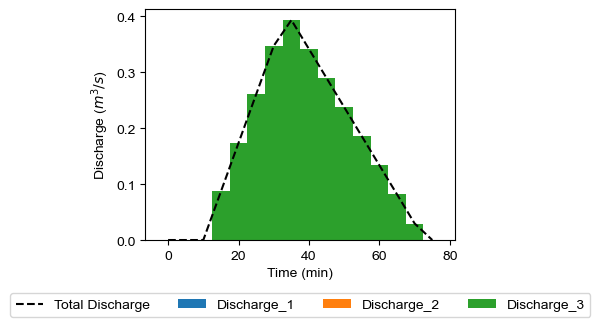

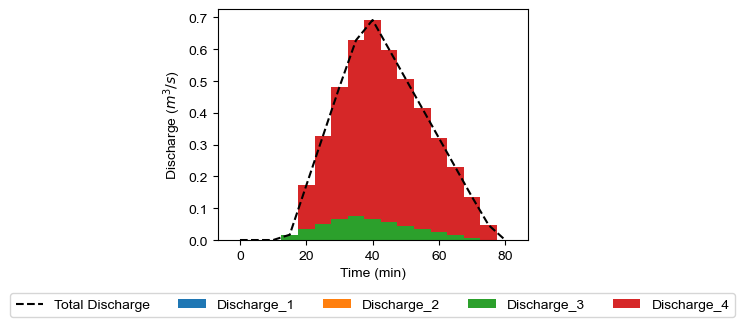

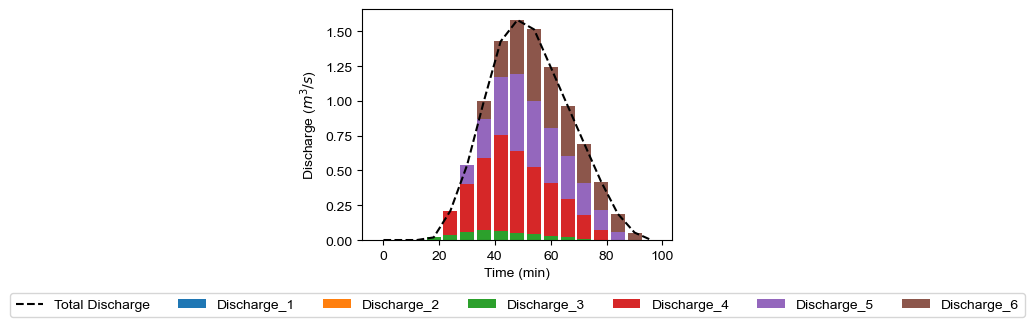

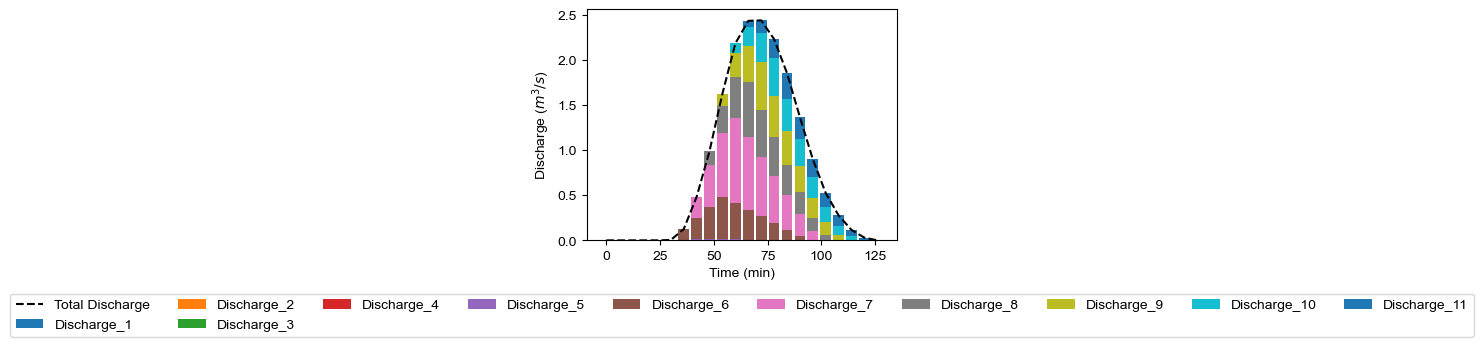

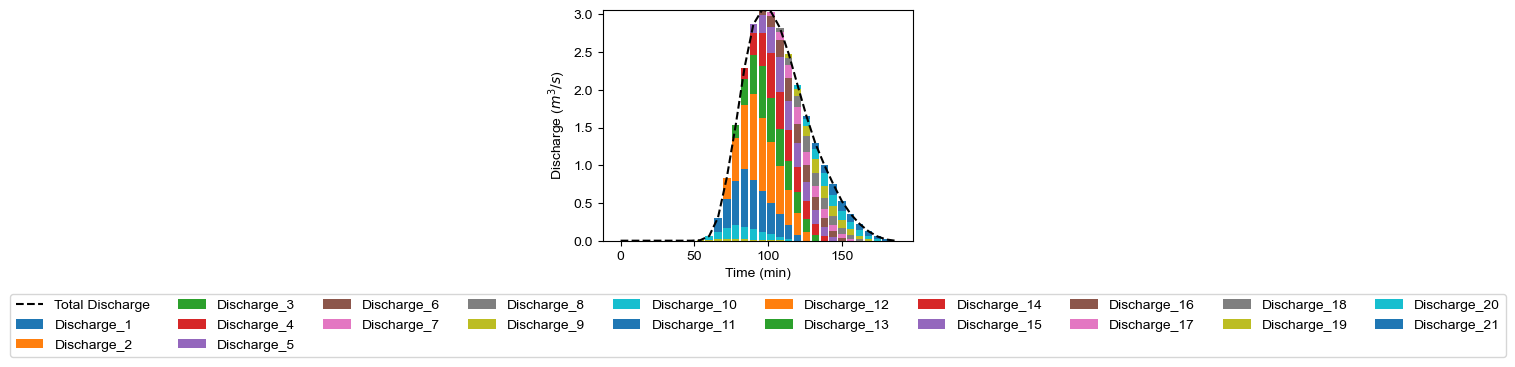

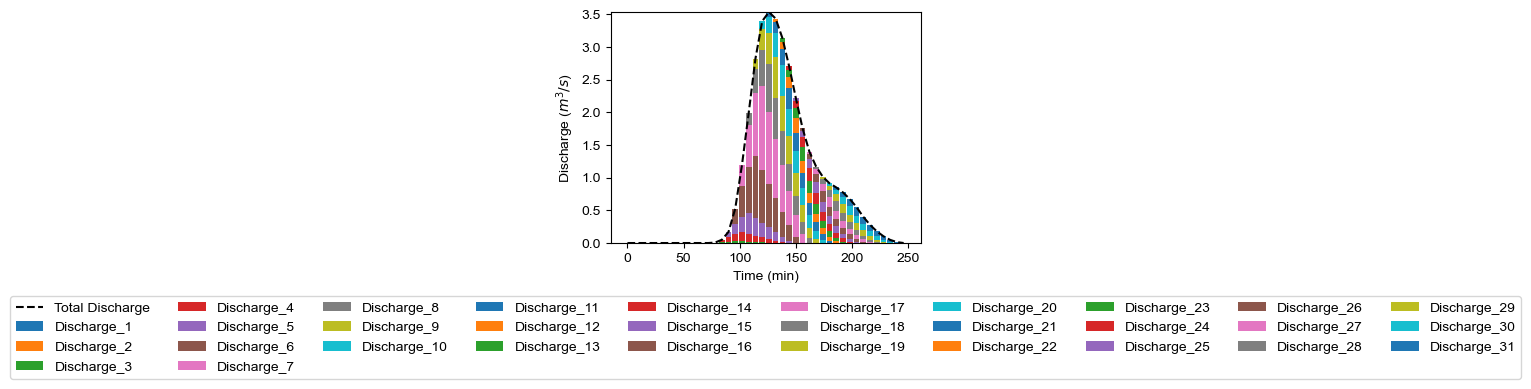

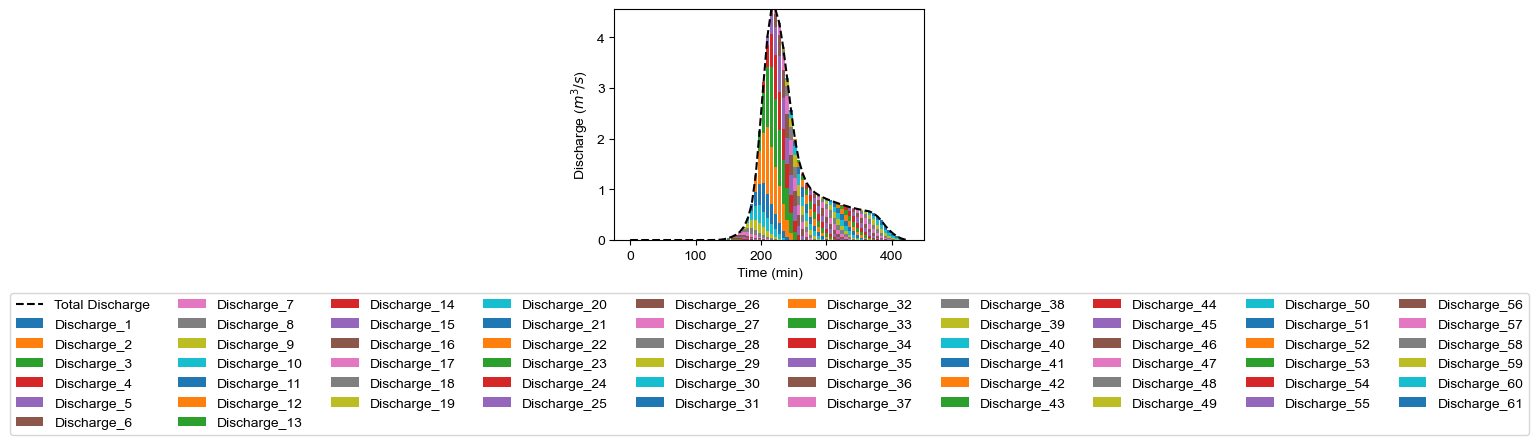

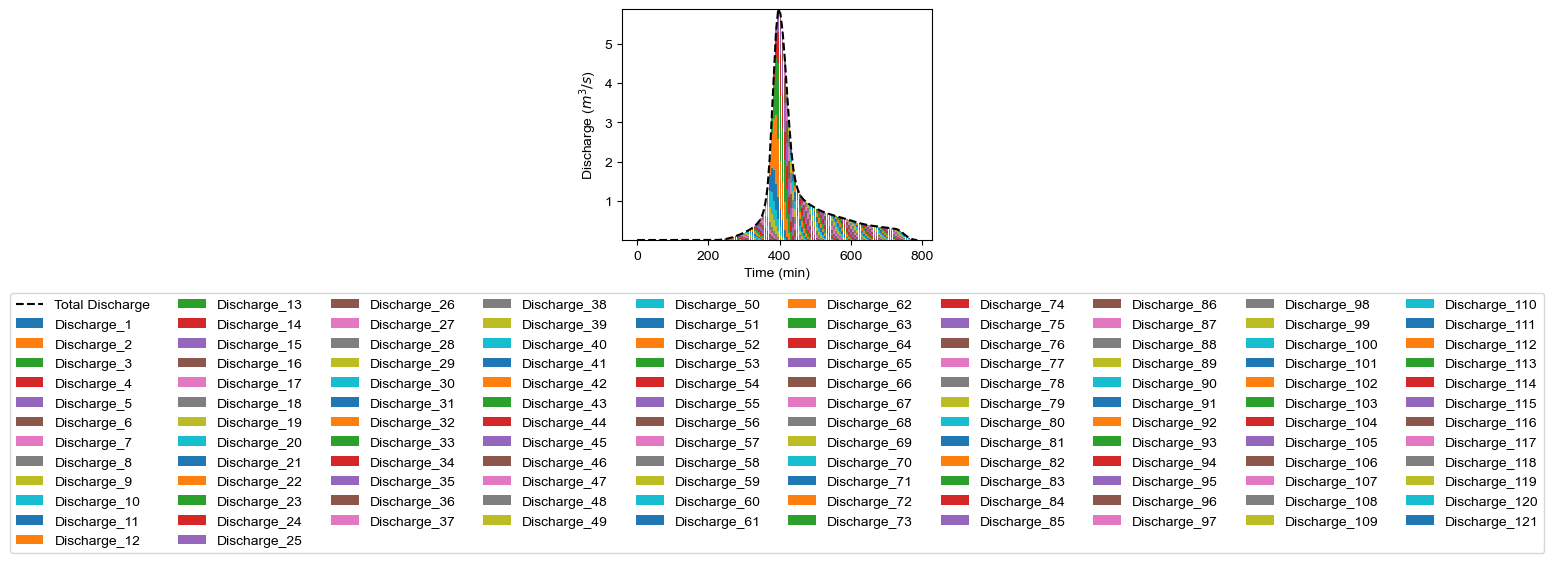

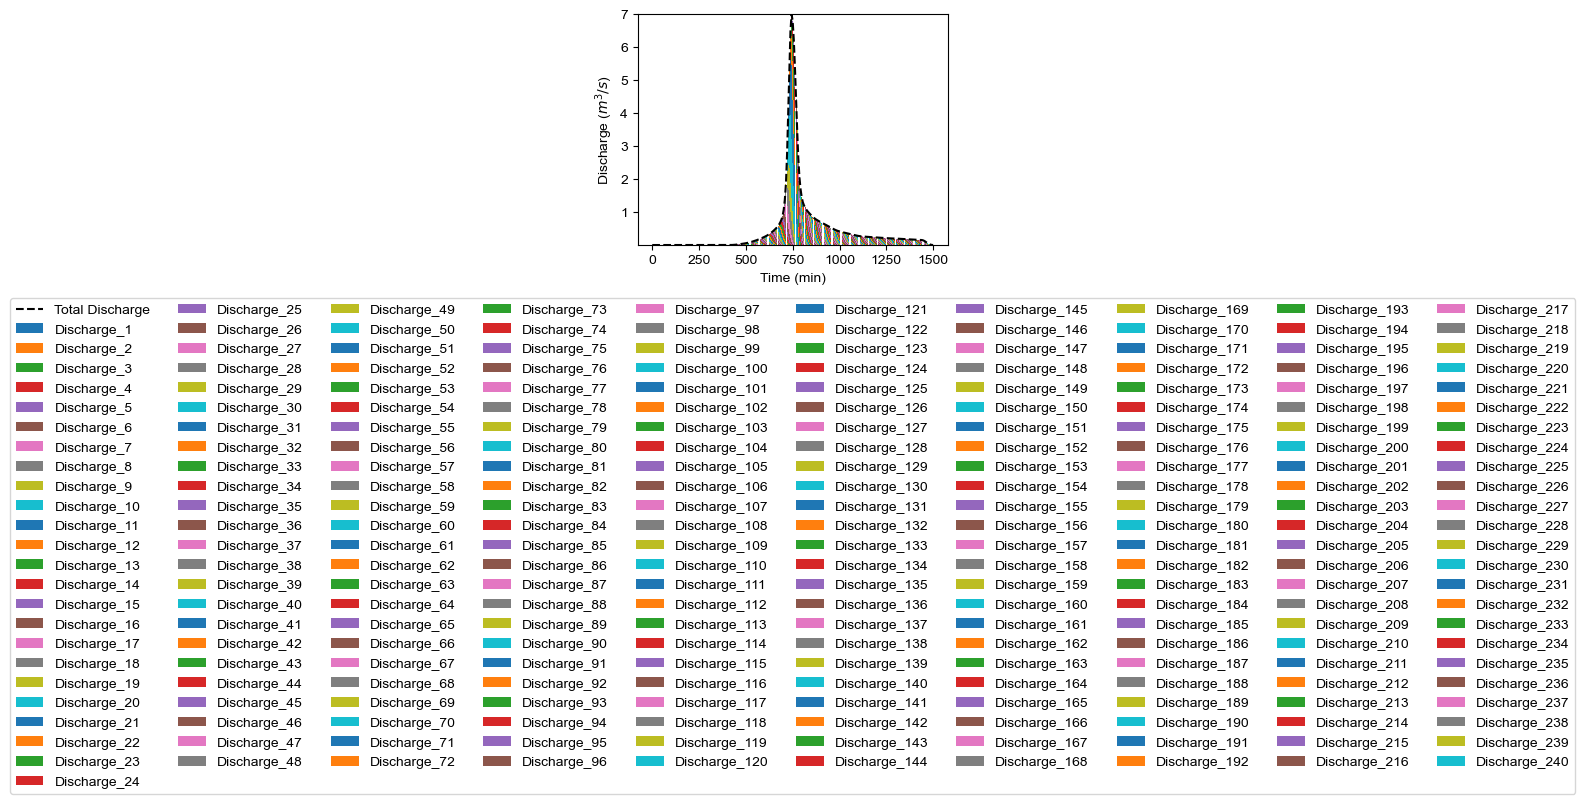

In [22]:
# List of intervals
intervals = [0.1667,0.25,0.5, 1, 2, 3, 6, 12, 24]
return_period=[2,5,10,25,50,100,200,500,1000]
max_dis=0
# Loop through each interval
for interval in intervals:
    # Example rainfall data for each interval (replace with actual data)
    incremental_depths_new = normalized_intervals[interval]
    # Calculate the excess rainfall for each interval
    result_df = calculate_excess_rainfall(incremental_depths_new,CN=culvert.CN[0])
    # Correct way to select columns from the result_df DataFrame
    data = result_df[['Time', 'Incremental Excess (mm)']]
    df = pd.DataFrame(data)
    #print(result_df)
    # Example Unit Hydrograph values (replace with your actual unit hydrograph values)
    if interval<0.5:
        time_step=5
    else:
        time_step=6
    intervals_1, discharge_values = construct_unit_hydrograph(culvert.t_c_CN_wet[0], culvert.Area[0]/10**6,time_step/60,time_step)
    unit_hydrograph = np.array(discharge_values)  # Example unit hydrograph values
    # Calculate the total discharge for this interval
    discharge = calculate_total_discharge(df, unit_hydrograph)
    #print(len(df))
    # Ensure discharge is a DataFrame and get the 'Total Discharge' column
    total_discharge = discharge['Total Discharge']
    # Find the time of maximum discharge
    max_discharge_index = total_discharge.idxmax()
    max_discharge_row = discharge.iloc[max_discharge_index]
    #print(max_discharge_row)
    # Check if the third-to-last element is non-zero
    if max_discharge_row[-3] != 0:
        max_dis = max_discharge_row[-1]
    # Plotting
    plt.figure(figsize=(4, 3))
    # Plot stacked bars for each discharge
    bottom_values = np.zeros(len(discharge))  # Start from zero for the first stack
    for col in discharge.columns[:-2]:  # Exclude Time and Total Discharge columns
        plt.bar(discharge['Time'], discharge[col], bottom=bottom_values, label=col, width=5)
        bottom_values += discharge[col]
    # Plot total discharge line
    plt.plot(discharge['Time'], discharge['Total Discharge'], color='black', linestyle='--', label='Total Discharge')
    # Add labels and title
    plt.xlabel('Time (min)')
    plt.ylabel('Discharge ($m^3/s$)')
    #plt.title(f'Stacked Contribution of Each Incremental Discharge to Total Discharge for Interval {interval} hrs')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=10)
    plt.savefig(rf'D:\culvert repo\Results\Figures\UH\{interval}.png',bbox_inches='tight',dpi=300)
    # Show the plot for the current interval
    plt.show()
#print("Max Discharge:", max_dis)

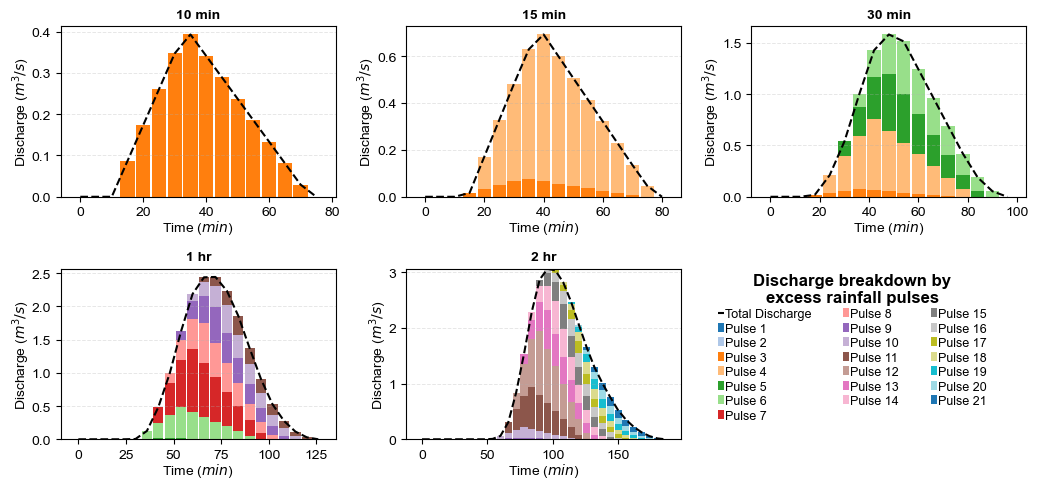

In [144]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 10})

# List of intervals and their titles
intervals = [0.1667, 0.25, 0.5, 1, 2]
titles = ["10 min", "15 min", "30 min", "1 hr", "2 hr"]

max_dis = 0

# Create a grid of subplots (2 rows, 3 columns since we have 5 intervals)
fig, axes = plt.subplots(2, 3, figsize=(3.5*3, 2.5*2))
axes = axes.flatten()

# Tableau 20 colors
tab20 = plt.cm.tab20.colors  

for i, interval in enumerate(intervals):
    incremental_depths_new = normalized_intervals[interval]
    result_df = calculate_excess_rainfall(incremental_depths_new, CN=culvert.CN[0])
    data = result_df[['Time', 'Incremental Excess (mm)']]
    df = pd.DataFrame(data)

    # choose timestep
    if interval < 0.5:
        time_step = 5
    else:
        time_step = 6

    intervals_1, discharge_values = construct_unit_hydrograph(
        culvert.t_c_CN_wet[0], culvert.Area[0]/10**6, time_step/60, time_step
    )
    unit_hydrograph = np.array(discharge_values)

    discharge = calculate_total_discharge(df, unit_hydrograph)
    total_discharge = discharge['Total Discharge']

    max_discharge_index = total_discharge.idxmax()
    max_discharge_row = discharge.iloc[max_discharge_index]
    if max_discharge_row[-3] != 0:
        max_dis = max_discharge_row[-1]

    # plot into the subplot
    ax = axes[i]
    bottom_values = np.zeros(len(discharge))

    # assign nicer labels for each pulse with tab20 colors
    for j, col in enumerate(discharge.columns[:-2], start=1):  
        ax.bar(
            discharge['Time'], discharge[col], 
            bottom=bottom_values, 
            width=0.9 * time_step,   # 90% of the step → leaves small gap
            label=f'Pulse {j}',
            color=tab20[(j-1) % 20]
                )
        bottom_values += discharge[col]

    # total discharge line
    ax.plot(discharge['Time'], discharge['Total Discharge'],
            color='black', linestyle='--', label='Total Discharge')

    # labels + custom title
    ax.set_xlabel('Time ($min$)', labelpad=0)
    ax.set_ylabel('Discharge ($m^3/s$)', labelpad=0)
    ax.set_title(titles[i],fontweight="bold")
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.3)

# Remove unused subplot (last one, since 2x3=6 but we only need 5)
fig.delaxes(axes[-1])

leg = fig.legend(
    handles, labels,
    title='Discharge breakdown by\nexcess rainfall pulses',
    title_fontsize=12,
    fontsize=9,
    loc='upper left',
    handlelength=0.5,
    columnspacing=2.5,
    handletextpad=0.1,
    frameon=False,
    ncol=3,
    labelspacing=0.2,
    borderpad=0.2,
    bbox_to_anchor=(0.68, 0.46)
)

# Bold + center the legend title
leg.get_title().set_fontweight('bold')
leg.get_title().set_ha('center')


plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\UH\all_intervals_grid_paper.png',
            bbox_inches='tight', dpi=300)
plt.show()


In [23]:
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize a dictionary to store the max discharge for each return period
    max_discharges = {}
    max_discharge_interval = {}
    max_dis = 0  # insures that the discharges of higher periods are increasing
    best_interval = None # To track the interval generating max discharge
    # Iterate over each return period
    for period in return_periods:
        # Loop through each interval
        for idx, interval in enumerate(intervals):
            # Set depth data (assuming the correct attributes are in `culvert`)
            # Use getattr to dynamically access the attribute based on the period
            depth = [
                getattr(culvert, f'rain_{period}_10m_a'),
                getattr(culvert, f'rain_{period}_15m_a'),
                getattr(culvert, f'rain_{period}_30m_a'),
                getattr(culvert, f'rain_{period}_60m_a'),
                getattr(culvert, f'rain_{period}_02h_a'),
                getattr(culvert, f'rain_{period}_03h_a'),
                getattr(culvert, f'rain_{period}_06h_a'),
                getattr(culvert, f'rain_{period}_12h_a'),
                getattr(culvert, f'rain_{period}_24h_a')
            ]
            # Compute and normalize rainfall for each interval
            rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
            normalized_intervals[interval]= incremental_rainfall(rainfall)
            # Calculate excess rainfall for each interval
            result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=culvert.CN_wet)
            # Extract relevant data for discharge calculation
            df = result_df[['Time', 'Incremental Excess (mm)']]
            # Determine time step based on interval
            time_step = 5 if interval < 0.5 else 6
            # Generate unit hydrograph
            intervals_1, discharge_values = construct_unit_hydrograph(
                culvert.t_c_CN_wet, culvert.Area / 10**6, time_step / 60, time_step
            )
            unit_hydrograph = np.array(discharge_values)
            # Calculate total discharge for this interval
            discharge = calculate_total_discharge(df, unit_hydrograph)
            # Get the total discharge column
            total_discharge = discharge['Total Discharge']
            # Find the maximum discharge value for the current interval
            max_discharge_index = total_discharge.idxmax()
            max_discharge_row = discharge.iloc[max_discharge_index]
            # Check if the third-to-last element is non-zero and update max discharge if needed
            if max_discharge_row[-3] != 0 and max_discharge_row[-1] > max_dis:
                max_dis = max_discharge_row[-1]
                best_interval = interval
        # Store the max discharge for this return period in the dictionary
        max_discharges[f'Q_{period}'] = max_dis
        max_discharge_interval[f'Q_{period}_interval'] = best_interval
    return {**max_discharges, **max_discharge_interval}
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]

def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 2418/2418 [19:46<00:00,  2.04it/s]


In [9]:
culvert[['BIN','Q_2','Q_5','Q_10','Q_2_interval','Q_5_interval','Q_10_interval']]

BIN       Q_2       Q_5      Q_10  Q_2_interval  Q_5_interval  \
0     C810530  1.180954  2.098554  2.859517           1.0           1.0   
1     C810550  1.476743  2.773433  3.877303           1.0           1.0   
2     C810490  0.416148  0.872202  1.275821           1.0           1.0   
3     C810520  0.243594  0.460555  0.657477           0.5           0.5   
4     C810491  1.606375  3.368058  4.965699           1.0           1.0   
...       ...       ...       ...       ...           ...           ...   
2376  C520244  1.311282  2.244282  3.014911           1.0           1.0   
2377  C520245  2.139057  3.662667  4.941855           1.0           1.0   
2378  C520214  1.681981  2.794377  3.701131           1.0           1.0   
2379  C520247  3.543257  5.927973  7.878054           1.0           1.0   
2380  C520248  1.950984  3.243569  4.295320           1.0           1.0   

      Q_10_interval  
0               1.0  
1               1.0  
2               1.0  
3               0.5  
4               1.0  
...             ...  
2376            1.0  
2377            1.0  
2378            1.0  
2379            1.0  
2380            1.0  

[2381 rows x 7 columns]

In [8]:
culvert=merged_culvert

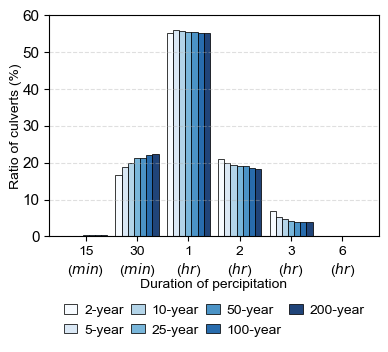

In [8]:
# Font setup (optional, publication style)
plt.rc('font', family='Arial', size=10)

# Duration values (in hours) and their display labels
duration_categories = [0.25, 0.5, 1, 2, 3, 6]
duration_labels = ['15\n($min$)','30\n($min$)', '1\n($hr$)', '2\n($hr$)','3\n($hr$)', '6\n($hr$)']
n_durations = len(duration_categories)

# Return period columns and labels
q_cols = [
    'Q_2_interval', 'Q_5_interval', 'Q_10_interval',
    'Q_25_interval', 'Q_50_interval', 'Q_100_interval','Q_200_interval'
]
legend_labels = {
    'Q_2_interval': '2-year',
    'Q_5_interval': '5-year',
    'Q_10_interval': '10-year',
    'Q_25_interval': '25-year',
    'Q_50_interval': '50-year',
    'Q_100_interval': '100-year',
    'Q_200_interval': '200-year'
}

# Use Blues colormap
cmap = cm.get_cmap('Blues', len(q_cols))
colors = [cmap(i) for i in range(len(q_cols))]

# Plot setup
bar_width = 0.12
x = np.arange(n_durations)

plt.figure(figsize=(4, 3.8))

for i, (col, color) in enumerate(zip(q_cols, colors)):
    data = culvert[col].dropna()
    total = len(data)
    counts = [np.sum(data == dur) / total * 100 for dur in duration_categories]
    offset = (i - len(q_cols)/2) * bar_width + bar_width / 2
    plt.bar(
        x + offset, counts, width=bar_width, 
        label=legend_labels[col], alpha=0.9,
        edgecolor='black', linewidth=0.6, color=color
    )

# Axis formatting
plt.xticks(ticks=x, labels=duration_labels, fontsize=10)
plt.xlabel('Duration of percipitation', fontsize=10,labelpad=0)
plt.ylabel('Ratio of culverts (%)', fontsize=10,labelpad=0)
plt.yticks(fontsize=11)
plt.ylim(0, 60)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Legend formatting

#plt.legend(title='Return Period', title_fontsize=12, fontsize=10, loc='upper center',handlelength=0.5,columnspacing=2.5,handletextpad=0.1, frameon=False, ncol=3,
#          labelspacing=0.2,borderpad=0.2).get_title().set_fontweight('bold')

plt.legend( title='',title_fontsize=10, ncol=4,
          handlelength=1, columnspacing=0.5, handletextpad=0.5,
          loc="upper center", bbox_to_anchor=(0.5, -0.25), frameon=False).get_title().set_fontweight('bold')


# Layout and export
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\Grouped_Bar_RainDuration_Percent_paper.png', dpi=300, bbox_inches='tight')
plt.show()

# compare with hydraulic capacity

In [107]:
pd.set_option('display.max_columns', None)


In [ ]:
# merge with hydraulic capacity dataset
file_path =r'D:\culvert repo\Results\Hydraulic analysis\hydraulic_analysis.xlsx'
culvert_df = pd.read_excel(file_path)
culvert_df.head()

In [27]:
culvert_df = culvert_df.drop_duplicates(subset=['BIN'])
#merged_culvert = pd.merge(culvert, culvert_df[['BIN', 'Q','MAXIMUM SPAN LENGTH (FT)','Height','max_HW_D','DESIGN TYPE','C','y','cul_S105']], on='BIN', how='inner')
merged_culvert = culvert.merge(culvert_df[['BIN','REGION','FUNCTIONAL CLASSIFICATION','COUNTY','YEAR BUILT','DESIGN TYPE', 'Q','average_Q_maxhw']], on='BIN', how='inner')
# Convert 'Q' column to cubic meters per second (m³/s)
merged_culvert['Q'] = merged_culvert['Q'] * 0.0283168
merged_culvert['average_Q_maxhw'] = merged_culvert['average_Q_maxhw'] * 0.0283168
merged_culvert.shape

(2381, 579)

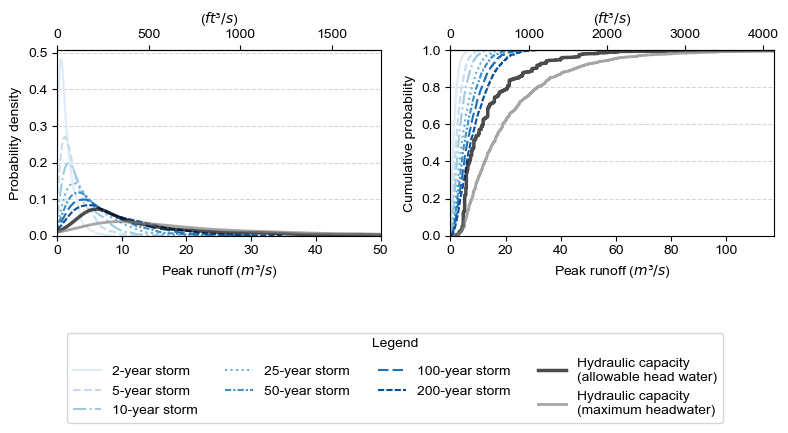

In [8]:
df_qp = merged_culvert[
    ['Q_2', 'Q_5', 'Q_10', 'Q_25', 'Q_50', 'Q_100', 'Q_200', 'Q','average_Q_maxhw']
].dropna()
# labels mapping
label_mapping = {
    'Q_2': '2-year storm',
    'Q_5': '5-year storm',
    'Q_10': '10-year storm',
    'Q_25': '25-year storm',
    'Q_50': '50-year storm',
    'Q_100': '100-year storm',
    'Q_200': '200-year storm',
    'Q': 'Hydraulic capacity\n(allowable head water)',
    'average_Q_maxhw': f'Hydraulic capacity \n(maximum headwater)'
}
# Define color scheme
return_periods = ['Q_2', 'Q_5', 'Q_10', 'Q_25', 'Q_50', 'Q_100', 'Q_200']
colors = sns.color_palette("Blues", n_colors=len(return_periods))  # Gradual blue shades
# Define line styles
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 3, 1)), (0, (1, 1, 1, 1)), (0, (2, 2, 1, 1))]  # Different line styles
# Ensure there are enough colors and line styles for all columns
extra_colors = sns.color_palette("Set2", n_colors=(df_qp.shape[1] - len(colors))) 
extra_linestyles = ['-' for _ in range(df_qp.shape[1] - len(linestyles))] 
colors.extend(extra_colors)
linestyles.extend(extra_linestyles)

# Create the figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
# KDE
for i, column in enumerate(df_qp.columns):
    data = df_qp[column].dropna()
    label = label_mapping[column]
    if column == 'Q':
        sns.kdeplot(data, ax=axs[0], label=label, color='black', linewidth=2.5, alpha=0.7) 
    elif column == 'average_Q_maxhw':
        sns.kdeplot(data, ax=axs[0], label=label, color='gray', linewidth=2, alpha=0.7) 
    else:
        sns.kdeplot(data, ax=axs[0], label=label, color=colors[i], linewidth=1.5, linestyle=linestyles[i])
axs[0].set_xlabel(f'Peak runoff ($m³/s$)')
axs[0].set_ylabel('Probability density')
axs[0].set_xlim(left=0, right=50)
axs[0].grid(axis='y', which='major', linestyle="--", alpha=0.5)
# Add secondary x-axis (ft³/s) to KDE
secax0 = axs[0].secondary_xaxis('top', functions=(lambda x: x * 35.3147, lambda x: x / 35.3147))
secax0.set_xlabel(f'($ft³/s$)')

# ECDF plots
for i, column in enumerate(df_qp.columns):
    data = df_qp[column].dropna()
    label = label_mapping[column]
    if column == 'Q':
        sns.ecdfplot(data, ax=axs[1], label=label, color='black', linewidth=2.5, alpha=0.7) 
        qmax = data.max()
    elif column == 'average_Q_maxhw':
        sns.ecdfplot(data, ax=axs[1], label=label, color='gray', linewidth=2, alpha=0.7)
    else:
        sns.ecdfplot(data, ax=axs[1], label=label, color=colors[i], linewidth=1.5, linestyle=linestyles[i])
axs[1].set_xlabel(f'Peak runoff ($m³/s$)')
axs[1].set_ylabel('Cumulative probability')
axs[1].set_xlim(left=0, right=qmax)
axs[1].grid(axis='y', which='major', linestyle="--", alpha=0.5)
# Add secondary x-axis (ft³/s) to ECDF
secax1 = axs[1].secondary_xaxis('top', functions=(lambda x: x * 35.3147, lambda x: x / 35.3147))
secax1.set_xlabel(f'($ft³/s$)')

# Adjust layout
plt.tight_layout()
# Add the legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Legend", loc="lower center", bbox_to_anchor=(0.5, -0.45), ncol=4)
# Save and show the figure
plt.savefig(r'D:\culvert repo\Results\Figures\Peak_Runoff_and_Capacity_ECDF_paper_test.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

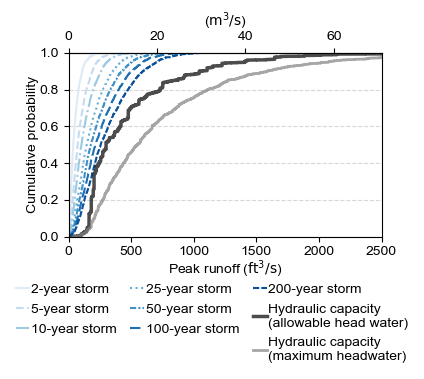

In [9]:
# --- Unit factor ---
M3S_TO_FT3S = 35.3147

fig, ax = plt.subplots(figsize=(4, 3))

qmax_ft = None  # we'll capture this from 'Q' to set x-limits

# ECDF plots (now plotted in ft³/s)
for i, column in enumerate(df_qp.columns):
    data_m = df_qp[column].dropna()
    data_ft = data_m * M3S_TO_FT3S  # convert to ft³/s
    label = label_mapping[column]

    if column == 'Q':
        sns.ecdfplot(data_ft, ax=ax, label=label, color='black', linewidth=2.5, alpha=0.7)
        qmax_ft = data_ft.max()
    elif column == 'average_Q_maxhw':
        sns.ecdfplot(data_ft, ax=ax, label=label, color='gray', linewidth=2, alpha=0.7)
    else:
        sns.ecdfplot(data_ft, ax=ax, label=label, color=colors[i],
                     linewidth=1.5, linestyle=linestyles[i])

# Labels and limits (primary = ft³/s)
ax.set_xlabel(r"Peak runoff ($\mathrm{ft}^3/\mathrm{s}$)", labelpad=0)
ax.set_ylabel("Cumulative probability", labelpad=0)

# Use the captured max from 'Q' if available; fall back to data-driven
if qmax_ft is not None:
    ax.set_xlim(left=0, right=qmax_ft)
ax.set_xlim(left=0, right=2500)
# If you prefer a fixed cap, set it in ft³/s (e.g., 70 m³/s ≈ 2472 ft³/s):
# ax.set_xlim(0, 70 * M3S_TO_FT3S)

ax.grid(axis='y', which='major', linestyle="--", alpha=0.5)

# Secondary x-axis (top) shows m³/s now
secax = ax.secondary_xaxis(
    'top',
    functions=(
        lambda x_ft: x_ft / M3S_TO_FT3S,  # primary(ft³/s) -> secondary(m³/s)
        lambda x_m:  x_m  * M3S_TO_FT3S   # secondary(m³/s) -> primary(ft³/s)
    )
)
secax.set_xlabel(r"($\mathrm{m}^3/\mathrm{s}$)")

# Legend (unchanged)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=10,
           loc='upper center', handlelength=1, columnspacing=1, handletextpad=0.1,
           frameon=False, ncol=3, bbox_to_anchor=(0.5, 0.08)
          ).get_title().set_fontweight('bold')

plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\Peak_Runoff_ECDF_only_paper.png",
            dpi=300, bbox_inches='tight')
plt.show()


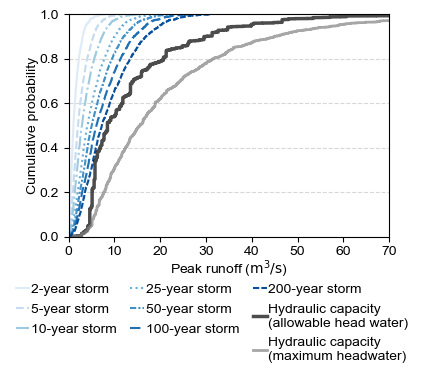

In [10]:
fig, ax = plt.subplots(figsize=(4, 3))

qmax_m = None  # we'll capture this from 'Q' to set x-limits

# ECDF plots (now plotted in m³/s directly)
for i, column in enumerate(df_qp.columns):
    data_m = df_qp[column].dropna()
    label = label_mapping[column]

    if column == 'Q':
        sns.ecdfplot(data_m, ax=ax, label=label, color='black', linewidth=2.5, alpha=0.7)
        qmax_m = data_m.max()
    elif column == 'average_Q_maxhw':
        sns.ecdfplot(data_m, ax=ax, label=label, color='gray', linewidth=2, alpha=0.7)
    else:
        sns.ecdfplot(data_m, ax=ax, label=label, color=colors[i],
                     linewidth=1.5, linestyle=linestyles[i])

# Labels and limits
ax.set_xlabel(r"Peak runoff ($\mathrm{m}^3/\mathrm{s}$)", labelpad=0)
ax.set_ylabel("Cumulative probability", labelpad=0)

# Use the captured max from 'Q' if available; fall back to data-driven
if qmax_m is not None:
    ax.set_xlim(left=0, right=qmax_m)
ax.set_xlim(left=0, right=70)  # example fixed cap in m³/s

ax.grid(axis='y', which='major', linestyle="--", alpha=0.5)

# Legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=10,
           loc='upper center', handlelength=1, columnspacing=1, handletextpad=0.1,
           frameon=False, ncol=3, bbox_to_anchor=(0.5, 0.08)
          ).get_title().set_fontweight('bold')

plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\Peak_Runoff_ECDF_only_paper_m3s.png",
            dpi=300, bbox_inches='tight')
plt.show()

In [94]:
merged_culvert [['Q_2', 'Q_5', 'Q_10', 'Q_25', 'Q_50', 'Q_100', 'Q_200', 'Q_500', 'Q_1000','Q','average_Q_maxhw']].describe().round()

Q_2     Q_5    Q_10    Q_25    Q_50   Q_100   Q_200   Q_500  Q_1000  \
count  2381.0  2381.0  2381.0  2381.0  2381.0  2381.0  2381.0  2381.0  2381.0   
mean      1.0     3.0     4.0     5.0     6.0     7.0     9.0    11.0    12.0   
std       1.0     2.0     3.0     3.0     4.0     5.0     6.0     7.0     8.0   
min       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
25%       1.0     1.0     2.0     2.0     3.0     4.0     4.0     5.0     6.0   
50%       1.0     2.0     3.0     4.0     5.0     6.0     7.0     9.0    11.0   
75%       2.0     4.0     5.0     7.0     8.0    10.0    12.0    15.0    18.0   
max       8.0    12.0    15.0    19.0    23.0    27.0    31.0    37.0    43.0   

            Q  average_Q_maxhw  
count  2381.0           2381.0  
mean     14.0             21.0  
std      13.0             19.0  
min       1.0              1.0  
25%       6.0              9.0  
50%       8.0             16.0  
75%      17.0             28.0  
max     117.0            180.0

In [11]:
def assign_exeedance_prob(row):
    if row['Q'] < row['Q_2']:
        return 1/2
    elif row['Q'] < row['Q_5']:
        return 1/5
    elif row['Q'] < row['Q_10']:
        return 1/10
    elif row['Q'] < row['Q_25']:
        return 1/25
    elif row['Q'] < row['Q_50']:
        return 1/50
    elif row['Q'] < row['Q_100']:
        return 1/100
    elif row['Q'] < row['Q_200']:
        return 1/200
    elif row['Q'] < row['Q_500']:
        return 1/500
    elif row['Q'] < row['Q_1000']:
        return 1/1000
    else:
        return 1/2000  # If Q is not less than any of the rain periods
# Apply the function to each row
merged_culvert['exeedance_prob'] = merged_culvert.apply(assign_exeedance_prob, axis=1)

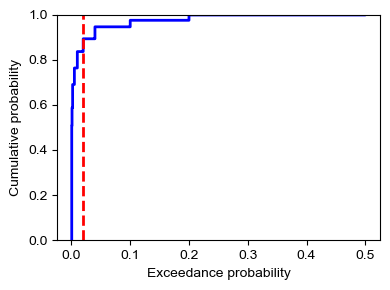

In [12]:
# Assuming 'merged_culvert' is your DataFrame and it contains the 'exceedance_prob' column
plt.figure(figsize=(4, 3))
# Plot ECDF for 'exceedance_prob'
sns.ecdfplot(merged_culvert['exeedance_prob'], color='blue', linewidth=2)
plt.axvline(x=0.02, color='red', linestyle='--', linewidth=2, label='Threshold at 0.02')
# Set labels and title
plt.xlabel('Exceedance probability')
plt.ylabel('Cumulative probability')
# Show the plot
plt.tight_layout()
plt.show()

In [32]:
# save to.xlsx file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq.xlsx'
merged_culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq.xlsx


In [3]:
culvert=pd.read_excel(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq.xlsx')
merged_culvert=culvert

In [4]:
merged_culvert=culvert

# Uncertainty bands of Q 

#### Upper bound

In [34]:
# upper bound
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize a dictionary to store the max discharge for each return period
    max_discharges = {}
    max_dis = 0  
    # Iterate over each return period
    for period in return_periods:
        # Loop through each interval
        for idx, interval in enumerate(intervals):
            # Set depth data (assuming the correct attributes are in `culvert`)
            # Use getattr to dynamically access the attribute based on the period
            depth = [
                getattr(culvert, f'rain_{period}_10m_au'),
                getattr(culvert, f'rain_{period}_15m_au'),
                getattr(culvert, f'rain_{period}_30m_au'),
                getattr(culvert, f'rain_{period}_60m_au'),
                getattr(culvert, f'rain_{period}_02h_au'),
                getattr(culvert, f'rain_{period}_03h_au'),
                getattr(culvert, f'rain_{period}_06h_au'),
                getattr(culvert, f'rain_{period}_12h_au'),
                getattr(culvert, f'rain_{period}_24h_au')
            ]
            # Compute and normalize rainfall for each interval
            rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
            normalized_intervals[interval]= incremental_rainfall(rainfall)
            # Calculate excess rainfall for each interval
            result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=np.maximum(culvert['CN_wet'], culvert['GEE_CN_wet']))
            # Extract relevant data for discharge calculation
            df = result_df[['Time', 'Incremental Excess (mm)']]
            # Determine time step based on interval
            time_step = 5 if interval < 0.5 else 6
            # Generate unit hydrograph
            intervals_1, discharge_values = construct_unit_hydrograph(
                np.minimum(culvert['t_c_CN_wet'], culvert['t_c_GEE_CN_wet']), culvert.Area_80 / 10**6, time_step / 60, time_step
            )
            unit_hydrograph = np.array(discharge_values)
            # Calculate total discharge for this interval
            discharge = calculate_total_discharge(df, unit_hydrograph)
            # Get the total discharge column
            total_discharge = discharge['Total Discharge']
            # Find the maximum discharge value for the current interval
            max_discharge_index = total_discharge.idxmax()
            max_discharge_row = discharge.iloc[max_discharge_index]
            # Check if the third-to-last element is non-zero and update max discharge if needed
            if max_discharge_row[-3] != 0:
                max_dis = max(max_dis, max_discharge_row[-1],culvert[f'Q_{period}'])
        # Store the max discharge for this return period in the dictionary
        max_dis= max (max_dis,culvert[f'Q_{period}'])
        max_discharges[f'Q_UL_{period}'] = max_dis
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 2381/2381 [20:24<00:00,  1.94it/s]


#### Lower bound

In [35]:
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize a dictionary to store the max discharge for each return period
    max_discharges = {}
    max_dis = 0 
    # Iterate over each return period
    for period in return_periods:
        # Loop through each interval
        for idx, interval in enumerate(intervals):
            # Set depth data (assuming the correct attributes are in `culvert`)
            # Use getattr to dynamically access the attribute based on the period
            depth = [
                getattr(culvert, f'rain_{period}_10m_al'),
                getattr(culvert, f'rain_{period}_15m_al'),
                getattr(culvert, f'rain_{period}_30m_al'),
                getattr(culvert, f'rain_{period}_60m_al'),
                getattr(culvert, f'rain_{period}_02h_al'),
                getattr(culvert, f'rain_{period}_03h_al'),
                getattr(culvert, f'rain_{period}_06h_al'),
                getattr(culvert, f'rain_{period}_12h_al'),
                getattr(culvert, f'rain_{period}_24h_al')
            ]
            # Compute and normalize rainfall for each interval
            rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
            normalized_intervals[interval]= incremental_rainfall(rainfall)
            # Calculate excess rainfall for each interval
            result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=np.minimum(culvert['CN_wet'], culvert['GEE_CN_wet']))
            # Extract relevant data for discharge calculation
            df = result_df[['Time', 'Incremental Excess (mm)']]
            # Determine time step based on interval
            time_step = 5 if interval < 0.5 else 6
            # Generate unit hydrograph
            intervals_1, discharge_values = construct_unit_hydrograph(
                np.maximum(culvert['t_c_CN_wet'], culvert['t_c_GEE_CN_wet']), culvert.Area_10 / 10**6, time_step / 60, time_step
            )
            unit_hydrograph = np.array(discharge_values)
            # Calculate total discharge for this interval
            discharge = calculate_total_discharge(df, unit_hydrograph)
            # Get the total discharge column
            total_discharge = discharge['Total Discharge']
            # Find the maximum discharge value for the current interval
            max_discharge_index = total_discharge.idxmax()
            max_discharge_row = discharge.iloc[max_discharge_index]
            # Check if the third-to-last element is non-zero and update max discharge if needed
            if max_discharge_row[-3] != 0:
                max_dis = max(max_dis, max_discharge_row[-1])
        # Store the max discharge for this return period in the dictionary
        max_dis= min(max_dis,culvert[f'Q_{period}'])
        max_discharges[f'Q_LL_{period}'] = max_dis
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 2381/2381 [20:07<00:00,  1.97it/s]


In [36]:
# save to.xlsx file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_UL_LL.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_UL_LL.xlsx


# AMC effect

In [37]:
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize dictionary to store max discharge for each return period
    max_discharges = {}
    # Iterate over each return period
    for ASM in ['nor','dry']:
        max_dis = 0
        for period in return_periods:
            # Loop through each interval
            for idx, interval in enumerate(intervals):
                # Set depth data (assuming the correct attributes are in `culvert`)
                # Use getattr to dynamically access the attribute based on the period
                depth = [
                    getattr(culvert, f'rain_{period}_10m_a'),
                    getattr(culvert, f'rain_{period}_15m_a'),
                    getattr(culvert, f'rain_{period}_30m_a'),
                    getattr(culvert, f'rain_{period}_60m_a'),
                    getattr(culvert, f'rain_{period}_02h_a'),
                    getattr(culvert, f'rain_{period}_03h_a'),
                    getattr(culvert, f'rain_{period}_06h_a'),
                    getattr(culvert, f'rain_{period}_12h_a'),
                    getattr(culvert, f'rain_{period}_24h_a')
                ]
                # Compute and normalize rainfall for each interval
                rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
                normalized_intervals[interval]= incremental_rainfall(rainfall)
                # Calculate excess rainfall for each interval
                result_df = calculate_excess_rainfall(normalized_intervals[interval], culvert['CN'] if ASM == 'nor' else culvert[f'CN_{ASM}'])
                # Extract relevant data for discharge calculation
                df = result_df[['Time', 'Incremental Excess (mm)']]
                # Determine time step based on interval
                time_step = 5 if interval < 0.5 else 6
                # Generate unit hydrograph
                intervals_1, discharge_values = construct_unit_hydrograph(
                    culvert['t_c_CN'] if ASM == 'nor' else culvert[f't_c_CN_{ASM}']  , culvert.Area / 10**6, time_step / 60, time_step
                )
                unit_hydrograph = np.array(discharge_values)
                # Calculate total discharge for this interval
                discharge = calculate_total_discharge(df, unit_hydrograph)
                # Get the total discharge column
                total_discharge = discharge['Total Discharge']
                # Find the maximum discharge value for the current interval
                max_discharge_index = total_discharge.idxmax()
                max_discharge_row = discharge.iloc[max_discharge_index]
                # Check if the third-to-last element is non-zero and update max discharge if needed
                if max_discharge_row[-3] != 0:
                    max_dis = max(max_dis, max_discharge_row[-1])
            # Store the max discharge for this return period in the dictionary
            max_discharges[f'Q_{period}_{ASM}'] = max_dis
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 2381/2381 [31:22<00:00,  1.26it/s]


In [96]:
culvert[['Q_50_dry','Q_50_nor','Q_50']].describe().round(1)

Q_50_dry  Q_50_nor    Q_50
count    2381.0    2381.0  2381.0
mean        0.8       2.8     6.1
std         0.8       2.3     4.2
min         0.0       0.0     0.0
25%         0.2       1.1     2.9
50%         0.6       2.2     5.1
75%         1.2       3.8     8.5
max         5.4      13.9    23.0

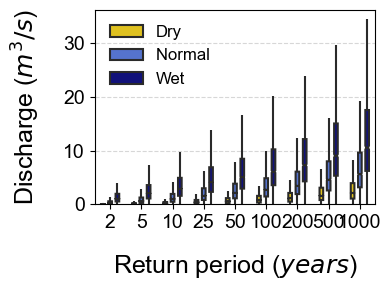

In [ ]:
# Define colors for each category
custom_palette = {"Q Normal": "royalblue", "Q Dry": "gold", "Q Wet": "darkblue"}
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']

# Prepare long-format dataframe
q_data = []
for q in return_periods:
    for scenario, label in zip(["_nor", "_dry", ""], ["Q Normal", "Q Dry", "Q Wet"]):
        column_name = f"Q_{q}{scenario}"
        for value in culvert[column_name]:  # Assuming 'culvert' is the DataFrame
            q_data.append({
                "Return Period": str(q),
                "Discharge (cms)": value,
                "Discharge (cfs)": value / 0.0283168,  # Convert to ft³/s
                "Type": label
            })

# Convert to DataFrame
q_long = pd.DataFrame(q_data)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(4, 3))

# Create the box plot for the return periods
sns.boxplot(
    x="Return Period",
    y="Discharge (cms)",
    hue="Type",
    data=q_long,
    palette=custom_palette,
    hue_order=["Q Dry", "Q Normal", "Q Wet"],
    dodge=True,
    width=0.7,
    linewidth=1.5,
    showfliers=False,
    notch=True,
    showcaps=False,
    gap=0.5,
    log_scale=False,
    ax=ax
)

# Labels and ticks
ax.set_xlabel("Return period ($years$)", fontsize=10, labelpad=0)
ax.set_ylabel("Discharge ($m^3/s$)", fontsize=10, labelpad=0)
ax.tick_params(axis='both', labelsize=14)
ax.set_ylim(0, )


# Customize legend
handles, labels = ax.get_legend_handles_labels()
filtered_labels = [label for label in labels if label != "Median capacity of culverts"]
label_map = {
    "Q Dry": "Dry",
    "Q Normal": "Normal ",
    "Q Wet": "Wet"
}
new_labels = [label_map.get(label, label) for label in filtered_labels]
ax.legend(handles, new_labels, loc="upper left", fontsize=10, frameon=False)

# Grid and layout
ax.grid(axis='y', which='major', linestyle="--", alpha=0.5)
plt.tight_layout()

# Save and show
plt.savefig(r"D:\culvert repo\Results\Figures\hydro_q_box_plots_2_1000.png", dpi=300, bbox_inches='tight')
plt.show()


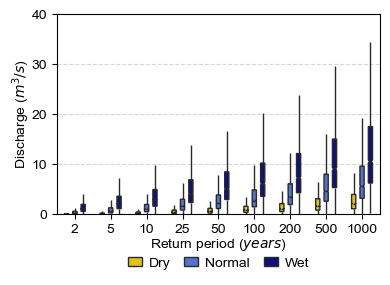

In [56]:
# Define colors for each category
custom_palette = {"Q Normal": "royalblue", "Q Dry": "gold", "Q Wet": "darkblue"}
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']

# Prepare long-format dataframe
q_data = []
for q in return_periods:
    for scenario, label in zip(["_nor", "_dry", ""], ["Q Normal", "Q Dry", "Q Wet"]):
        column_name = f"Q_{q}{scenario}"
        for value in culvert[column_name]:
            q_data.append({
                "Return Period": str(q),
                "Discharge (m³/s)": value,   # keep in m³/s
                "Type": label
            })

# Convert to DataFrame
q_long = pd.DataFrame(q_data)

# Set global font size
plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
})

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(4, 3))

# Create the box plot (in m³/s)
sns.boxplot(
    x="Return Period",
    y="Discharge (m³/s)",   # now using m³/s
    hue="Type",
    data=q_long,
    palette=custom_palette,
    hue_order=["Q Dry", "Q Normal", "Q Wet"],
    dodge=True,
    width=0.7,
    linewidth=1.0,
    showfliers=False,
    notch=True,
    showcaps=False,
    gap=0.5,
    ax=ax
)

# Labels and ticks
ax.set_xlabel("Return period ($years$)", labelpad=0)
ax.set_ylabel("Discharge ($m^3/s$)", labelpad=0)
ax.tick_params(axis='both')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
label_map = {"Q Dry": "Dry", "Q Normal": "Normal", "Q Wet": "Wet"}
new_labels = [label_map.get(label, label) for label in labels]
ax.legend(handles, new_labels, title_fontsize=10, ncol=3,
          handlelength=1, columnspacing=1, handletextpad=0.5,
          loc="upper center", bbox_to_anchor=(0.5, -0.15), frameon=False)
# Add custom bold title inside the plot
#ax.text(
#    0.5, 1.02, "Antecedent Moisture Condition", 
#    transform=ax.transAxes,
#    ha='center', va='bottom',
#    fontsize=10, fontweight='bold'
#)

# Limits and grid
ax.set_ylim(0, 40)   # adjust depending on your data range in m³/s
ax.grid(axis='y', which='major', linestyle="--", alpha=0.5)

plt.tight_layout()

# Save and show
plt.savefig(r"D:\culvert repo\Results\Figures\hydro_q_box_plots_2_1000_paper_m3s.png",
            dpi=300, bbox_inches='tight')
plt.show()


In [40]:
culvert [['Q_50_dry','Q_50_nor','Q_50']].describe().round()

Q_50_dry  Q_50_nor    Q_50
count    2381.0    2381.0  2381.0
mean        1.0       3.0     6.0
std         1.0       2.0     4.0
min         0.0       0.0     0.0
25%         0.0       1.0     3.0
50%         1.0       2.0     5.0
75%         1.0       4.0     8.0
max         5.0      14.0    23.0

In [41]:
# save to.xlsx file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_wet_dry.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_wet_dry.xlsx


In [42]:
culvert = pd.read_excel(r"D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_wet_dry.xlsx")

# Future landuse effect on discharge 

In [43]:
scenarios = ['A1B', 'A2', 'B1', 'B2']
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize dictionary to store max discharge for each return period
    max_discharges = {}
    # Iterate over each return period
    for scenario in scenarios:
        for ASM in ['Wet']:
            for year in years:
                max_dis = 0  
                for period in return_periods:
                    # Loop through each interval
                    for idx, interval in enumerate(intervals):
                        # Set depth data (assuming the correct attributes are in `culvert`)
                        # Use getattr to dynamically access the attribute based on the period
                        depth = [
                            getattr(culvert, f'rain_{period}_10m_a'),
                            getattr(culvert, f'rain_{period}_15m_a'),
                            getattr(culvert, f'rain_{period}_30m_a'),
                            getattr(culvert, f'rain_{period}_60m_a'),
                            getattr(culvert, f'rain_{period}_02h_a'),
                            getattr(culvert, f'rain_{period}_03h_a'),
                            getattr(culvert, f'rain_{period}_06h_a'),
                            getattr(culvert, f'rain_{period}_12h_a'),
                            getattr(culvert, f'rain_{period}_24h_a')
                        ]
                        # Compute and normalize rainfall for each interval
                        rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
                        normalized_intervals[interval]= incremental_rainfall(rainfall)
                        # Calculate excess rainfall for each interval
                        result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=culvert[f'CN_{year}_{scenario}_{ASM}'])
                        # Extract relevant data for discharge calculation
                        df = result_df[['Time', 'Incremental Excess (mm)']]
                        # Determine time step based on interval
                        time_step = 5 if interval < 0.5 else 6
                        # Generate unit hydrograph
                        intervals_1, discharge_values = construct_unit_hydrograph(
                            culvert[f't_CN_{year}_{scenario}_{ASM}'], culvert.Area / 10**6, time_step / 60, time_step
                        )
                        unit_hydrograph = np.array(discharge_values)
                        # Calculate total discharge for this interval
                        discharge = calculate_total_discharge(df, unit_hydrograph)
                        # Get the total discharge column
                        total_discharge = discharge['Total Discharge']
                        # Find the maximum discharge value for the current interval
                        max_discharge_index = total_discharge.idxmax()
                        max_discharge_row = discharge.iloc[max_discharge_index]
                        # Check if the third-to-last element is non-zero and update max discharge if needed
                        if max_discharge_row[-3] != 0:
                            max_dis = max(max_dis, max_discharge_row[-1])
                    # Store the max discharge for this return period in the dictionary
                    max_discharges[f'Q_{period}_{year}_{scenario}_{ASM}'] = max_dis
    return max_discharges
# Define return periods and intervals 
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000] 
def apply_max_discharge(row): 
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row 
    return calculate_max_discharge_for_row(row, return_periods) 
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing 
max_discharge_df = pd.DataFrame([ 
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing") 
]) 
# Convert the dictionary results to separate columns and concatenate them to the original data 
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1) 
culvert= culvert_Q

Rows processing: 100%|██████████| 2381/2381 [9:30:31<00:00, 14.38s/it]   


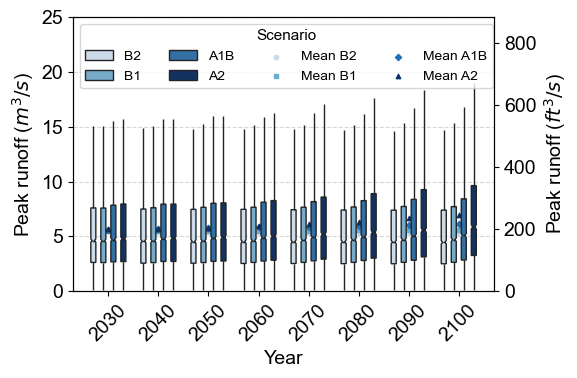

In [104]:
# Define scenarios and years
scenarios = ['B2', 'B1', 'A1B', 'A2']
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]

# Reshape data into long format for box plot
data = {'Year': [], 'Scenario': [], 'Q Value': []}
mean_data = {'Year': [], 'Scenario': [], 'Mean Q': []}

for year in years:
    for scenario in scenarios:
        q_values = culvert[f'Q_50_{year}_{scenario}_Wet'].dropna()  # Drop NaNs
        for value in q_values:
            data['Year'].append(year)
            data['Scenario'].append(scenario)
            data['Q Value'].append(value)
        # Store mean Q value for overlay line
        mean_data['Year'].append(year)
        mean_data['Scenario'].append(scenario)
        mean_data['Mean Q'].append(q_values.mean())

# Convert to DataFrames
df_box = pd.DataFrame(data)
df_mean = pd.DataFrame(mean_data)

# Set Year as categorical
df_box['Year'] = pd.Categorical(df_box['Year'], categories=years, ordered=True)
df_mean['Year'] = pd.Categorical(df_mean['Year'], categories=years, ordered=True)
# Set up the plot with primary axis
fig, ax = plt.subplots(figsize=(6, 4))

# Define color palette and markers
palette = ['#08306b', '#2171b5', '#6baed6', '#c6dbef'][::-1]
markers = ['o', 's', 'D', '^']

# Box plot on the primary axis
sns.boxplot(data=df_box, x='Year', y='Q Value', hue='Scenario', palette=palette, 
            showfliers=False, notch=True, showcaps=False, gap=0.5, ax=ax)

# Overlay mean trend lines
for i, scenario in enumerate(scenarios):
    subset = df_mean[df_mean['Scenario'] == scenario]
    x_positions = np.arange(len(years))
    ax.scatter(x_positions, subset['Mean Q'], marker=markers[i], s=10, 
               label=f'Mean {scenario}', color=palette[i])

# Customize primary axis
ax.set_xticks(np.arange(len(years)))
ax.set_xticklabels(years, rotation=45)
ax.set_ylim(0, 25)
ax.set_ylabel("Peak runoff ($m^3/s$)")
ax.set_xlabel("Year")
ax.grid(axis='y', which='major', linestyle="--", alpha=0.5)

# Secondary y-axis (ft³/s)
ax2 = ax.twinx()
ymin, ymax = ax.get_ylim()
ax2.set_ylim(ymin * 35.3147, ymax * 35.3147)
ax2.set_ylabel("Peak runoff ($ft^3/s$)", fontsize=14)

# Legend
ax.legend(title="Scenario", loc="upper left", ncol=4, fontsize=10, title_fontsize=11)

# Save and show
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\Q50_distribution_culvert_2030_2100.png", dpi=300, bbox_inches='tight')
plt.show()

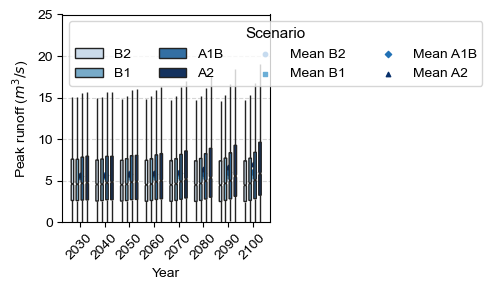

In [46]:
# save to .xlsx file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100.xlsx


In [70]:
culvert=pd.read_excel(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100.xlsx')

#### Correlation analysis of depth of rainfall in different durations with the same frequency

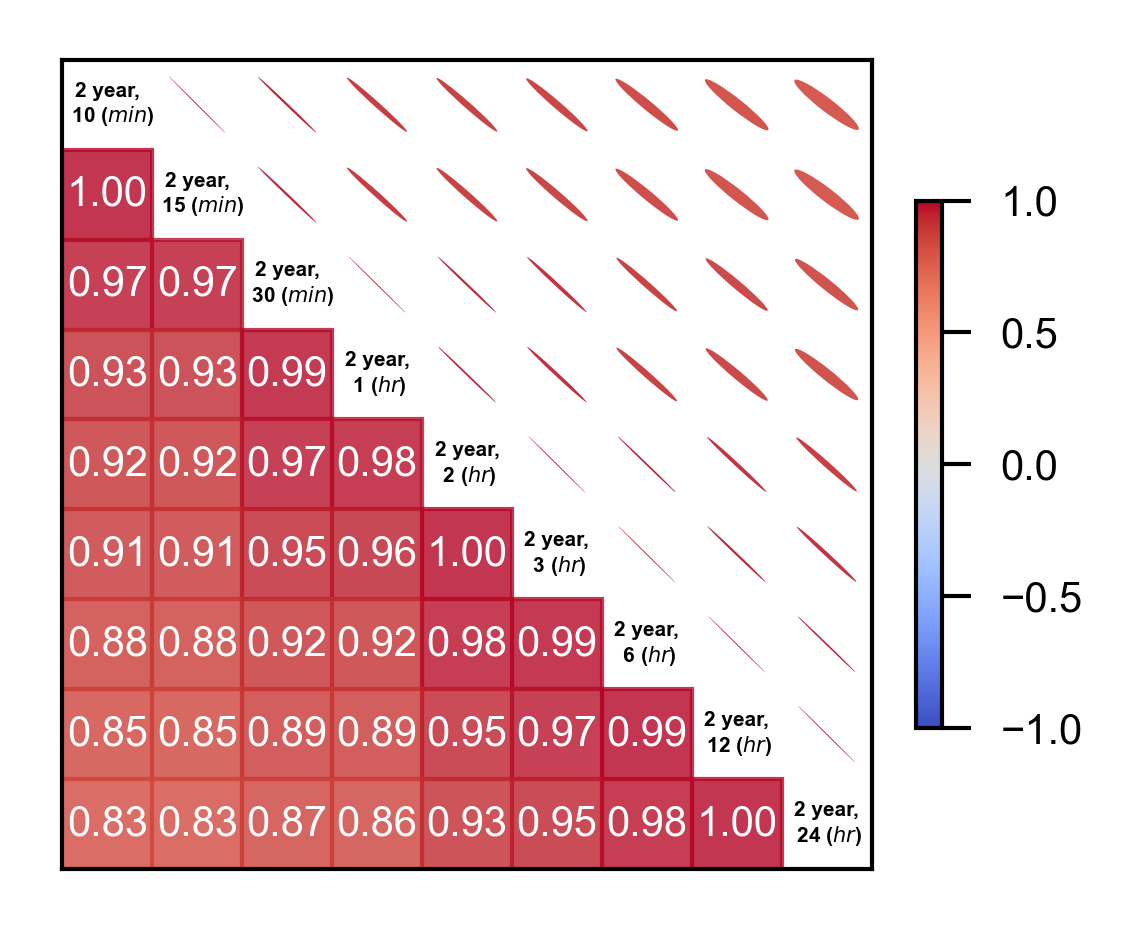

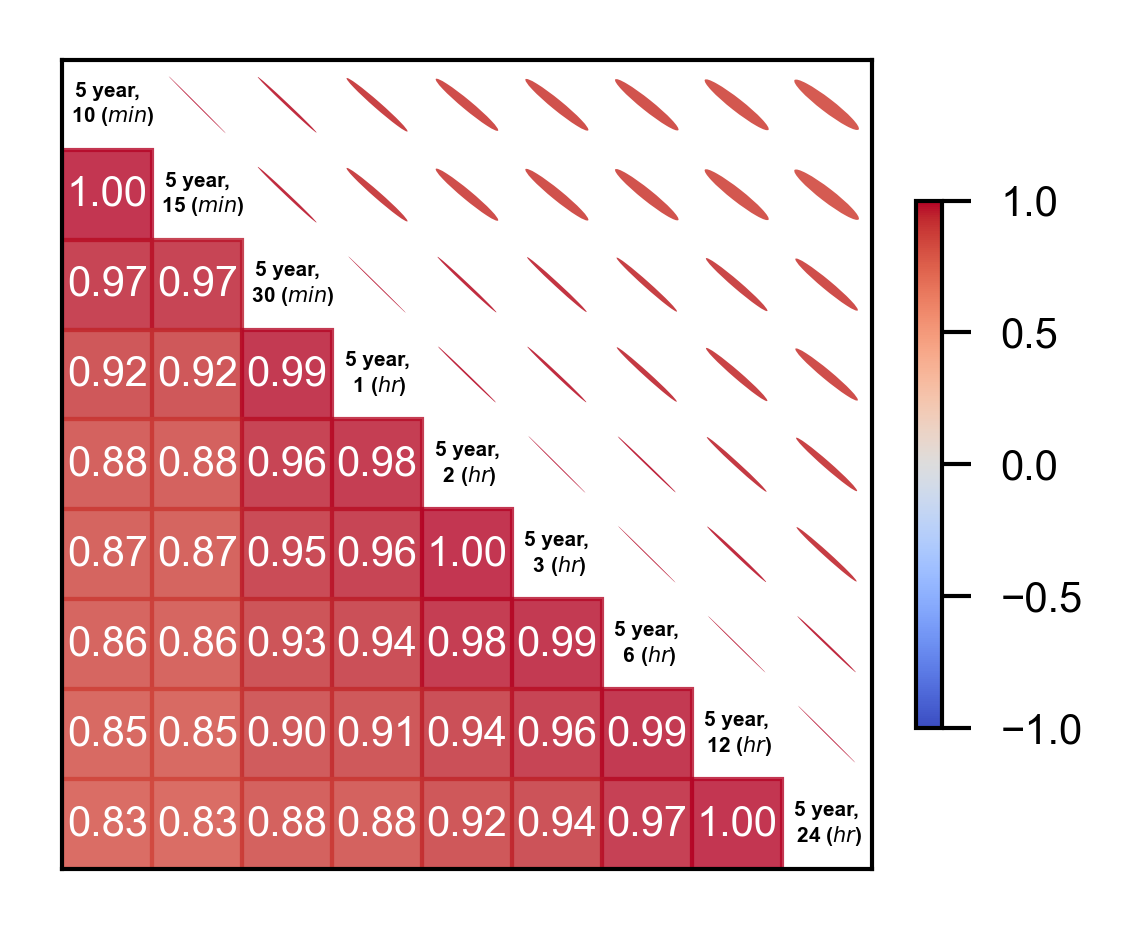

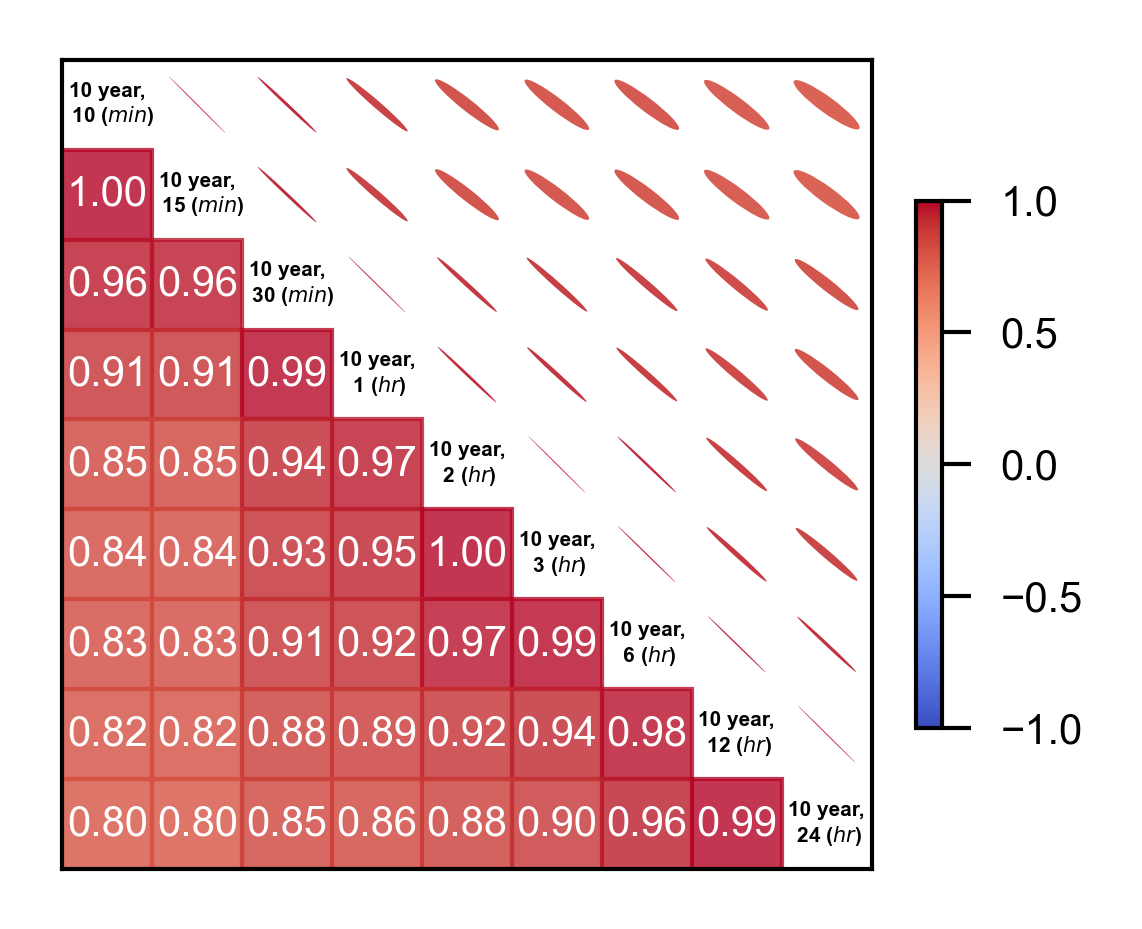

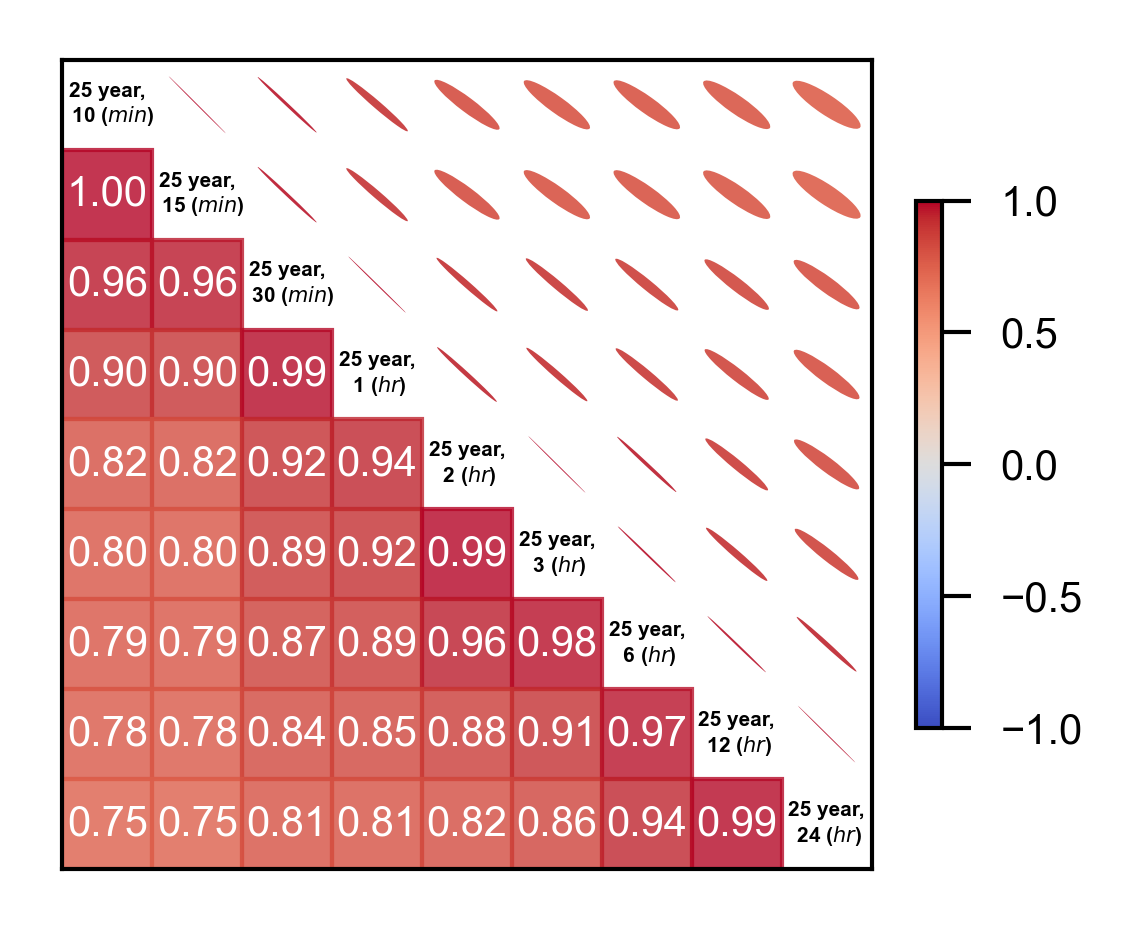

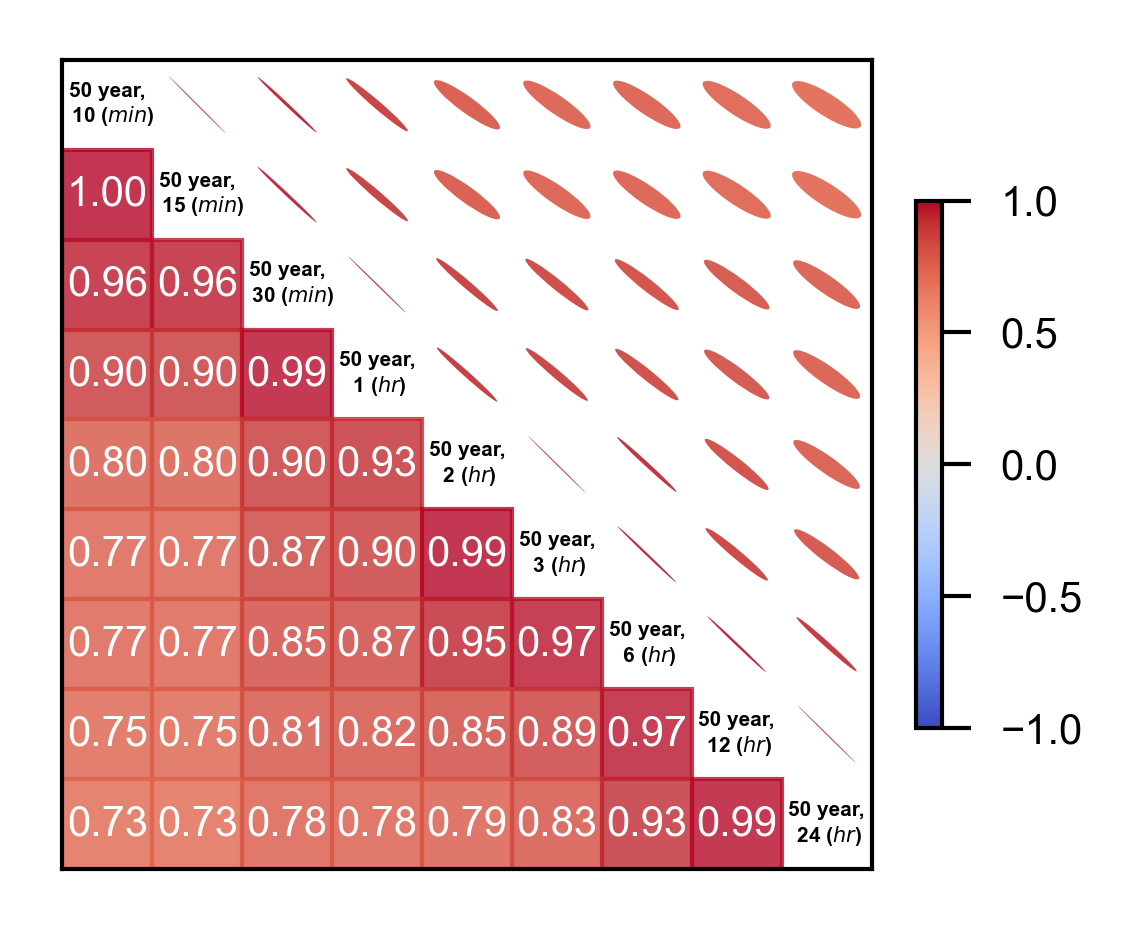

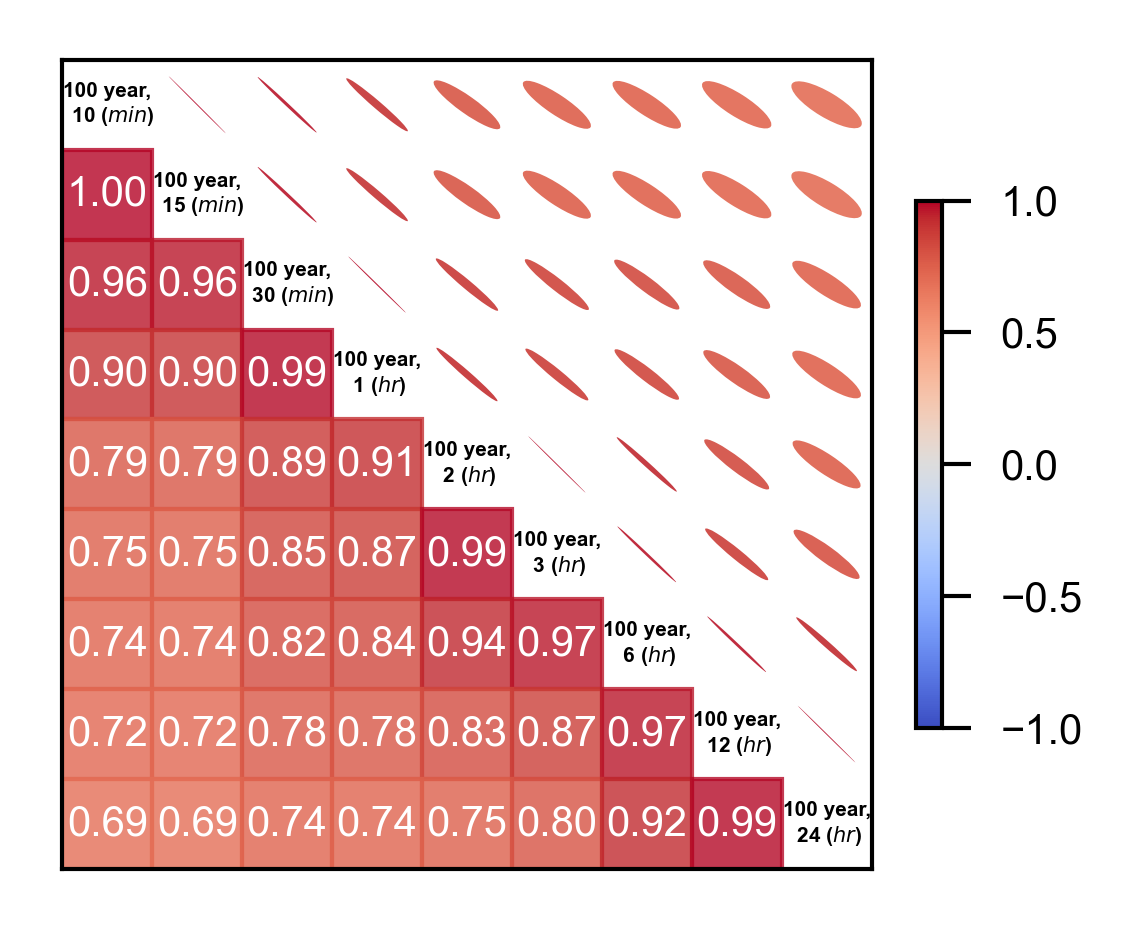

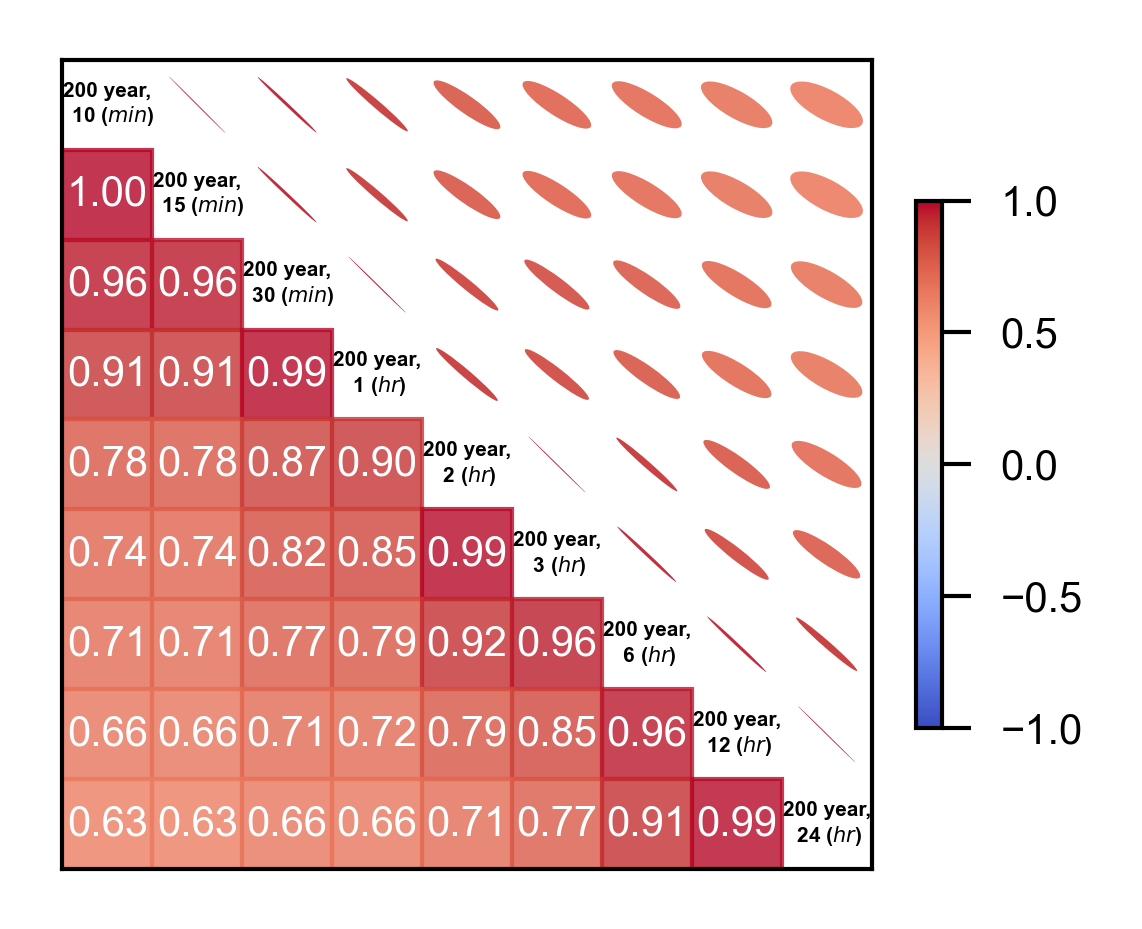

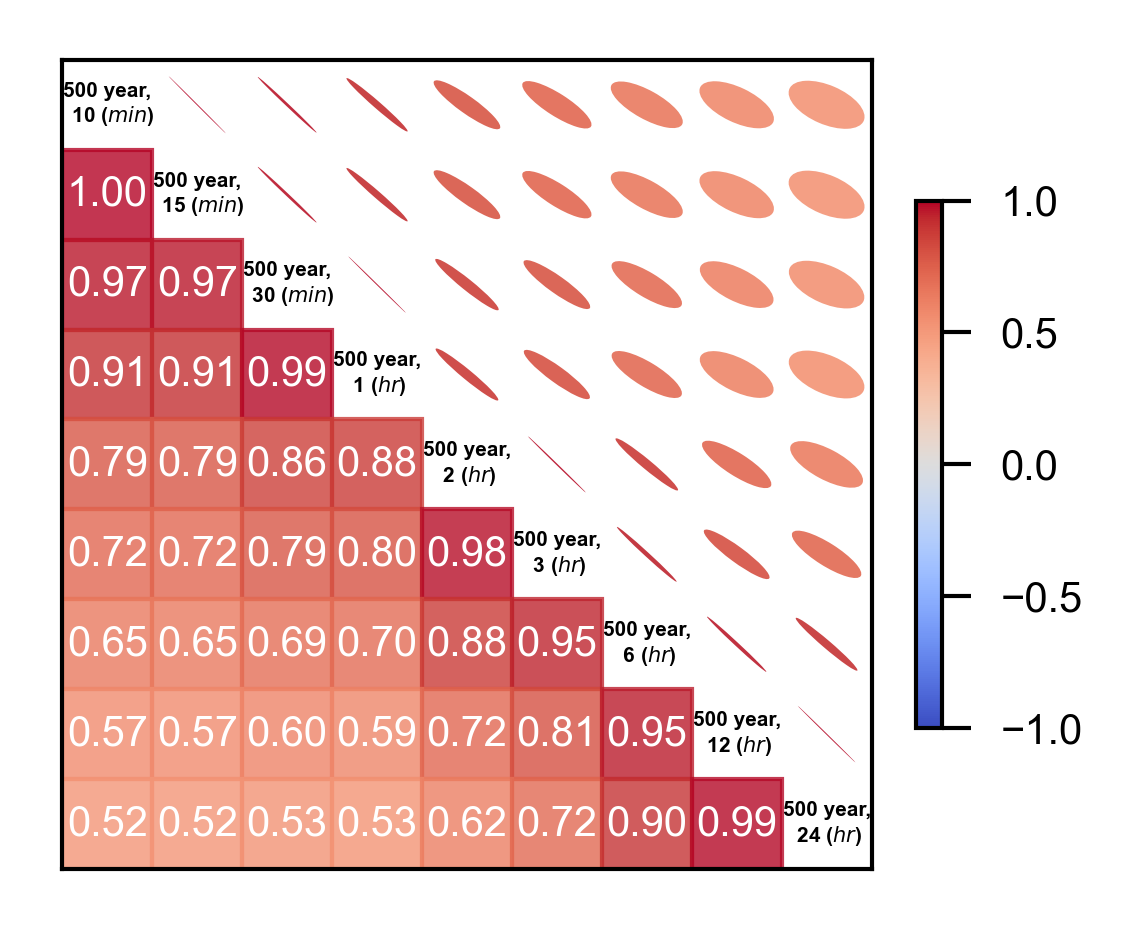

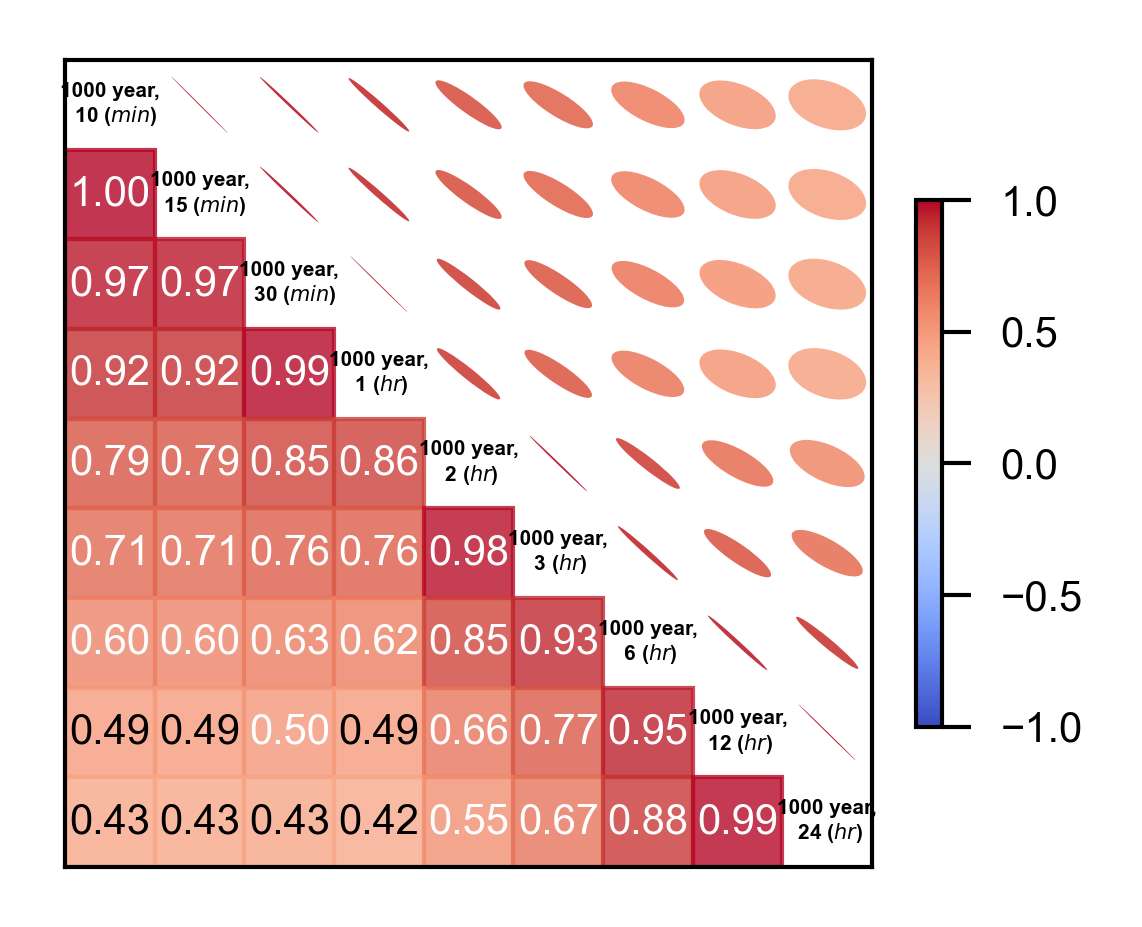

In [70]:
# Function to draw an ellipse based on correlation
def draw_ellipse(ax, x, y, correlation, cmap, norm):
    color = cmap(norm(correlation))  # Get color from colormap
    angle = 45 * correlation  # Rotate based on correlation
    min_height = 0.01  # Minimum height for visibility
    height = max(min_height, 0.9 * (1 - abs(correlation)))  # Ensure a minimum ellipse height
    width = 0.9  # Keep width constant
    ellipse = Ellipse((x, y), width=width, height=height, angle=angle, 
                      facecolor=color, edgecolor='none', linewidth=0.5, alpha=0.9)
    ax.add_patch(ellipse)
# Function to plot the custom correlation matrix
def custom_corrplot(data,rp, save_path=None):
    corr = data.corr()  # Compute correlation matrix
    # Define a mapping of original column names to desired labels
    label_mapping = {
        f'rain_{rp}_10m_a': f'{rp} year,\n  10 ($min$)',
        f'rain_{rp}_15m_a': f'{rp} year,\n  15 ($min$)',
        f'rain_{rp}_30m_a': f'{rp} year,\n  30 ($min$)',
        f'rain_{rp}_60m_a': f'{rp} year,\n 1 ($hr$)',
        f'rain_{rp}_02h_a': f'{rp} year,\n 2 ($hr$)',
        f'rain_{rp}_03h_a': f'{rp} year,\n 3 ($hr$)',
        f'rain_{rp}_06h_a': f'{rp} year,\n 6 ($hr$)',
        f'rain_{rp}_12h_a': f'{rp} year,\n 12 ($hr$)',
        f'rain_{rp}_24h_a': f'{rp} year,\n 24 ($hr$)'
    }
    # Update the correlation matrix labels
    corr = corr.rename(columns=label_mapping, index=label_mapping)
    labels = corr.columns.tolist()  # Updated variable names with new labels
    # Set figure size to be square (3x3 inches)
    fig, ax = plt.subplots(figsize=(2, 2), dpi=600)  # Set figure size and resolution
    ax.set_xlim(-0.5, len(labels) - 0.5)
    ax.set_ylim(-0.5, len(labels) - 0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    # Define colormap
    cmap = cm.get_cmap("coolwarm")
    norm = Normalize(vmin=-1, vmax=1)
    # Plot elements
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:
                # Diagonal: Show variable names
                ax.text(j, i, labels[i], ha='center', va='center', fontsize=2.5,fontweight='bold' )
            elif i > j:
                # Lower triangle: Heatmap with correlation coefficients
                color = cmap(norm(corr.iloc[i, j]))
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=color, alpha=0.8, linewidth=0.5))  # Reduced border width
                ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', fontsize=5,
                        color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')
            else:
                # Upper triangle: Colored Ellipse representation
                draw_ellipse(ax, j, i, corr.iloc[i, j], cmap, norm)
    # Create heatmap color legend with the same height as the plot
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.05)
    cbar.ax.tick_params(labelsize=5, width=0.5)
    cbar.outline.set_linewidth(0.5)
    # Reduce plot border width
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # Set the plot border width to 0.5
    # Set aspect ratio of plot to be equal (square)
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()  # Ensure layout fits well
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, format='tiff', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
for rp in return_periods:
    # Select only the rainfall columns of interest
    rain_subset = culvert[[f'rain_{rp}_10m_a', f'rain_{rp}_15m_a', f'rain_{rp}_30m_a',f'rain_{rp}_60m_a',
                           f'rain_{rp}_02h_a',f'rain_{rp}_03h_a',f'rain_{rp}_06h_a',f'rain_{rp}_12h_a',f'rain_{rp}_24h_a']]
    # Generate and save the correlation plot
    custom_corrplot(rain_subset,rp=rp, save_path=rf"D:\culvert repo\Results\Figures\correlation_plots_rainfall_durations\{rp}_year_rain_correlation_plot.png")

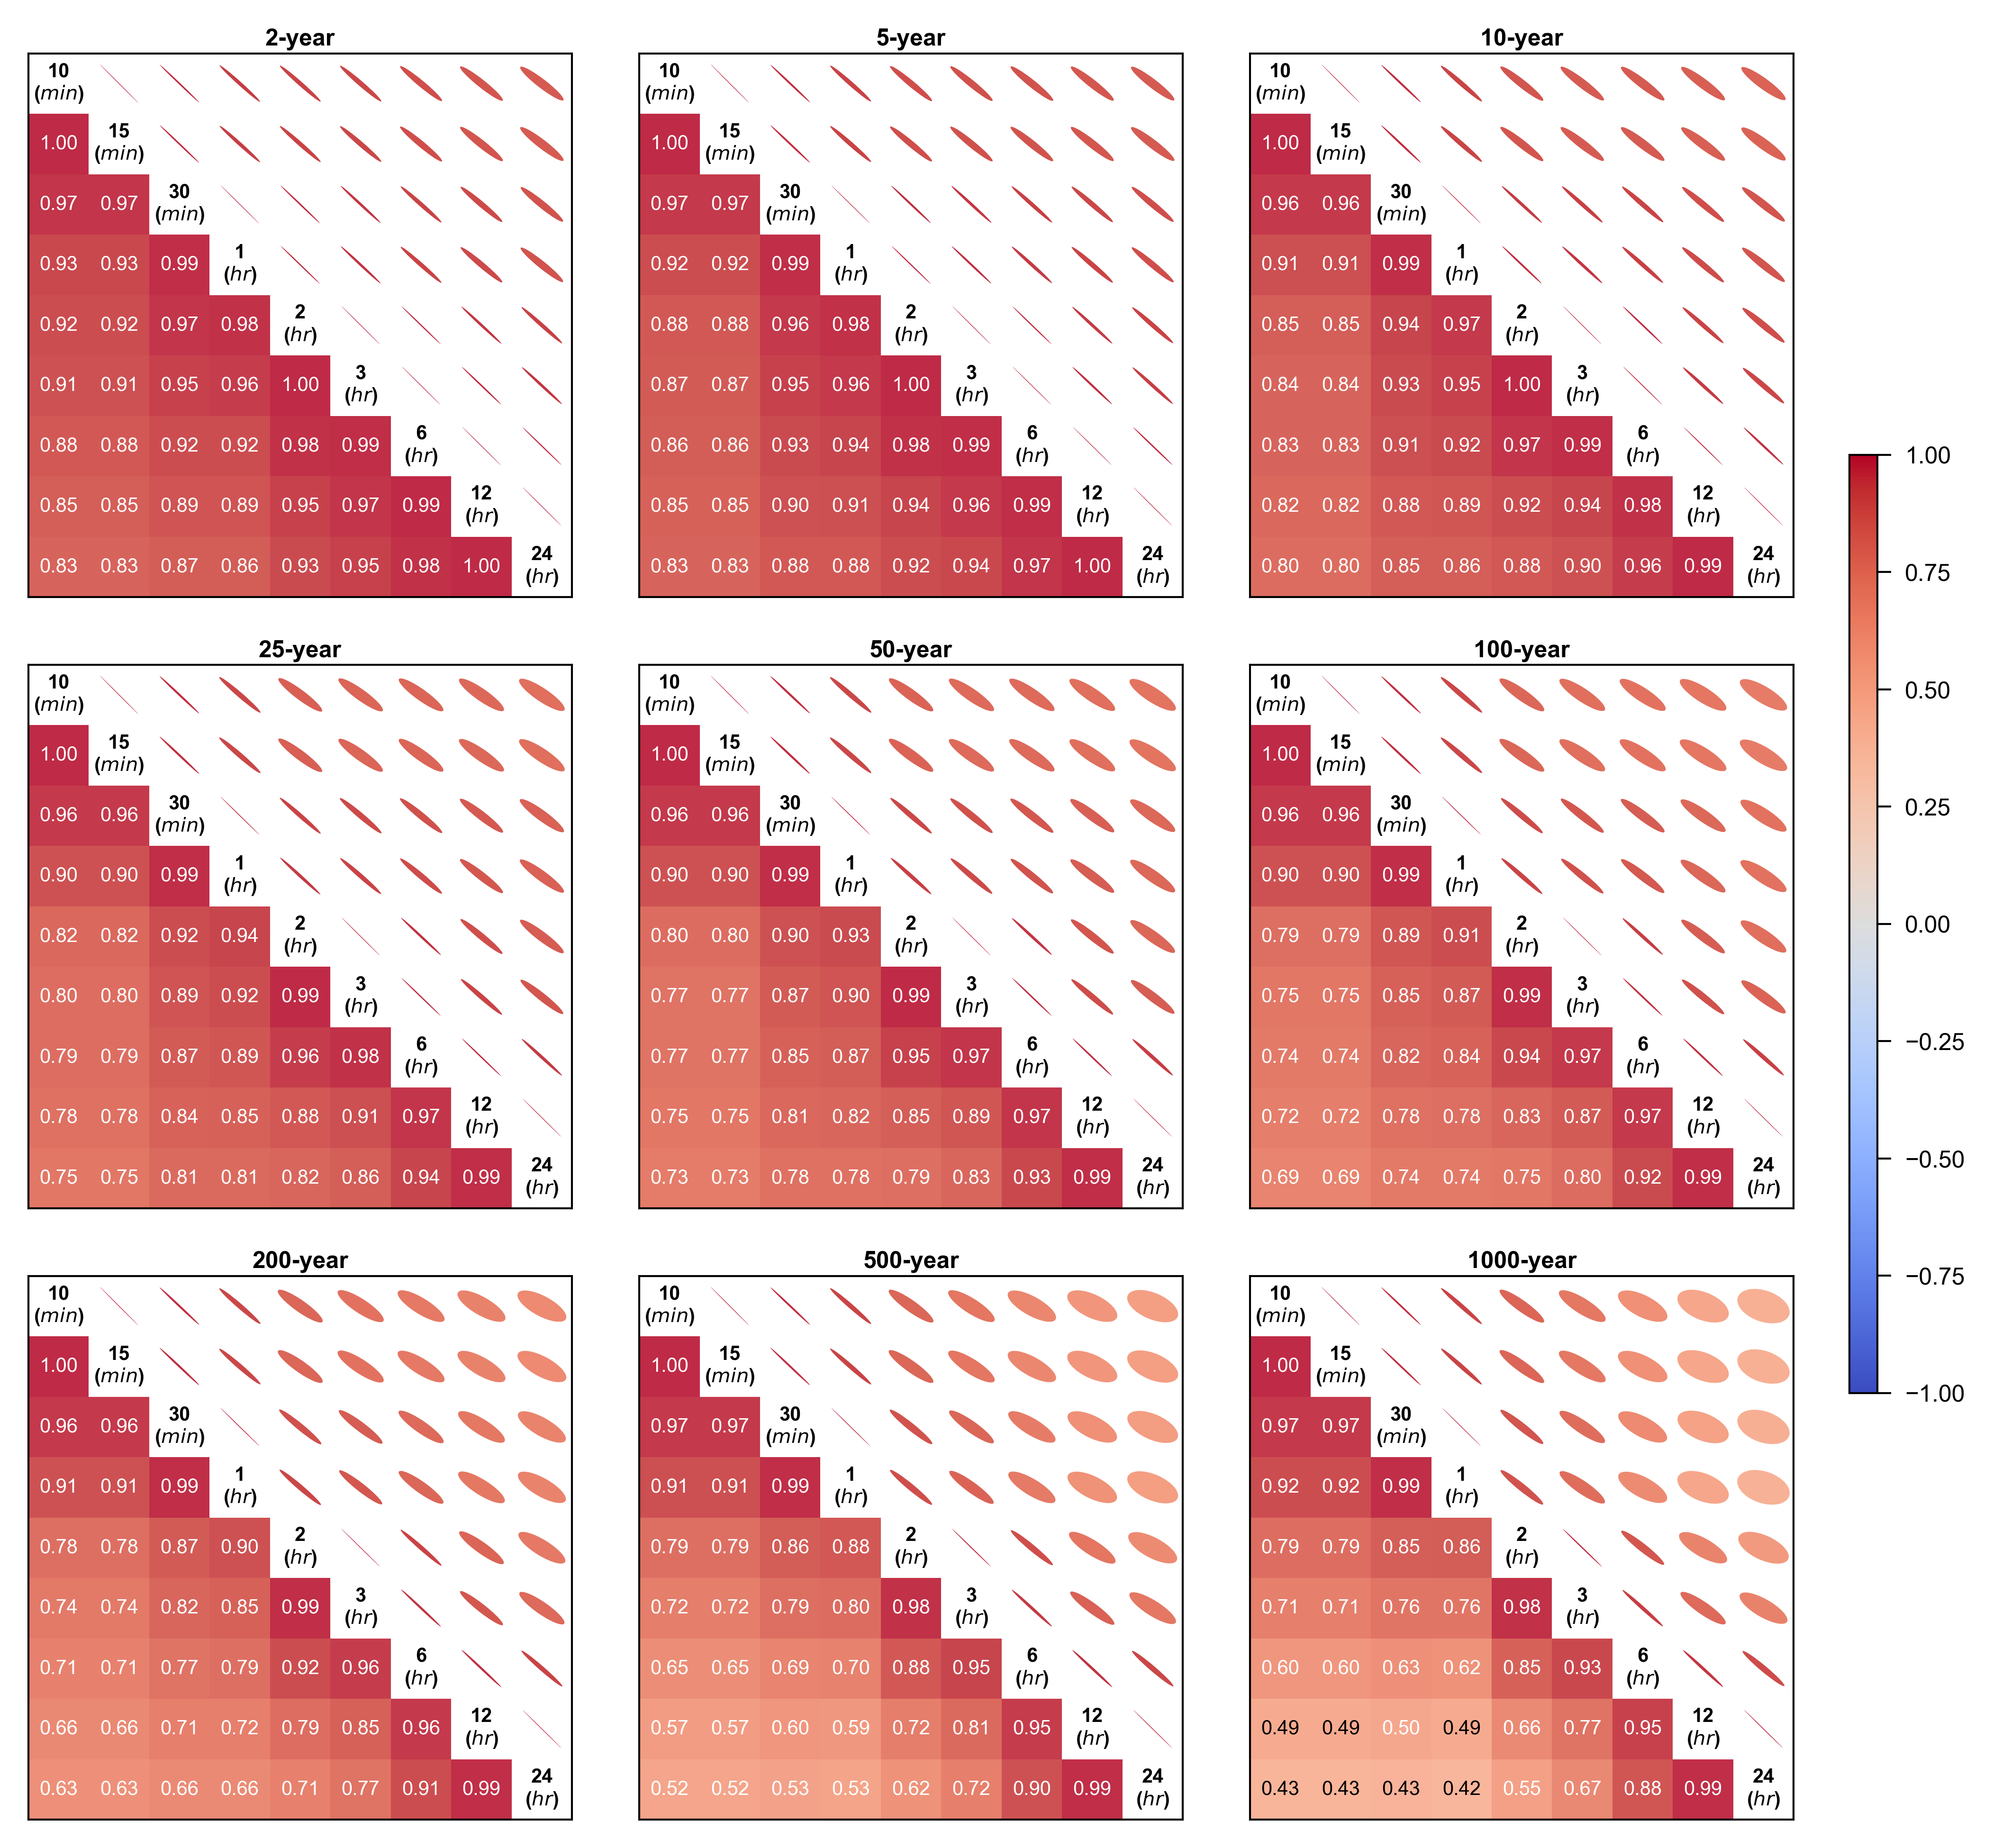

In [85]:
from matplotlib.patches import Ellipse, Rectangle
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def draw_ellipse(ax, x, y, correlation, cmap, norm):
    color = cmap(norm(correlation))
    angle = 45 * correlation
    min_height = 0.01
    height = max(min_height, 0.9 * (1 - abs(correlation)))
    width = 0.9
    e = Ellipse((x, y), width=width, height=height, angle=angle,
                facecolor=color, edgecolor='none', linewidth=0.5, alpha=0.9)
    ax.add_patch(e)

def plot_corr_panel(ax, data, rp, cmap, norm):
    # labels
    label_mapping = {
        f'rain_{rp}_10m_a':  f'10\n($min$)',
        f'rain_{rp}_15m_a':  f'15\n($min$)',
        f'rain_{rp}_30m_a':  f'30\n($min$)',
        f'rain_{rp}_60m_a':  f'1\n($hr$)',
        f'rain_{rp}_02h_a':  f'2\n($hr$)',
        f'rain_{rp}_03h_a':  f'3\n($hr$)',
        f'rain_{rp}_06h_a':  f'6\n($hr$)',
        f'rain_{rp}_12h_a':  f'12\n($hr$)',
        f'rain_{rp}_24h_a':  f'24\n($hr$)',
    }

    corr = data.corr().rename(columns=label_mapping, index=label_mapping)
    labels = corr.columns.tolist()
    n = len(labels)

    ax.set_xlim(-0.5, n-0.5)
    ax.set_ylim(-0.5, n-0.5)
    ax.set_xticks([]); ax.set_yticks([])
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    # thin border
    for s in ax.spines.values():
        s.set_linewidth(0.5)

    # draw cells
    for i in range(n):
        for j in range(n):
            if i == j:
                ax.text(j, i, labels[i], ha='center', va='center',
                        fontsize=5.0, fontweight='bold')
            elif i > j:
                color = cmap(norm(corr.iloc[i, j]))
                ax.add_patch(Rectangle((j-0.5, i-0.5), 1, 1,
                                       facecolor=color, alpha=0.85, linewidth=0.3))
                ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center',
                        fontsize=5, color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')
            else:
                draw_ellipse(ax, j, i, corr.iloc[i, j], cmap, norm)

    # small panel title
    ax.set_title(f"{rp}-year", fontsize=6, pad=2, weight='bold')

# ---------- build the combined figure ----------
return_periods = ['2','5','10','25','50','100','200','500','1000']
n = len(return_periods)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(2.2*ncols, 2.2*nrows), dpi=600)
axes = np.atleast_2d(axes)

cmap = cm.get_cmap("coolwarm")
norm = Normalize(vmin=-1, vmax=1)

for idx, rp in enumerate(return_periods):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]
    # subset columns for this rp
    cols = [f'rain_{rp}_10m_a', f'rain_{rp}_15m_a', f'rain_{rp}_30m_a', f'rain_{rp}_60m_a',
            f'rain_{rp}_02h_a', f'rain_{rp}_03h_a', f'rain_{rp}_06h_a', f'rain_{rp}_12h_a', f'rain_{rp}_24h_a']
    rain_subset = culvert[cols]
    plot_corr_panel(ax, rain_subset, rp, cmap, norm)

# hide any unused axes (if any)
for k in range(n, nrows*ncols):
    r, c = divmod(k, ncols)
    axes[r, c].set_visible(False)

# ----- shared colorbar OUTSIDE the subplot grid -----
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# First, tighten the grid but reserve room on the right for the colorbar
#plt.tight_layout(rect=[0, 0, 0.92, 1])   # leave ~8% width on the right

# Add a small axis for the colorbar, fully outside the grid
cax = fig.add_axes([1, 0.25, 0.015, 0.5])  # [left, bottom, width, height] in figure coords
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=6, width=0.5)
cbar.outline.set_linewidth(0.5)

plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\correlation_plots_rainfall_durations\ALL_years_rain_correlation_grid_paper.png",
            dpi=600, bbox_inches='tight', transparent=True)
plt.show()


### Linear regression model to estimate 5 min, 15min, and 30 min rainfall from 60 min rainfall

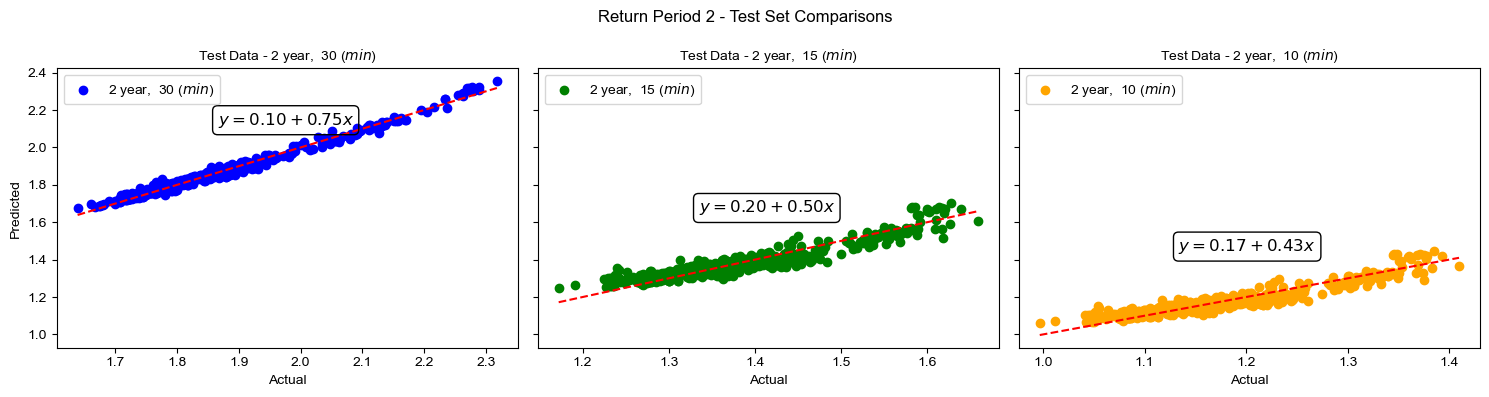

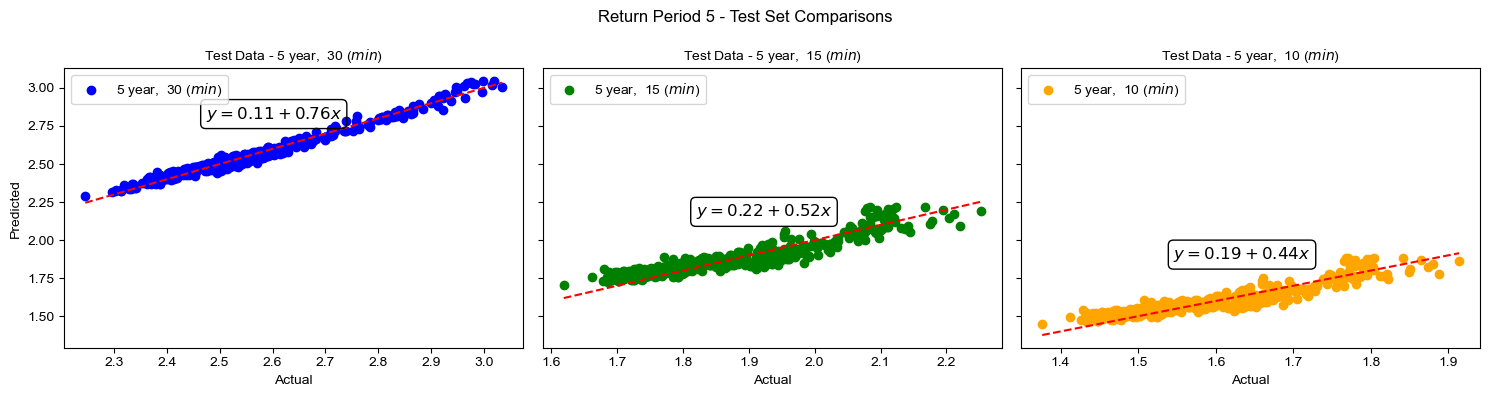

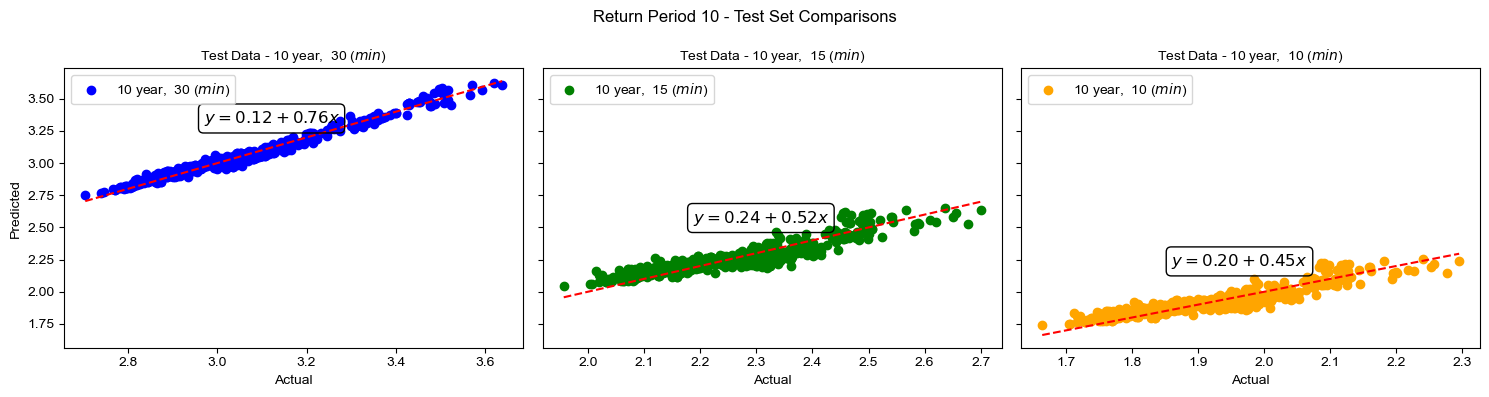

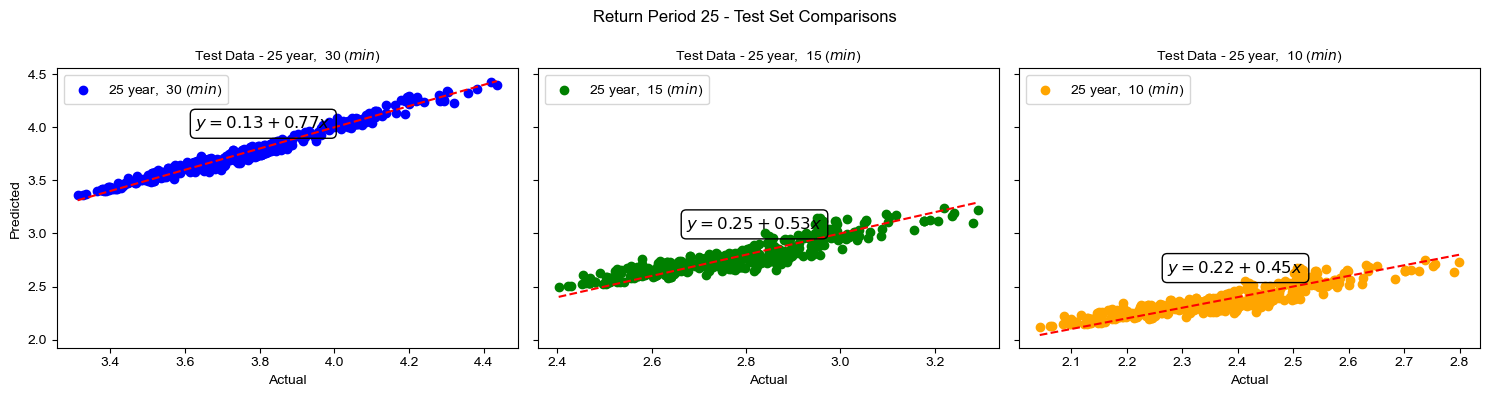

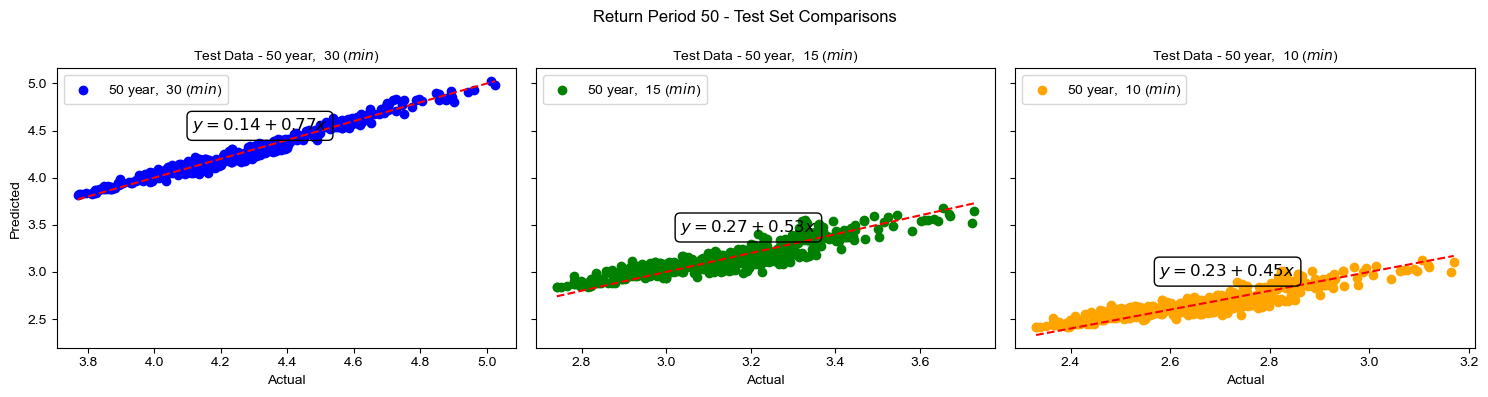

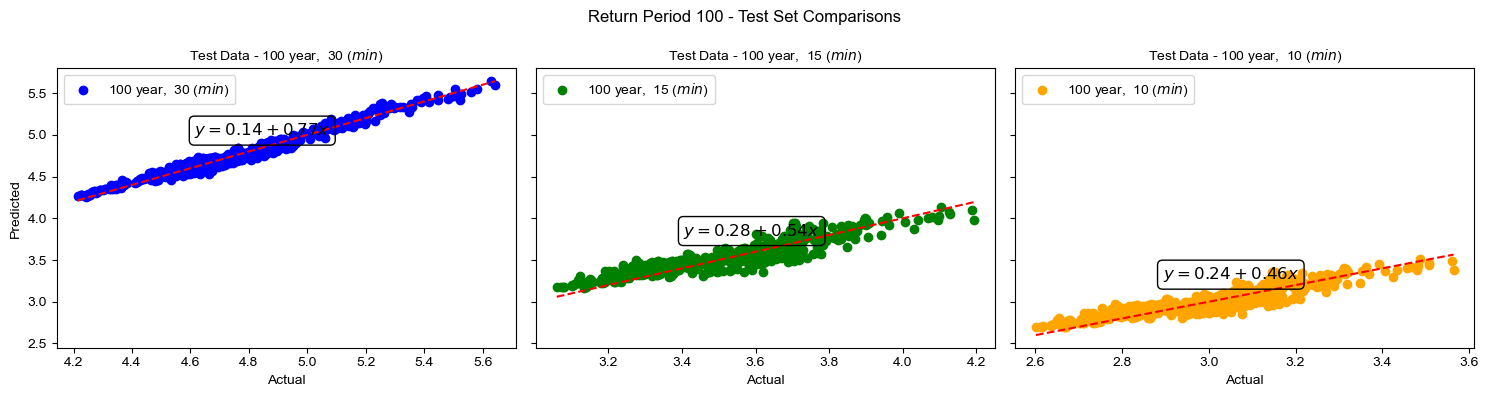

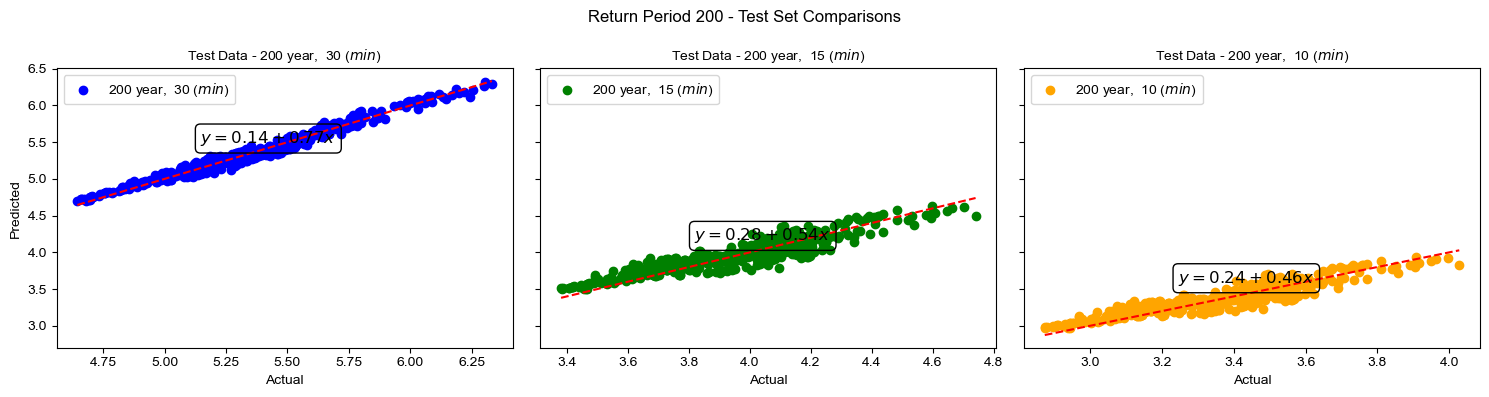

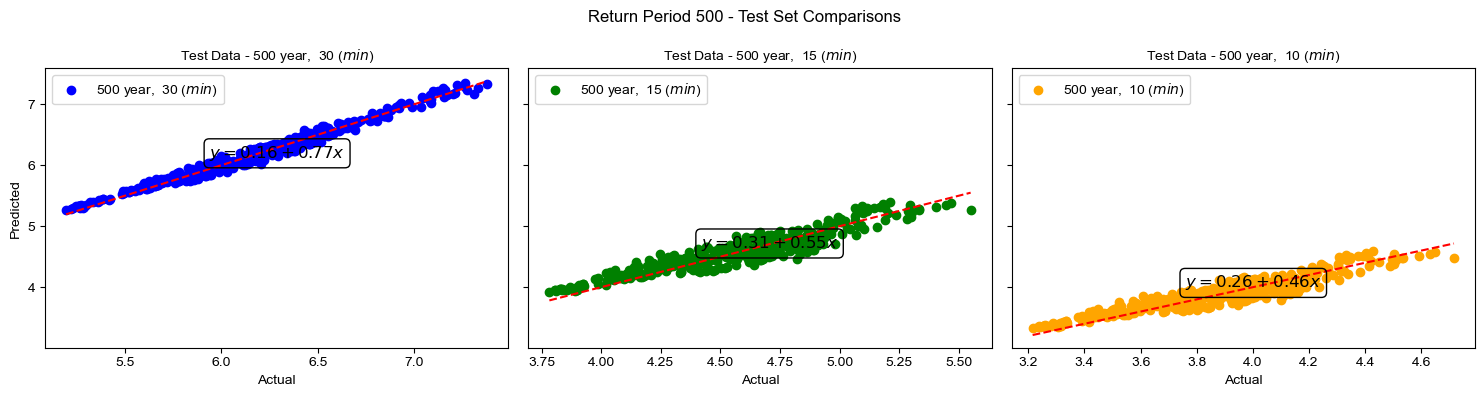

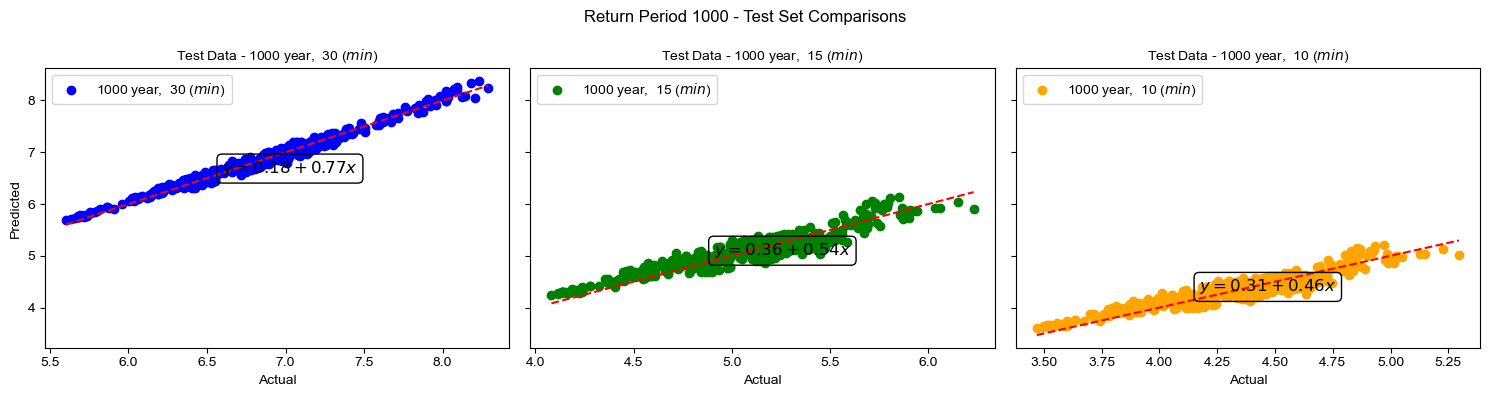

Return Period Target Duration  β₀ (intercept)  β₁ (slope)        R²  \
0              2             30m        0.100224    0.749772  0.984002   
1              2             15m        0.197655    0.500546  0.875420   
2              2             10m        0.167550    0.425619  0.875621   
3              5             30m        0.112175    0.757487  0.977831   
4              5             15m        0.223930    0.515112  0.841067   
5              5             10m        0.190443    0.437808  0.841062   
6             10             30m        0.117943    0.761985  0.975104   
7             10             15m        0.236114    0.523923  0.828321   
8             10             10m        0.200390    0.445414  0.828252   
9             25             30m        0.127178    0.765674  0.973218   
10            25             15m        0.251066    0.532142  0.822153   
11            25             10m        0.217657    0.451365  0.821930   
12            50             30m        0.136530    0.767225  0.972885   
13            50             15m        0.272463    0.534558  0.819655   
14            50             10m        0.231801    0.454339  0.819749   
15           100             30m        0.142606    0.769095  0.972968   
16           100             15m        0.284697    0.538274  0.821305   
17           100             10m        0.241811    0.457562  0.821399   
18           200             30m        0.141977    0.771847  0.974371   
19           200             15m        0.284476    0.543610  0.830849   
20           200             10m        0.241497    0.462113  0.830925   
21           500             30m        0.155084    0.773105  0.977603   
22           500             15m        0.309654    0.546274  0.849886   
23           500             10m        0.263265    0.464321  0.849989   
24          1000             30m        0.182261    0.772026  0.980309   
25          1000             15m        0.364355    0.544077  0.865296   
26          1000             10m        0.309879    0.462444  0.865276   

         MSE  
0   0.000322  
1   0.001300  
2   0.000938  
3   0.000585  
4   0.002343  
5   0.001694  
6   0.000863  
7   0.003454  
8   0.002497  
9   0.001348  
10  0.005345  
11  0.003850  
12  0.001770  
13  0.007080  
14  0.005110  
15  0.002280  
16  0.009121  
17  0.006584  
18  0.002901  
19  0.011606  
20  0.008378  
21  0.004003  
22  0.016022  
23  0.011565  
24  0.005192  
25  0.020770  
26  0.015007

In [86]:
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
coes_list = []
for rp in return_periods:
    label_mapping = {
        f'rain_{rp}_10m_a': f'{rp} year,  10 ($min$)',
        f'rain_{rp}_15m_a': f'{rp} year,  15 ($min$)',
        f'rain_{rp}_30m_a': f'{rp} year,  30 ($min$)',
        f'rain_{rp}_60m_a': f'{rp} year, 1 ($hr$)',
        f'rain_{rp}_02h_a': f'{rp} year, 2 ($hr$)',
        f'rain_{rp}_03h_a': f'{rp} year, 3 ($hr$)',
        f'rain_{rp}_06h_a': f'{rp} year, 6 ($hr$)',
        f'rain_{rp}_12h_a': f'{rp} year, 12 ($hr$)',
        f'rain_{rp}_24h_a': f'{rp} year, 24 ($hr$)'
    }
    dependent_variables = [f'rain_{rp}_30m_a', f'rain_{rp}_15m_a', f'rain_{rp}_10m_a']
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for i, dep_var in enumerate(dependent_variables):
        y = culvert[[dep_var]].values
        X = culvert[[f'rain_{rp}_60m_a']].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        beta_0 = model.intercept_[0]
        beta_1 = model.coef_[0][0]
        # Collect coefficients
        coes_list.append({
            "Return Period": rp,
            "Target Duration": dep_var.split('_')[2],  # 05m, 15m, 30m
            "β₀ (intercept)": beta_0,
            "β₁ (slope)": beta_1,
            "R²": r2_score(y_test, y_test_pred),
            "MSE": mean_squared_error(y_test, y_test_pred)
        })
        # Plotting
        formula = rf"$y = {beta_0:.2f} + {beta_1:.2f} x$"
        ax = axes[i]
        ax.scatter(y_test, y_test_pred, color=['blue', 'green', 'orange'][i], label=f'{label_mapping[dep_var]}')
        ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
        x_pos = max(y_test) * 0.9
        y_pos = min(y_test_pred) * 1.1
        ax.text(x_pos, y_pos+0.25, formula, color='black', fontsize=12, ha='right', va='bottom',
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
        ax.set_title(f'Test Data - {label_mapping[dep_var]}')
        ax.set_xlabel('Actual')
        if i == 0:
            ax.set_ylabel('Predicted')
        ax.legend(loc='upper left')
    plt.suptitle(f"Return Period {rp} - Test Set Comparisons")
    plt.tight_layout()
    plt.show()

# Convert to DataFrame
coes = pd.DataFrame(coes_list)
coes

#### Assign the nearest station's projected rainfall to each culvert

In [73]:
station = pd.read_excel(r"D:\culvert repo\data\Future Rainfall\rainfall_station_characteristics.xlsx")
station

Station ID Country State                Station Name  Lat (°N)  \
0         060806      US    CT  BRIDGEPORT SIKORSKY MEM AP     41.16   
1         061762      US    CT                     DANBURY     41.40   
2         062658      US    CT               FALLS VILLAGE     41.95   
3         063207      US    CT                      GROTON     41.35   
4         065445      US    CT                NORFOLK 2 SW     41.97   
..           ...     ...   ...                         ...       ...   
152  CA007025745      CA    QC                    ORMSTOWN     45.12   
153  CA007026040      CA    QC                 PHILIPSBURG     45.03   
154  CA007026836      CA    QC                 ST ANICET 1     45.12   
155  CA007027040      CA    QC                STE CLOTILDE     45.17   
156  CA007028680      CA    QC                 VALLEYFIELD     45.23   

     Lon (°E)  Elev (ft)  2-yr_2010-2039_rcp45_1  2-yr_2010-2039_rcp45_2  \
0      -73.13          5                1.485028                1.841016   
1      -73.42        405                1.734625                2.149316   
2      -73.37        550                1.229862                1.523894   
3      -72.04         40                1.451256                1.798357   
4      -73.22       1340                1.423794                1.764132   
..        ...        ...                     ...                     ...   
152    -74.05        150                0.927940                1.149900   
153    -73.08        173                0.831654                1.030147   
154    -74.28        154                0.922897                1.143953   
155    -73.68        170                1.081902                1.340897   
156    -74.10        150                0.948717                1.175455   

     2-yr_2010-2039_rcp45_3  ...  100-yr_2070-2099_rcp45_12  \
0                  2.087603  ...                   8.882938   
1                  2.436447  ...                   9.724692   
2                  1.727483  ...                   6.741469   
3                  2.038706  ...                   8.619218   
4                  1.999778  ...                   7.791655   
..                      ...  ...                        ...   
152                1.303598  ...                   4.897259   
153                1.167550  ...                   4.401337   
154                1.297056  ...                   4.885579   
155                1.520261  ...                   5.336541   
156                1.332441  ...                   5.023991   

     100-yr_2070-2099_rcp45_18  100-yr_2070-2099_rcp45_24  \
0                    10.070550                  11.008271   
1                    11.025448                  12.052554   
2                     7.643596                   8.355967   
3                     9.771479                  10.681280   
4                     8.834506                   9.658016   
..                         ...                        ...   
152                   5.551132                   6.067351   
153                   4.990359                   5.455488   
154                   5.539393                   6.055684   
155                   6.049725                   6.612822   
156                   5.695946                   6.226533   

     100-yr_2070-2099_rcp85_1  100-yr_2070-2099_rcp85_2  \
0                    4.417691                  5.474386   
1                    4.802863                  5.952129   
2                    3.333051                  4.131050   
3                    4.273381                  5.295847   
4                    3.855777                  4.779285   
..                        ...                       ...   
152                  2.420079                  2.998204   
153                  2.202959                  2.730185   
154                  2.407771                  2.984462   
155                  2.657947                  3.293507   
156                  2.479024                  3.072197   

     100-yr_2070-2099_rcp85_3

In [74]:
# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # Distance in kilometers
# Function to find the nearest station for a single culvert row
def find_nearest_station(row):
    distances = haversine(row['Ini_lat'], row['Ini_lon'], station['Lat (°N)'], station['Lon (°E)'])
    nearest_index = np.argmin(distances)
    return station.loc[nearest_index, 'Station ID']
# Apply to each row
culvert['Nearest_Station_ID'] = culvert.apply(find_nearest_station, axis=1)

In [75]:
culvert = culvert.drop(columns=['Nearest_Station_ID'], errors='ignore')

In [76]:
# Generate all rainfall column names
rainfall_cols = []
for rp in ['2-yr','5-yr','10-yr','25-yr','50-yr','100-yr']:
    for time in ['2010-2039','2040-2069','2070-2099']:
        for scenario in ['rcp45','rcp85']:
            for duration in [1,2,3,6,12,18,24]:
                rainfall_cols.append(f"{rp}_{time}_{scenario}_{duration}")
# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c
# Match each culvert to the nearest station and copy rainfall data
def match_station_and_rainfall(row):
    distances = haversine(row['Ini_lat'], row['Ini_lon'], station['Lat (°N)'], station['Lon (°E)'])
    nearest_idx = np.argmin(distances)
    nearest_station = station.iloc[nearest_idx]
    result = {'Nearest_Station_ID': nearest_station['Station ID']}
    for col in rainfall_cols:
        if col in station.columns:
            result[col] = nearest_station[col]* 2.54
    return pd.Series(result)
# Apply the matching
culvert = culvert.join(culvert.apply(match_station_and_rainfall, axis=1))
#culvert = pd.concat([culvert, culvert.apply(match_station_and_rainfall, axis=1)], axis=1)


In [77]:
#### calculate the 5, 15, and 30-minute rainfall from 1 hr
# Map durations (in hours) to their short-duration labels in Coes
duration_mapping = {
    '0.5': '30m',
    '0.25': '15m',
    '0.17': '10m'
}
# Loop over all RP/Time/Scenario combinations
for rp in ['2-yr','5-yr','10-yr','25-yr','50-yr','100-yr']:
    for time in ['2010-2039','2040-2069','2070-2099']:
        for scenario in ['rcp45','rcp85']:
            # Get the 1-hour column
            one_hr_col = f"{rp}_{time}_{scenario}_1"
            # Skip if that column doesn't exist
            if one_hr_col not in culvert.columns:
                continue
            one_hr_vals = culvert[one_hr_col]
            # Predict 5min, 15min, 30min from 1-hr rainfall using coes
            for new_dur, coes_dur in duration_mapping.items():
                # Match coes row
                row = coes[(coes["Return Period"] == rp.split('-')[0]) & (coes["Target Duration"] == coes_dur)]
                if row.empty:
                    continue
                beta_0 = row["β₀ (intercept)"].values[0]
                beta_1 = row["β₁ (slope)"].values[0]
                # Predict and assign
                pred_col = f"{rp}_{time}_{scenario}_{new_dur}"
                culvert[pred_col] = beta_0 + beta_1 * one_hr_vals

In [78]:
# Define the output file path for Excel
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain.xlsx'
# Save the DataFrame to an Excel file
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain.xlsx


In [79]:
culvert=pd.read_excel(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain.xlsx')

In [80]:
# future Q 
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize dictionary to store max discharge for each return period
    max_discharges = {}
    for time in ['2010-2039','2040-2069','2070-2099']:
            for scenario in ['rcp45','rcp85']:
                max_dis = 0
                for period in return_periods:
                    rp=str(period)+'-yr'
                 # Loop through each interval
                    for idx, interval in enumerate(intervals):
                        # Set depth data (assuming the correct attributes are in `culvert`)
                        # Use getattr to dynamically access the attribute based on the period
                        depth = [
                            getattr(culvert, f"{rp}_{time}_{scenario}_0.17"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_0.25"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_0.5"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_1"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_2"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_3"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_6"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_12"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_24")
                        ]
                        # Compute and normalize rainfall for each interval
                        rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
                        normalized_intervals[interval]= incremental_rainfall(rainfall)
                        # Calculate excess rainfall for each interval
                        result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=culvert.CN_wet)
                        # Extract relevant data for discharge calculation
                        df = result_df[['Time', 'Incremental Excess (mm)']]
                        # Determine time step based on interval
                        time_step = 5 if interval < 0.5 else 6
                        # Generate unit hydrograph
                        intervals_1, discharge_values = construct_unit_hydrograph(
                            culvert.t_c_CN_wet, culvert.Area / 10**6, time_step / 60, time_step
                        )
                        unit_hydrograph = np.array(discharge_values)
                        # Calculate total discharge for this interval
                        discharge = calculate_total_discharge(df, unit_hydrograph)
                        # Get the total discharge column
                        total_discharge = discharge['Total Discharge']
                        # Find the maximum discharge value for the current interval
                        max_discharge_index = total_discharge.idxmax()
                        max_discharge_row = discharge.iloc[max_discharge_index]
                        # Check if the third-to-last element is non-zero and update max discharge if needed
                        if max_discharge_row[-3] != 0:
                            max_dis = max(max_dis, max_discharge_row[-1])
                    # Store the max discharge for this return period in the dictionary
                    max_discharges[f'Q_{period}_{time}_{scenario}'] = max_dis
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100]
def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 2381/2381 [1:02:58<00:00,  1.59s/it]


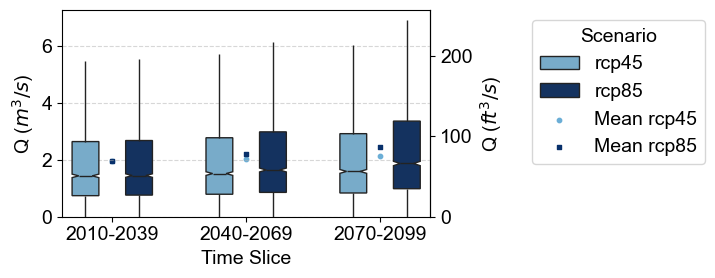

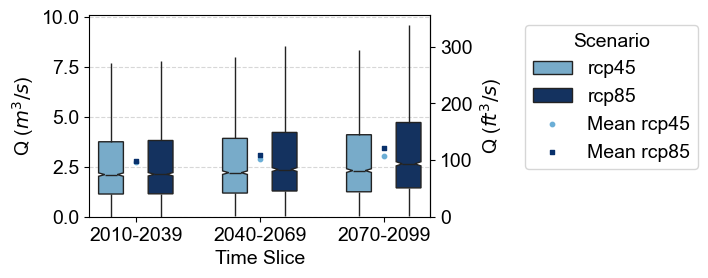

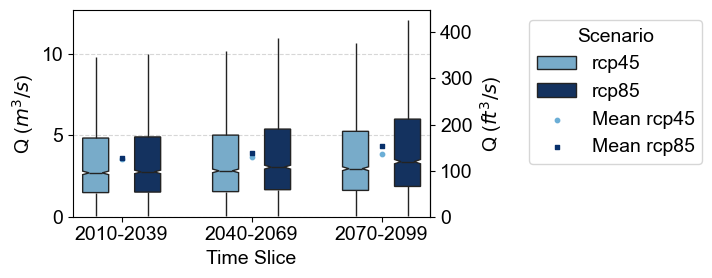

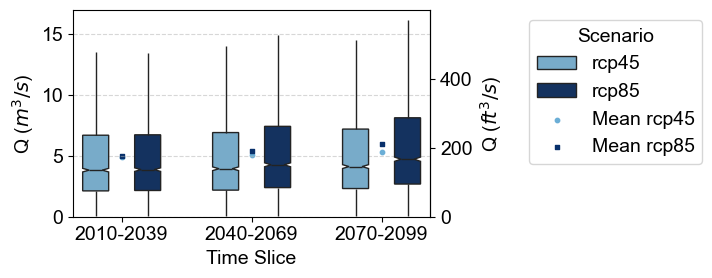

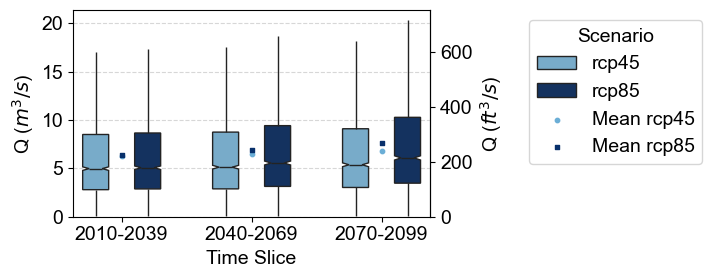

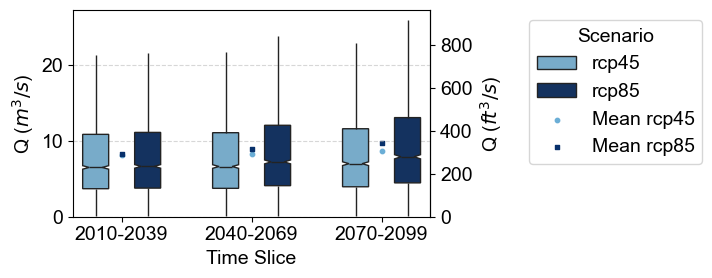

In [81]:
# Define parameters
return_periods = ['2','5','10','25','50','100']
time_slices = ['2010-2039','2040-2069','2070-2099']
scenarios = ['rcp45','rcp85']
# Set consistent color palette and markers for scenarios
palette = {'rcp45': '#6baed6', 'rcp85': '#08306b'}
markers = {'rcp45': 'o', 'rcp85': 's'}
# Plot each return period in its own plot
for rp in return_periods:
    # Prepare long-form data
    data = {'Time': [], 'Scenario': [], 'Q Value': []}
    mean_data = {'Time': [], 'Scenario': [], 'Mean Q': []}

    for time in time_slices:
        for scenario in scenarios:
            col = f'Q_{rp}_{time}_{scenario}'
            if col not in culvert_Q.columns:
                continue
            q_values = culvert_Q[col].dropna()
            for val in q_values:
                data['Time'].append(time)
                data['Scenario'].append(scenario)
                data['Q Value'].append(val)
            mean_data['Time'].append(time)
            mean_data['Scenario'].append(scenario)
            mean_data['Mean Q'].append(q_values.mean())
    # Create DataFrames
    df_box = pd.DataFrame(data)
    df_mean = pd.DataFrame(mean_data)
    # Set Time as categorical for ordering
    df_box['Time'] = pd.Categorical(df_box['Time'], categories=time_slices, ordered=True)
    df_mean['Time'] = pd.Categorical(df_mean['Time'], categories=time_slices, ordered=True)
    # Setup plot
    plt.figure(figsize=(8, 3))
    ax = sns.boxplot(data=df_box, x='Time', y='Q Value', hue='Scenario',
                    palette=[palette[s] for s in scenarios], showfliers=False,
                    notch=True, showcaps=False, gap=0.5)

    # Add mean points
    for scenario in scenarios:
        subset = df_mean[df_mean['Scenario'] == scenario]
        subset = subset.sort_values("Time")  # Ensure correct order
        x_ticks = subset['Time'].cat.codes  # Convert categorical 'Time' to numeric positions
        ax.scatter(x_ticks, subset['Mean Q'], marker=markers[scenario], s=10,
                label=f'Mean {scenario}', color=palette[scenario])

    # Axis styling
    ax.set_xticks(np.arange(len(time_slices)))
    ax.set_xticklabels(time_slices)
    ax.set_ylabel("Q ($m^3/s$)")
    ax.set_xlabel("Time Slice")
    ax.set_ylim(0, None)
    ax.grid(axis='y', which='major', linestyle="--", alpha=0.5)

    # Add secondary y-axis for ft³/s
    def m3s_to_ft3s(x): return x * 35.3147
    def ft3s_to_m3s(x): return x / 35.3147

    secax = ax.secondary_yaxis('right', functions=(m3s_to_ft3s, ft3s_to_m3s))
    secax.set_ylabel("Q ($ft^3/s$)")

    # Legend and layout
    plt.legend(title="Scenario", loc="upper left", bbox_to_anchor=(1.25, 1))
    plt.tight_layout()

    # Save and show
    plt.savefig(fr"D:\culvert repo\Results\Figures\Q_{rp}_distribution_2010_2099.png", dpi=300, bbox_inches='tight')
    plt.show()

In [82]:
# Define the output file path for Excel
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rainandQ.xlsx'
# Save the DataFrame to an Excel file
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rainandQ.xlsx


# Joint effect of projected rianfall and land use

In [83]:
scenarios = ['A2', 'B2']
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize dictionary to store max discharge for each return period
    max_discharges = {}
    # Iterate over each return period
    for scenario in scenarios:
            for year in years:
                for ASM in ['Wet']:
                    #
                    if scenario=='A2':
                        scen='rcp85'
                    else:
                        scen='rcp45'
                    #
                    if year <2040:
                        time='2010-2039'
                    elif year <2070:
                        time='2040-2069'
                    else :
                        time='2070-2099' 
                    #    
                    max_dis = 0   
                    for period in return_periods:
                        rp=str(period)+'-yr'
                    # Loop through each interval
                        for idx, interval in enumerate(intervals):
                            # Set depth data (assuming the correct attributes are in `culvert`)
                            # Use getattr to dynamically access the attribute based on the period
                            depth = [
                                getattr(culvert, f"{rp}_{time}_{scen}_0.17"),
                                getattr(culvert, f"{rp}_{time}_{scen}_0.25"),
                                getattr(culvert, f"{rp}_{time}_{scen}_0.5"),
                                getattr(culvert, f"{rp}_{time}_{scen}_1"),
                                getattr(culvert, f"{rp}_{time}_{scen}_2"),
                                getattr(culvert, f"{rp}_{time}_{scen}_3"),
                                getattr(culvert, f"{rp}_{time}_{scen}_6"),
                                getattr(culvert, f"{rp}_{time}_{scen}_12"),
                                getattr(culvert, f"{rp}_{time}_{scen}_24")
                            ]
                            # Compute and normalize rainfall for each interval
                            rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
                            normalized_intervals[interval]= incremental_rainfall(rainfall)
                            # Calculate excess rainfall for each interval
                            result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=culvert[f'CN_{year}_{scenario}_{ASM}'])
                            # Extract relevant data for discharge calculation
                            df = result_df[['Time', 'Incremental Excess (mm)']]
                            # Determine time step based on interval
                            time_step = 5 if interval < 0.5 else 6
                            # Generate unit hydrograph
                            intervals_1, discharge_values = construct_unit_hydrograph(
                                culvert[f't_CN_{year}_{scenario}_{ASM}'], culvert.Area / 10**6, time_step / 60, time_step
                            )
                            unit_hydrograph = np.array(discharge_values)
                            # Calculate total discharge for this interval
                            discharge = calculate_total_discharge(df, unit_hydrograph)
                            # Get the total discharge column
                            total_discharge = discharge['Total Discharge']
                            # Find the maximum discharge value for the current interval
                            max_discharge_index = total_discharge.idxmax()
                            max_discharge_row = discharge.iloc[max_discharge_index]
                            # Check if the third-to-last element is non-zero and update max discharge if needed
                            if max_discharge_row[-3] != 0:
                                max_dis = max(max_dis, max_discharge_row[-1])
                        # Store the max discharge for this return period in the dictionary
                        max_discharges[f'Q_{period}_{year}_{scenario}_{ASM}_fr'] = max_dis
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100]
def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 2381/2381 [2:04:15<00:00,  3.13s/it]


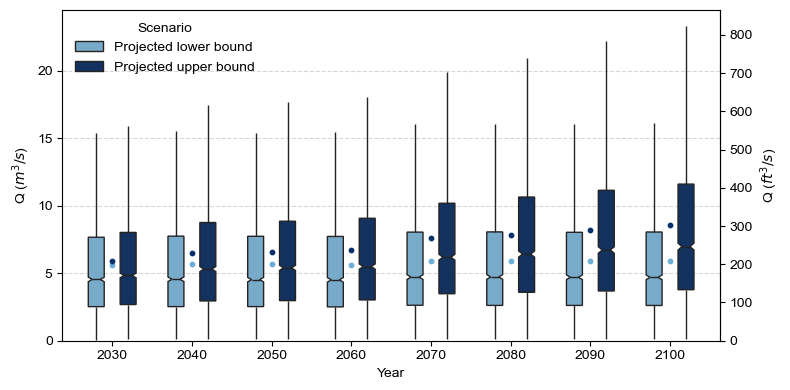

In [59]:
# Settings
rp = '50'  # Choose one return period to plot
scenarios = ['A2', 'B2']
rcp_mapping = {'A2': 'rcp85', 'B2': 'rcp45'}
colors = {'rcp45': '#6baed6', 'rcp85': '#08306b'}
markers = {'rcp45': 'o', 'rcp85': 'o'}
hue_order = ['rcp45', 'rcp85']
legend_labels = {'rcp45': 'Projected lower bound', 'rcp85': 'Projected upper bound'}
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
ASM = 'Wet'

# Initialize data containers
data = {'Year': [], 'Scenario': [], 'Q Value': []}
mean_data = {'Year': [], 'Scenario': [], 'Mean Q': []}

# Extract and organize data
for scenario in scenarios:
    rcp = rcp_mapping[scenario]
    for year in years:
        col_name = f'Q_{rp}_{year}_{scenario}_{ASM}_fr'
        if col_name not in culvert.columns:
            continue
        q_vals = culvert[col_name].dropna().values.tolist()
        data['Year'].extend([str(year)] * len(q_vals))
        data['Scenario'].extend([rcp] * len(q_vals))
        data['Q Value'].extend(q_vals)
        mean_data['Year'].append(str(year))
        mean_data['Scenario'].append(rcp)
        mean_data['Mean Q'].append(np.mean(q_vals))

# Convert to DataFrames
df_box = pd.DataFrame(data)
df_mean = pd.DataFrame(mean_data)

# Conversion functions
def m3s_to_ft3s(x): return x * 35.3147
def ft3s_to_m3s(x): return x / 35.3147

# Create the plot
plt.figure(figsize=(8, 4))
ax = sns.boxplot(
    data=df_box,
    x='Year',
    y='Q Value',
    hue='Scenario',
    hue_order=hue_order,
    palette=colors,
    showfliers=False,
    notch=True,
    showcaps=False,
    gap=0.5
)

# Overlay mean values as scatter points
for rcp in hue_order:
    subset = df_mean[df_mean['Scenario'] == rcp].sort_values('Year')
    x_pos = np.arange(len(subset))
    ax.scatter(
        x_pos,
        subset['Mean Q'],
        marker=markers[rcp],
        s=10,
        color=colors[rcp],
        zorder=3
    )

# Final formatting
handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=[legend_labels[rcp] for rcp in hue_order],
    title="Scenario",
    loc="upper left",
    frameon=False
)
ax.grid(axis='y', which='major', linestyle="--", alpha=0.5)
ax.set_ylabel("Q ($m^3/s$)")
ax.set_xlabel("Year")
ax.set_ylim(0, None)

# Add secondary y-axis (right side)
secax = ax.secondary_yaxis('right', functions=(m3s_to_ft3s, ft3s_to_m3s))
secax.set_ylabel("Q ($ft^3/s$)")

plt.tight_layout()
plt.savefig(fr"D:\culvert repo\Results\Figures\Q_{rp}_by_year_{ASM}.png", dpi=300, bbox_inches='tight')
plt.show()

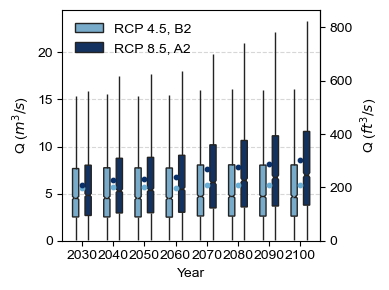

In [60]:
# Settings
rp = '50'  # Choose one return period to plot
scenarios = ['A2', 'B2']
rcp_mapping = {'A2': 'rcp85', 'B2': 'rcp45'}
colors = {'rcp45': '#6baed6', 'rcp85': '#08306b'}
markers = {'rcp45': 'o', 'rcp85': 'o'}
hue_order = ['rcp45', 'rcp85']
legend_labels = {'rcp45': 'RCP 4.5, B2', 'rcp85': 'RCP 8.5, A2'}
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
ASM = 'Wet'

# Initialize data containers
data = {'Year': [], 'Scenario': [], 'Q Value': []}
mean_data = {'Year': [], 'Scenario': [], 'Mean Q': []}

# Extract and organize data
for scenario in scenarios:
    rcp = rcp_mapping[scenario]
    for year in years:
        col_name = f'Q_{rp}_{year}_{scenario}_{ASM}_fr'
        if col_name not in culvert.columns:
            continue
        q_vals = culvert[col_name].dropna().values.tolist()
        data['Year'].extend([str(year)] * len(q_vals))
        data['Scenario'].extend([rcp] * len(q_vals))
        data['Q Value'].extend(q_vals)
        mean_data['Year'].append(str(year))
        mean_data['Scenario'].append(rcp)
        mean_data['Mean Q'].append(np.mean(q_vals))

# Convert to DataFrames
df_box = pd.DataFrame(data)
df_mean = pd.DataFrame(mean_data)

# Conversion functions
def m3s_to_ft3s(x): return x * 35.3147
def ft3s_to_m3s(x): return x / 35.3147

# Create the plot
plt.figure(figsize=(4, 3))
ax = sns.boxplot(
    data=df_box,
    x='Year',
    y='Q Value',
    hue='Scenario',
    hue_order=hue_order,
    palette=colors,
    showfliers=False,
    notch=True,
    showcaps=False,
    gap=0.5
)

# Overlay mean values as scatter points
for rcp in hue_order:
    subset = df_mean[df_mean['Scenario'] == rcp].sort_values('Year')
    x_pos = np.arange(len(subset))
    ax.scatter(
        x_pos,
        subset['Mean Q'],
        marker=markers[rcp],
        s=10,
        color=colors[rcp],
        zorder=3
    )

# Final formatting
handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=[legend_labels[rcp] for rcp in hue_order],
    loc="upper left",
    frameon=False,

)
ax.grid(axis='y', which='major', linestyle="--", alpha=0.5)
ax.set_ylabel("Q ($m^3/s$)")
ax.set_xlabel("Year")
ax.set_ylim(0, None)

# Add secondary y-axis (right side)
secax = ax.secondary_yaxis('right', functions=(m3s_to_ft3s, ft3s_to_m3s))
secax.set_ylabel("Q ($ft^3/s$)")

plt.tight_layout()
plt.savefig(fr"D:\culvert repo\Results\Figures\Q_{rp}_by_year_{ASM}_paper.png", dpi=300, bbox_inches='tight')
plt.show()

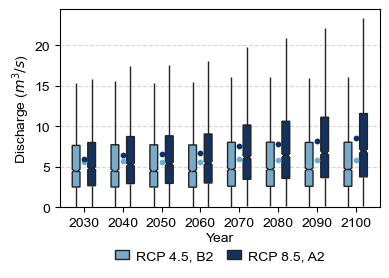

In [67]:
plt.figure(figsize=(4, 2.93))
ax = sns.boxplot(
    data=df_box,
    x='Year',
    y='Q Value',              # plot in m³/s
    hue='Scenario',
    hue_order=hue_order,
    palette=colors,
    showfliers=False,
    notch=True,
    showcaps=False,
    gap=0.5
)

# Overlay mean values (still in m³/s)
for rcp in hue_order:
    subset = df_mean[df_mean['Scenario'] == rcp].sort_values('Year')
    x_pos = np.arange(len(subset))
    ax.scatter(x_pos, subset['Mean Q'], marker=markers[rcp], s=10,
               color=colors[rcp], zorder=3)

# Labels & ticks
ax.set_ylabel("Discharge ($m^3/s$)", labelpad=2)   # only m³/s now
ax.set_xlabel("Year", labelpad=2)
ax.tick_params(axis='x', rotation=0)
ax.set_ylim(0, None)
ax.grid(axis='y', which='major', linestyle="--", alpha=0.5)

# Legend
handles, _ = ax.get_legend_handles_labels()
#ax.legend(handles=handles,
#          labels=[legend_labels[rcp] for rcp in hue_order],
#          loc="upper left", frameon=False)

ax.legend(handles=handles,
          labels=[legend_labels[rcp] for rcp in hue_order], title_fontsize=10, ncol=2,
          handlelength=1, columnspacing=1, handletextpad=0.5,
          loc="upper center", bbox_to_anchor=(0.5, -0.15), frameon=False)

plt.tight_layout()
plt.savefig(fr"D:\culvert repo\Results\Figures\Q_{rp}_by_year_{ASM}_paper_m3s.png",
            dpi=300, bbox_inches='tight')
plt.show()


In [85]:
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_LU_Q.xlsx'
# Save the DataFrame to an Excel file
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_LU_Q.xlsx


# Capacity multiplier by region


In [115]:
merged_culvert=pd.read_excel(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_LU_Q.xlsx')
np.shape(merged_culvert)

(2381, 1397)

In [118]:
def map_county_name(df):
    # Mapping based on the image
    region_county_map = {
        1: {1: 'Albany', 2: 'Essex', 3: 'Greene', 4: 'Rensselaer', 5: 'Saratoga', 6: 'Schenectady', 7: 'Warren', 8: 'Washington'},
        2: {1: 'Fulton', 2: 'Hamilton', 3: 'Herkimer', 4: 'Madison', 5: 'Montgomery', 6: 'Oneida'},
        3: {1: 'Cayuga', 2: 'Cortland', 3: 'Onondaga', 4: 'Oswego', 5: 'Seneca', 6: 'Tompkins'},
        4: {1: 'Genesee', 2: 'Livingston', 3: 'Monroe', 4: 'Ontario', 5: 'Orleans', 6: 'Wyoming', 7: 'Wayne'},
        5: {1: 'Cattaraugus', 2: 'Chautauqua', 3: 'Erie', 4: 'Niagara'},
        6: {1: 'Allegany', 2: 'Chemung', 3: 'Schuyler', 4: 'Steuben', 5: None, 6: 'Yates'},
        7: {1: 'Clinton', 2: 'Franklin', 3: 'Jefferson', 4: 'Lewis', 5: 'St. Lawrence'},
        8: {1: 'Columbia', 2: 'Dutchess', 3: 'Orange', 4: 'Putnam', 5: 'Rockland', 6: 'Ulster', 7: 'Westchester'},
        9: {1: 'Broome', 2: 'Chenango', 3: 'Delaware', 4: 'Otsego', 5: 'Schoharie', 6: 'Sullivan', 7: 'Tioga'},
        10: {1: 'Nassau', 2: 'Suffolk'},
        11: {1: 'Bronx', 2: 'Kings', 3: 'New York', 4: 'Queens', 5: 'Richmond'}
    }

    def get_county_name(row):
        region = row['REGION_x']
        county = row['COUNTY_x']
        return region_county_map.get(region, {}).get(county, None)

    df['county_name'] = df.apply(get_county_name, axis=1)
    return df

# ✅ Apply it to your DataFrame
merged_culvert = map_county_name(merged_culvert)
merged_culvert.county_name.isna

<bound method Series.isna of 0         Columbia
1         Columbia
2         Columbia
3         Columbia
4         Columbia
           ...    
2376    Chautauqua
2377    Chautauqua
2378    Chautauqua
2379    Chautauqua
2380    Chautauqua
Name: county_name, Length: 2381, dtype: object>

In [120]:
def add_flow_change(df):
    # 20% increase counties (dark blue)
    increase_20 = {
        'Albany', 'Bronx', 'Broome', 'Chenango', 'Columbia', 'Delaware', 'Dutchess',
        'Essex', 'Franklin', 'Fulton', 'Greene', 'Hamilton', 'Herkimer', 'Kings',
        'Madison', 'Montgomery', 'Nassau', 'New York', 'Oneida', 'Orange', 'Otsego',
        'Putnam', 'Queens', 'Rensselaer', 'Richmond', 'Rockland', 'Saratoga',
        'Schenectady', 'Schoharie', 'St. Lawrence', 'Suffolk', 'Sullivan', 'Ulster',
        'Warren', 'Washington', 'Westchester'
    }

    # 10% increase counties (light blue)
    increase_10 = {
        'Allegany', 'Cattaraugus', 'Cayuga', 'Chautauqua', 'Chemung', 'Cortland',
        'Erie', 'Genesee', 'Livingston', 'Monroe', 'Niagara', 'Ontario', 'Onondaga',
        'Orleans', 'Schuyler', 'Seneca', 'Steuben', 'Tioga', 'Tompkins', 'Wayne',
        'Wyoming', 'Yates'
    }

    def get_flow_change(county):
        if county in increase_20:
            return '20% Increase'
        elif county in increase_10:
            return '10% Increase'
        else:
            return 'Unknown'

    df['flow_change'] = df['county_name'].apply(get_flow_change)
    return df
merged_culvert = add_flow_change(merged_culvert)
merged_culvert['flow_change']

0       20% Increase
1       20% Increase
2       20% Increase
3       20% Increase
4       20% Increase
            ...     
2376    10% Increase
2377    10% Increase
2378    10% Increase
2379    10% Increase
2380    10% Increase
Name: flow_change, Length: 2381, dtype: object

In [1]:
2418-2381

37

In [121]:
def apply_flow_multiplier(df):
    # Define which columns to modify
    q_cols = ['Q_2', 'Q_5', 'Q_10', 'Q_25', 'Q_50', 'Q_100', 'Q_200', 'Q_500', 'Q_1000']

    # Define a function to get the multiplier
    def get_multiplier(flow_change):
        if flow_change == '20% Increase':
            return 1.2
        elif flow_change == '10% Increase':
            return 1.1
        else:
            return 1.0  # No change or unknown

    # Get multiplier per row
    df['flow_multiplier'] = df['flow_change'].apply(get_multiplier)

    # Apply multiplier to each Q column and create new columns
    for col in q_cols:
        new_col = f"{col}_m"
        df[new_col] = df[col] * df['flow_multiplier']

    return df
merged_culvert = apply_flow_multiplier(merged_culvert)
merged_culvert['Q_2_m']

0       1.417145
1       1.772092
2       0.499378
3       0.292313
4       1.927651
          ...   
2376    1.442410
2377    2.352963
2378    1.850179
2379    3.897583
2380    2.146083
Name: Q_2_m, Length: 2381, dtype: float64

In [123]:
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_LU_Q_m.xlsx'
# Save the DataFrame to an Excel file
merged_culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_LU_Q_m.xlsx


In [3]:
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_LU_Q_m.xlsx'
# Save the DataFrame to an Excel file
merged_culvert= pd.read_excel(excel_output_file)
merged_culvert

BIN    Ini_lon    Ini_lat  lonsnap_10  latsnap_10       Area_10  \
0     C810530 -73.429865  42.334525  -73.429844   42.334566  2.673297e+01   
1     C810550 -73.426565  42.356158  -73.426511   42.356142  5.148572e+01   
2     C810490 -73.467865  42.295775  -73.467800   42.295790  1.091018e+03   
3     C810520 -73.450665  42.329508  -73.450623   42.329457  5.053763e+01   
4     C810491 -73.471549  42.304492  -73.471596   42.304521  5.395714e+06   
...       ...        ...        ...         ...         ...           ...   
2376  C520244 -79.754931  42.020207  -79.754915   42.020173  3.507870e+01   
2377  C520245 -79.732181  42.025557  -79.732223   42.025584  1.804048e+01   
2378  C520214 -79.693698  42.022424  -79.693647   42.022455  2.204947e+01   
2379  C520247 -79.697515  42.024057  -79.697524   42.024093  2.104722e+01   
2380  C520248 -79.671764  42.021457  -79.671724   42.021486  2.244306e+06   

           Peri_10   LFP_len_10  LFP_S_10   Bas_S_10  ...  flow_multiplier  \
0        35.821539    11.428346     2.926   2.309196  ...              1.2   
1        43.781881    15.991400     3.700   4.434731  ...              1.2   
2       300.627896   103.681115     3.744   8.746858  ...              1.2   
3        43.800091    15.244132     9.992   7.078594  ...              1.2   
4     18662.820509  5132.397088     4.414  20.059115  ...              1.2   
...            ...          ...       ...        ...  ...              ...   
2376     32.035958     9.839471     6.828  11.708542  ...              1.1   
2377     30.033711     8.666582     5.307   3.539234  ...              1.1   
2378     38.042700    13.672200     2.289   2.055939  ...              1.1   
2379     32.035958    11.083508     2.075   1.943400  ...              1.1   
2380  11480.886496  3466.854215     2.428   9.796019  ...              1.1   

         Q_2_m     Q_5_m    Q_10_m     Q_25_m     Q_50_m    Q_100_m  \
0     1.417145  2.518265  3.431420   4.704176   5.694010   6.725021   
1     1.772092  3.328119  4.652763   6.529447   8.004122   9.554235   
2     0.499378  1.046642  1.530985   2.231943   2.792831   2.792831   
3     0.292313  0.552667  0.788972   1.130365   1.401278   1.687962   
4     1.927651  4.041669  5.958839   8.775302  11.050422  13.479426   
...        ...       ...       ...        ...        ...        ...   
2376  1.442410  2.468710  3.316402   4.501682   5.410561   6.384686   
2377  2.352963  4.028934  5.436041   7.411884   8.930221  10.559965   
2378  1.850179  3.073815  4.071244   5.453853   6.511641   7.633849   
2379  3.897583  6.520770  8.665859  11.646065  13.928746  16.355597   
2380  2.146083  3.567926  4.724853   6.326040   7.552346   8.850450   

        Q_200_m    Q_500_m   Q_1000_m  
0      7.819420   9.338464  10.540724  
1     11.214897  13.538947  15.430999  
2      3.152070   3.975755   4.648983  
3      1.997001   2.431730   2.780575  
4     16.114554  19.846813  22.858796  
...         ...        ...        ...  
2376   7.489161   9.105181  10.449821  
2377  12.402122  15.091829  17.328097  
2378   8.880281  10.672236  12.142220  
2379  19.061656  22.962752  26.173084  
2380  10.286308  12.345448  14.028110  

[2381 rows x 1409 columns]

In [8]:
culvert=merged_culvert

In [4]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-09-03 09:12:41.549604


In [5]:
%load_ext watermark
# Print the Python version and some dependencies
%watermark -v -m -p numpy,pandas,geopandas,sklearn,matplotlib,seaborn,os,rasterio,tqdm,scipy

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

numpy     : 2.0.2
pandas    : 2.2.2
geopandas : 1.0.1
sklearn   : 1.5.1
matplotlib: 3.8.4
seaborn   : 0.13.2
os        : unknown
rasterio  : 1.4.3
tqdm      : 4.66.5
scipy     : 1.13.1

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

